# Filtering

## 1. Imports

In [1]:
# Core Libraries
import numpy as np # For handling arrays, mathematical operations and voxel data
import os # For file and path operations

# NIfTI image I/O
import nibabel as nib # For loading and saving NIfTI medical images 

# Filtering operations
from scipy.ndimage import uniform_filter # For multi-dimensional mean filtering
from scipy.ndimage import gaussian_filter, laplace # For 2D/3D Gaussian filtering (LoG, smoothing etc.)
from scipy.ndimage import convolve # For custom kernel filtering (Laws, Gabor, etc.)

# Padding utilities 
import torch.nn.functional as F # For padding methods

# Visualization
import matplotlib.pyplot as plt # For displaying slices

import math # For precise size calculations
import cv2

## 2. Loading images

In [2]:
# Base directory
base_path = '/home/anuuu/Documents/Internship/Tasks/filtering/test_dataset'

# Expected names of the folders
folders = [name for name in os.listdir(base_path) 
           if os.path.isdir(os.path.join(base_path, name))]
print(folders)

# Dictionary to store image data with folder names as keys
folder_images = {}

# Loop through folders and load the NIfTI image inside each
for folder in folders:
    image_path = os.path.join(base_path, folder, 'image', f'{folder}.nii.gz') 
    # Base path = '/home/anuuu/Documents/Internship/Tasks/filtering/test_dataset' + folder eg: 'checkerboard' + 'image' + folder.nii eg: 'checkerboard.nii'
    print(image_path)

    if not os.path.exists(image_path):
        print(f'NIfTI file not found for folder: {folder}')
        continue

    # Load the .nii image and convert to NumPy array (3D)
    nifti_img = nib.load(image_path)
    img = nifti_img.get_fdata()

    # Save to dictionary with folder name as key
    folder_images[folder] = img
    print(f'Loaded "{folder}": shape = {img.shape}')    

['checkerboard', 'empty', 'impulse', 'noise', 'orientation', 'pattern_1', 'pattern_2', 'pattern_3', 'sphere']
/home/anuuu/Documents/Internship/Tasks/filtering/test_dataset/checkerboard/image/checkerboard.nii.gz
Loaded "checkerboard": shape = (64, 64, 64)
/home/anuuu/Documents/Internship/Tasks/filtering/test_dataset/empty/image/empty.nii.gz
Loaded "empty": shape = (64, 64, 64)
/home/anuuu/Documents/Internship/Tasks/filtering/test_dataset/impulse/image/impulse.nii.gz
Loaded "impulse": shape = (64, 64, 64)
/home/anuuu/Documents/Internship/Tasks/filtering/test_dataset/noise/image/noise.nii.gz
Loaded "noise": shape = (64, 64, 64)
/home/anuuu/Documents/Internship/Tasks/filtering/test_dataset/orientation/image/orientation.nii.gz
Loaded "orientation": shape = (32, 48, 64)
/home/anuuu/Documents/Internship/Tasks/filtering/test_dataset/pattern_1/image/pattern_1.nii.gz
Loaded "pattern_1": shape = (64, 64, 64)
/home/anuuu/Documents/Internship/Tasks/filtering/test_dataset/pattern_2/image/pattern_2.n

In [3]:
# Get the 4 required images in a list
checkerboard = folder_images['checkerboard']
impulse = folder_images['impulse']
sphere = folder_images['sphere']
pattern_1 = folder_images['pattern_1']

orientation = folder_images['orientation']
images = [('Checkerboard',checkerboard), ('Impulse', impulse), ('Sphere', sphere), ('Pattern_1', pattern_1)]

filtered_images = []

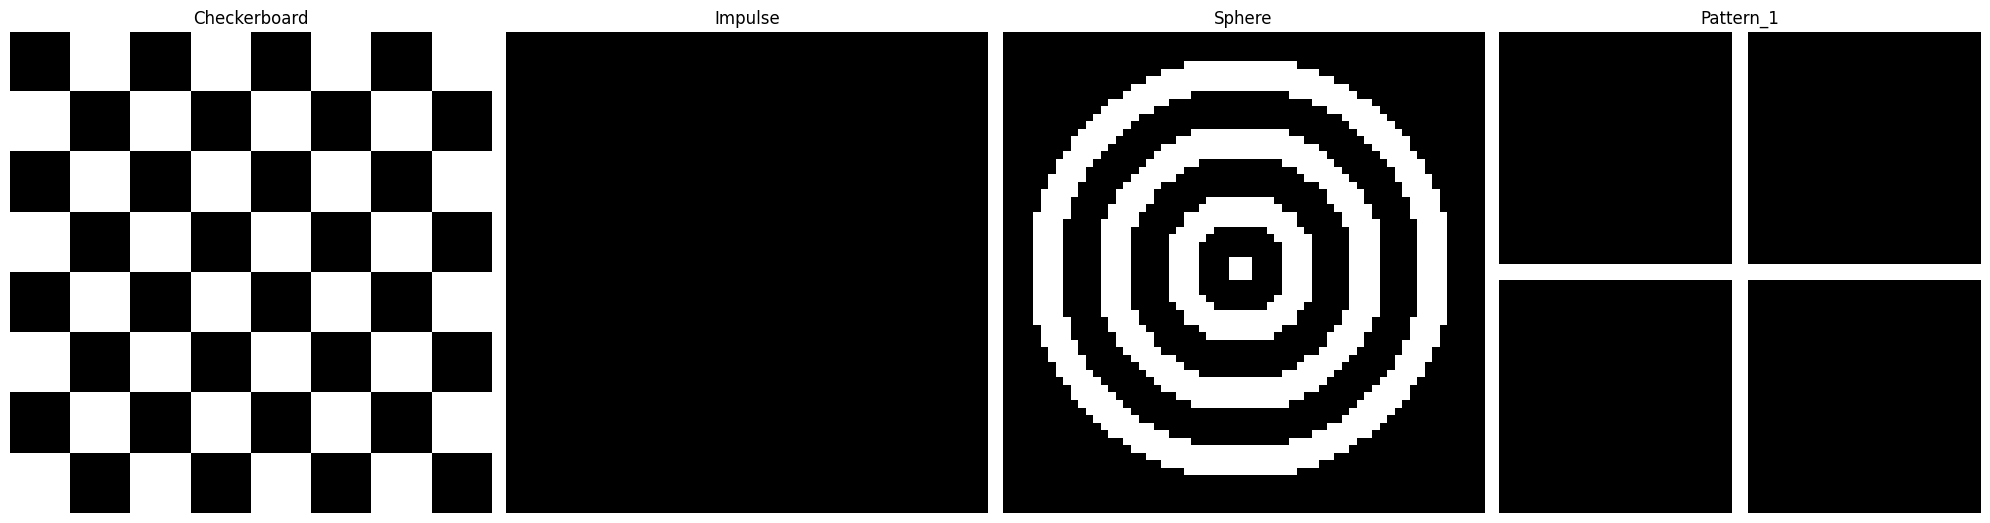

In [4]:
# Visualize the 4 images
fig, axs = plt.subplots(1, len(images), figsize=(20, 10))

for i, (name, image) in enumerate(images):
    slice_ = image[image.shape[0] // 2, :, :]
    axs[i].imshow(slice_, cmap='gray')
    axs[i].set_title(name)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

In [5]:
def visualize_images_3D(orig_img, pad_img, filtered_img, suptitle='Images'):
        '''
        Visualizes the slices of 3 3D images:
            Original image
            Padded image
            Filtered image
        '''
        orig_slice = orig_img[orig_img.shape[0] // 2, :, :]
        pad_slice = pad_img[pad_img.shape[0] // 2, :, :]
        filtered_slice = filtered_img[filtered_img.shape[0] // 2, :, :]

        slices = [('Original',orig_slice), ('Padded',pad_slice), ('Filtered',filtered_slice)]
    
        fig, axs = plt.subplots(1, 3, figsize=(20, 10))

        for i, (name, slice) in enumerate(slices):
            axs[i].imshow(slice, cmap='gray')
            axs[i].axis('off')
            axs[i].set_title(name)

        plt.suptitle(suptitle)
        plt.tight_layout()
        plt.show()

In [6]:
def visualize_3D_views(image, suptitle='3D Image Views'):
    '''
    Visualizes the axial, coronal, and sagittal views of a 3D image.
    
    Args:
        image (np.ndarray): 3D image array.
        suptitle (str): Title for the entire figure.
    '''
    # Extract middle slices along each axis
    axial = image[image.shape[0] // 2, :, :]       # Z axis (top-down view)
    coronal = image[:, image.shape[1] // 2, :]     # Y axis (front-back view)
    sagittal = image[:, :, image.shape[2] // 2]    # X axis (side view)

    views = [('Axial (Z)', axial),
             ('Coronal (Y)', coronal),
             ('Sagittal (X)', sagittal)]

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, (name, view) in enumerate(views):
        axs[i].imshow(view.T, cmap='gray', origin='lower')  # transpose for correct orientation
        axs[i].set_title(name)
        axs[i].axis('off')

    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85) 
    plt.show()

In [7]:
def visualize_images_2D(axial_slice, coronal_slice, sagittal_slice, suptitle=''):
        '''
        Visualizes the 3 2D images:
            Axial Slice
            Coronal Slice
            Sagittal Slice
        '''
        slices = [('Axial Slice',axial_slice), ('Coronal Slice',coronal_slice), ('Sagittal Slice',sagittal_slice)]
    
        fig, axs = plt.subplots(1, 3, figsize=(20, 10))

        for i, (name, slice) in enumerate(slices):
            axs[i].imshow(slice, cmap='gray')
            axs[i].axis('off')
            axs[i].set_title(name)

        plt.suptitle(f' 2D {suptitle} Filtered Axial & Coronal & Sagittal Slices')
        plt.tight_layout()
        plt.show()

## 3. Applying Padding to the images

In [8]:
# Set kernel size 
kernel_size = 15

# Set pad size
pad_size = kernel_size // 2

In [9]:
# Zero padding

# Checkerboard
zero_pad_checkerboard = np.pad(checkerboard, pad_size, mode='constant', constant_values=0)

# Impulse
zero_pad_impulse = np.pad(impulse, pad_size, mode='constant', constant_values=0)

# Sphere
zero_pad_sphere = np.pad(sphere, pad_size, mode='constant', constant_values=0)

In [121]:
# Nearest Value Padding

# Checkerboard 
nearest_pad_checkerboard = np.pad(checkerboard, pad_size, mode='edge')

# Pattern_1
nearest_pad_pattern_1 = np.pad(pattern_1, pad_size, mode='edge')

In [11]:
# Periodic Value Padding

# Checkerboard
periodic_pad_checkerboard = np.pad(checkerboard, pad_size, mode='wrap')

In [12]:
# Mirror padding

# Checkerboard
mirror_pad_checkerboard = np.pad(checkerboard, pad_size, mode='reflect')

## 3. Filtering methods

### 1.  Mean Filtering

* A smoothing operation used to **reduce noise** in images.
* It works by **replacing each voxel's value with the average of its neighbors** in a specified window.
* `Support M =15` means the kernel size is 15x15 (for 2D) or 15x15x15 (for 3D) 

#### 3D Mean Filtering

In [13]:
# 3D Mean Filtering 

def mean_filter_3D(image, kernel_size=15, pad_mode='constant'):
        '''
        Applies a 3D mean filter to a 3D image.
        
        Args:
            image (np.ndarray): The 3D image.
            kernel_size (int): The size of the mean filter kernel (e.g., 3 for a 3x3x3 kernel).
            
        Returns:
            np.ndarray: The filtered 3D image.
        '''
        kernel = np.ones((kernel_size, kernel_size, kernel_size)) / (kernel_size * kernel_size * kernel_size)
        filtered_image = convolve(image, kernel, mode=pad_mode, cval=0.0)
        return filtered_image

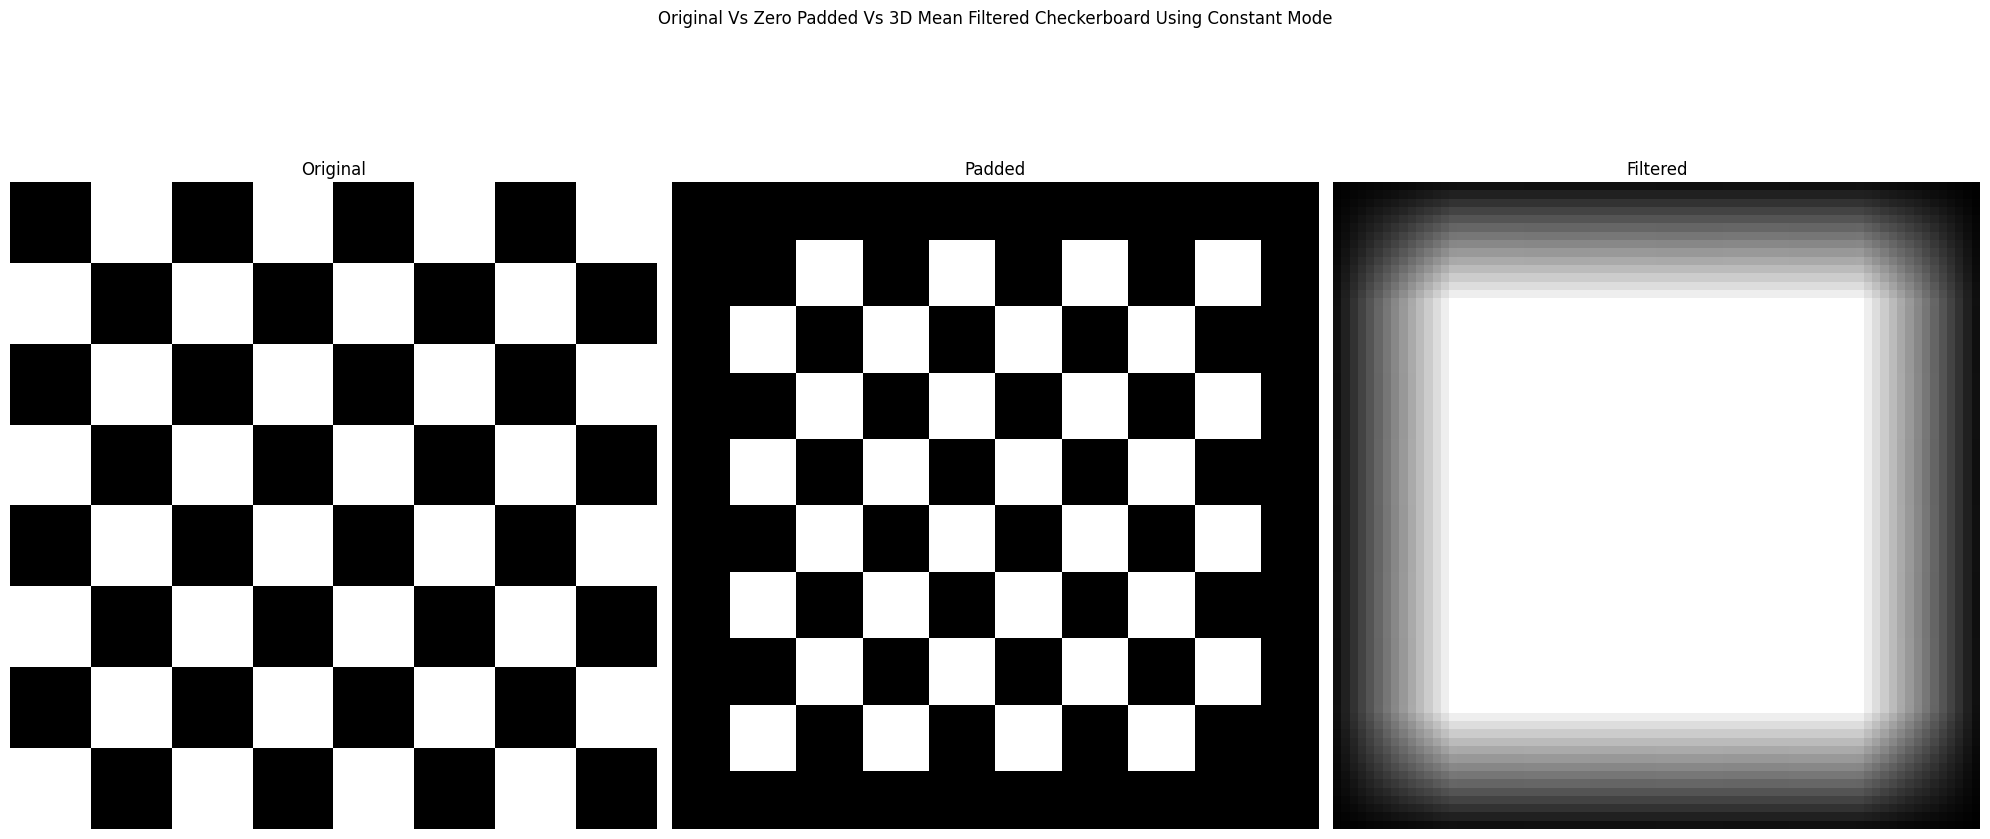

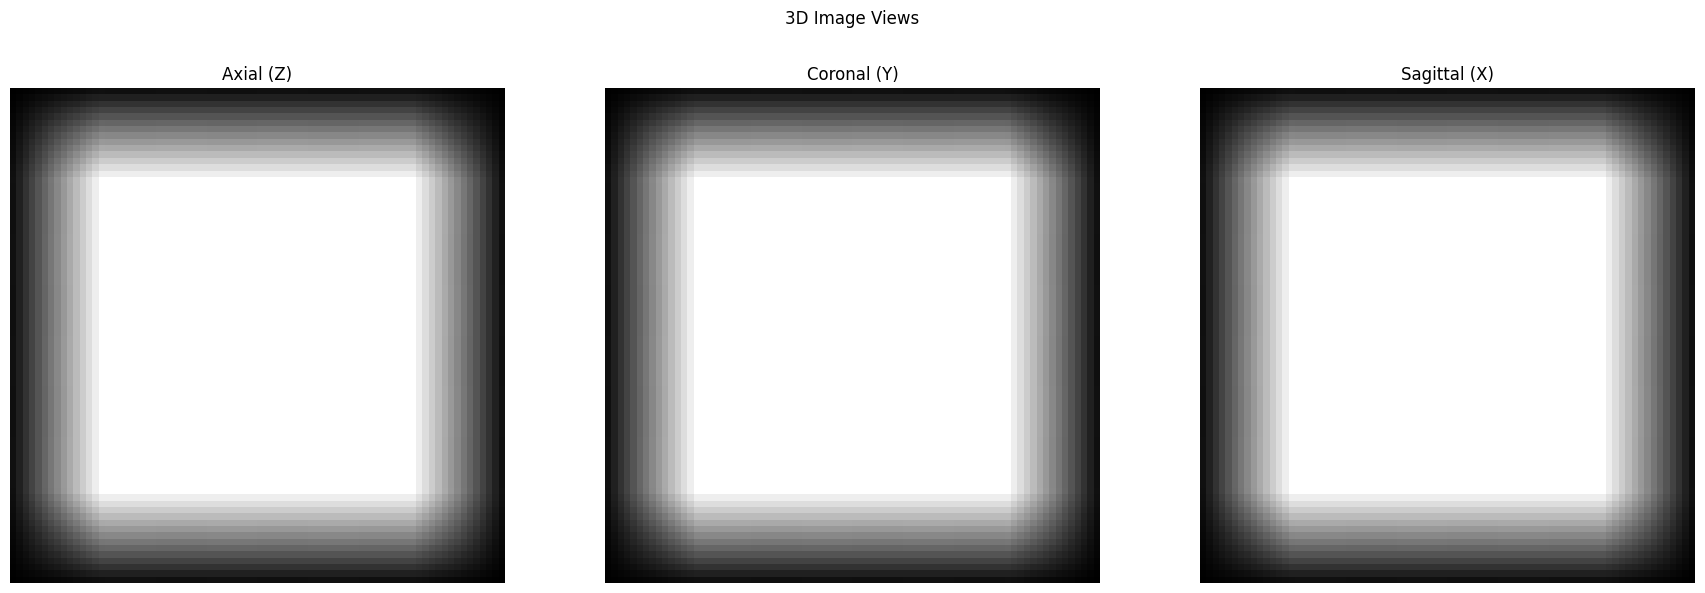

In [14]:
# 3D Mean Filtering Using Constant Mode
# 3D + Mean + Checkerboard + Constant= 3MZC
filtered_3MCC = mean_filter_3D(zero_pad_checkerboard, kernel_size=15, pad_mode='constant')

# Append
filtered_images.append(('3D_Mean_Zero_Checkerboard', filtered_3MCC))

# Visualize
visualize_images_3D(checkerboard, zero_pad_checkerboard, filtered_3MCC, 'Original Vs Zero Padded Vs 3D Mean Filtered Checkerboard Using Constant Mode' )
visualize_3D_views(filtered_3MCC)

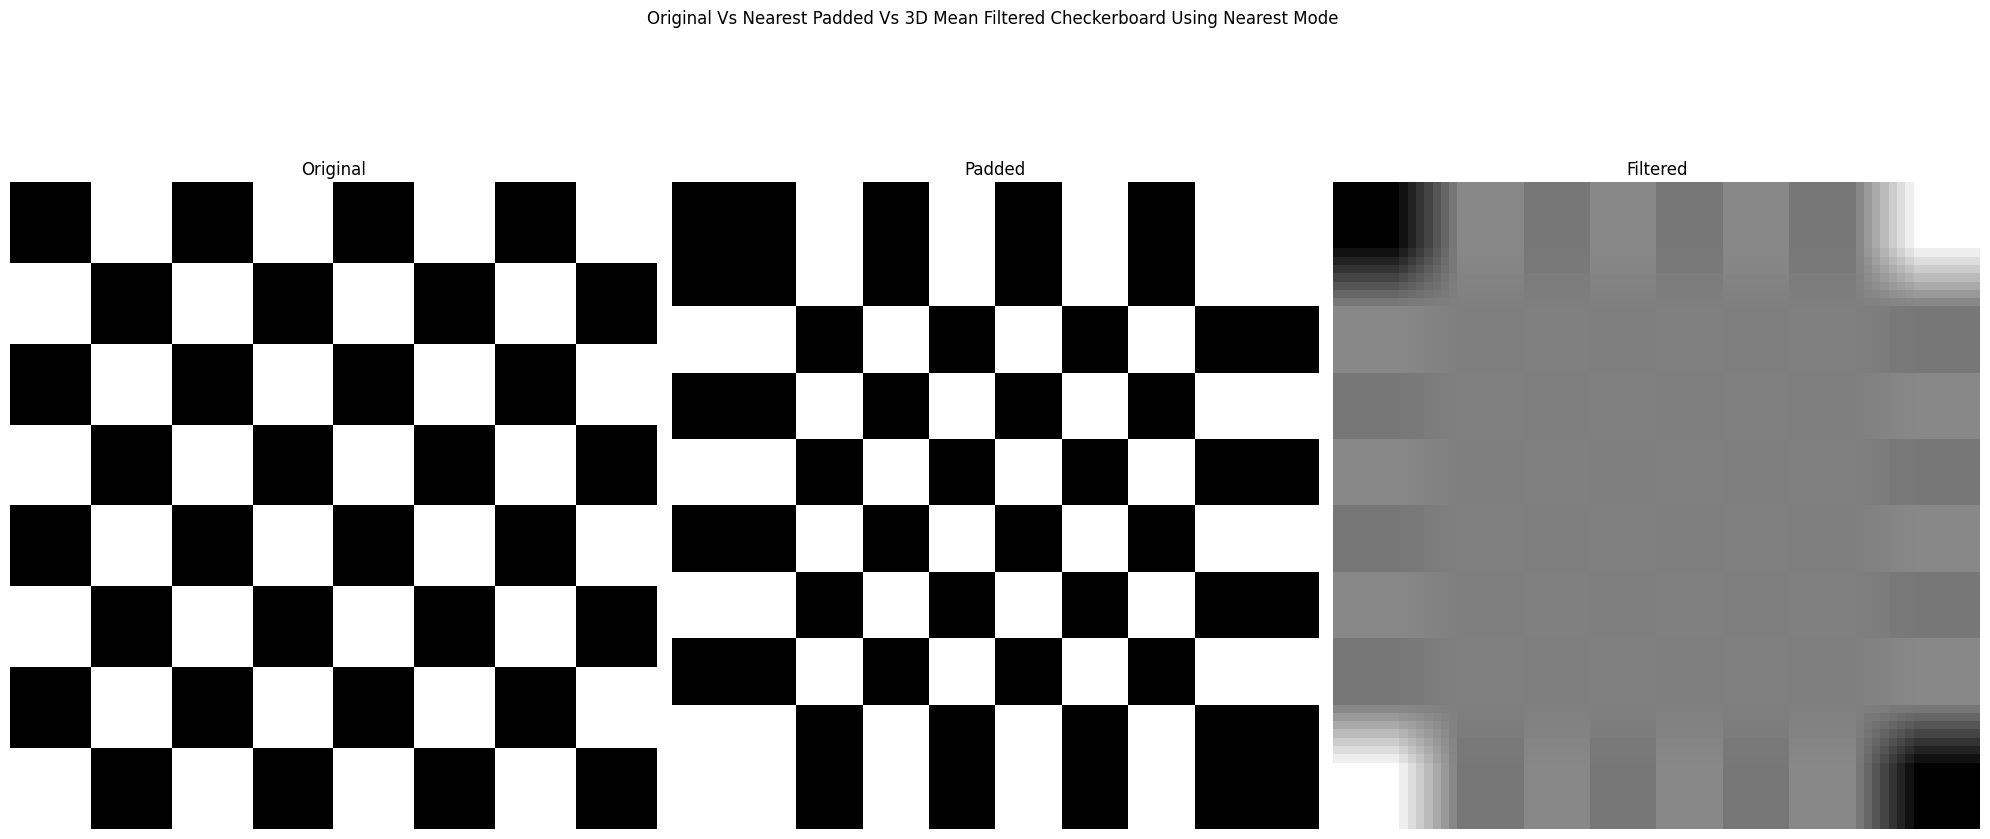

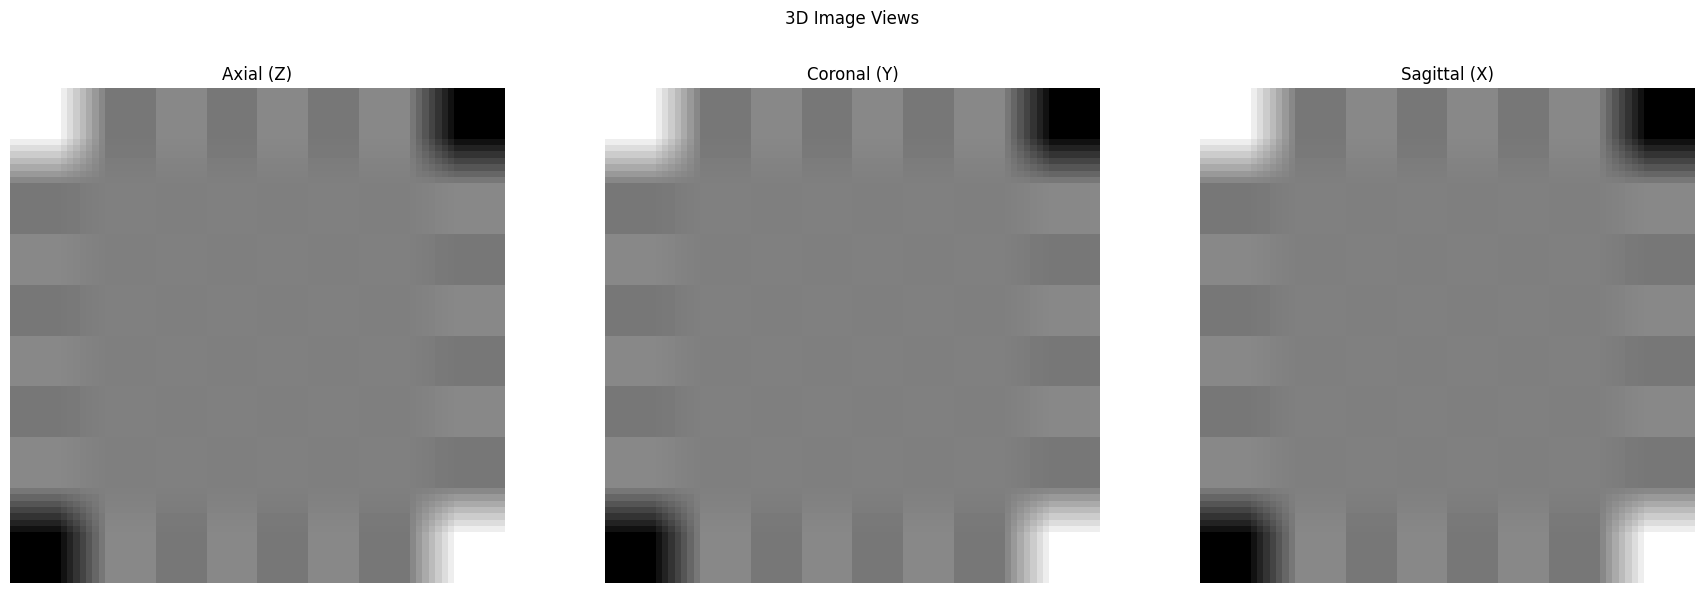

In [15]:
# 3D Mean Filtering Using Nearest Mode

filtered_3MCN = mean_filter_3D(nearest_pad_checkerboard, kernel_size=15, pad_mode='nearest')

# Append
filtered_images.append(('3D_Mean_Nearest_Checkerboard', filtered_3MCN))

# Visualize
visualize_images_3D(checkerboard, nearest_pad_checkerboard, filtered_3MCN, 'Original Vs Nearest Padded Vs 3D Mean Filtered Checkerboard Using Nearest Mode ')
visualize_3D_views(filtered_3MCN)

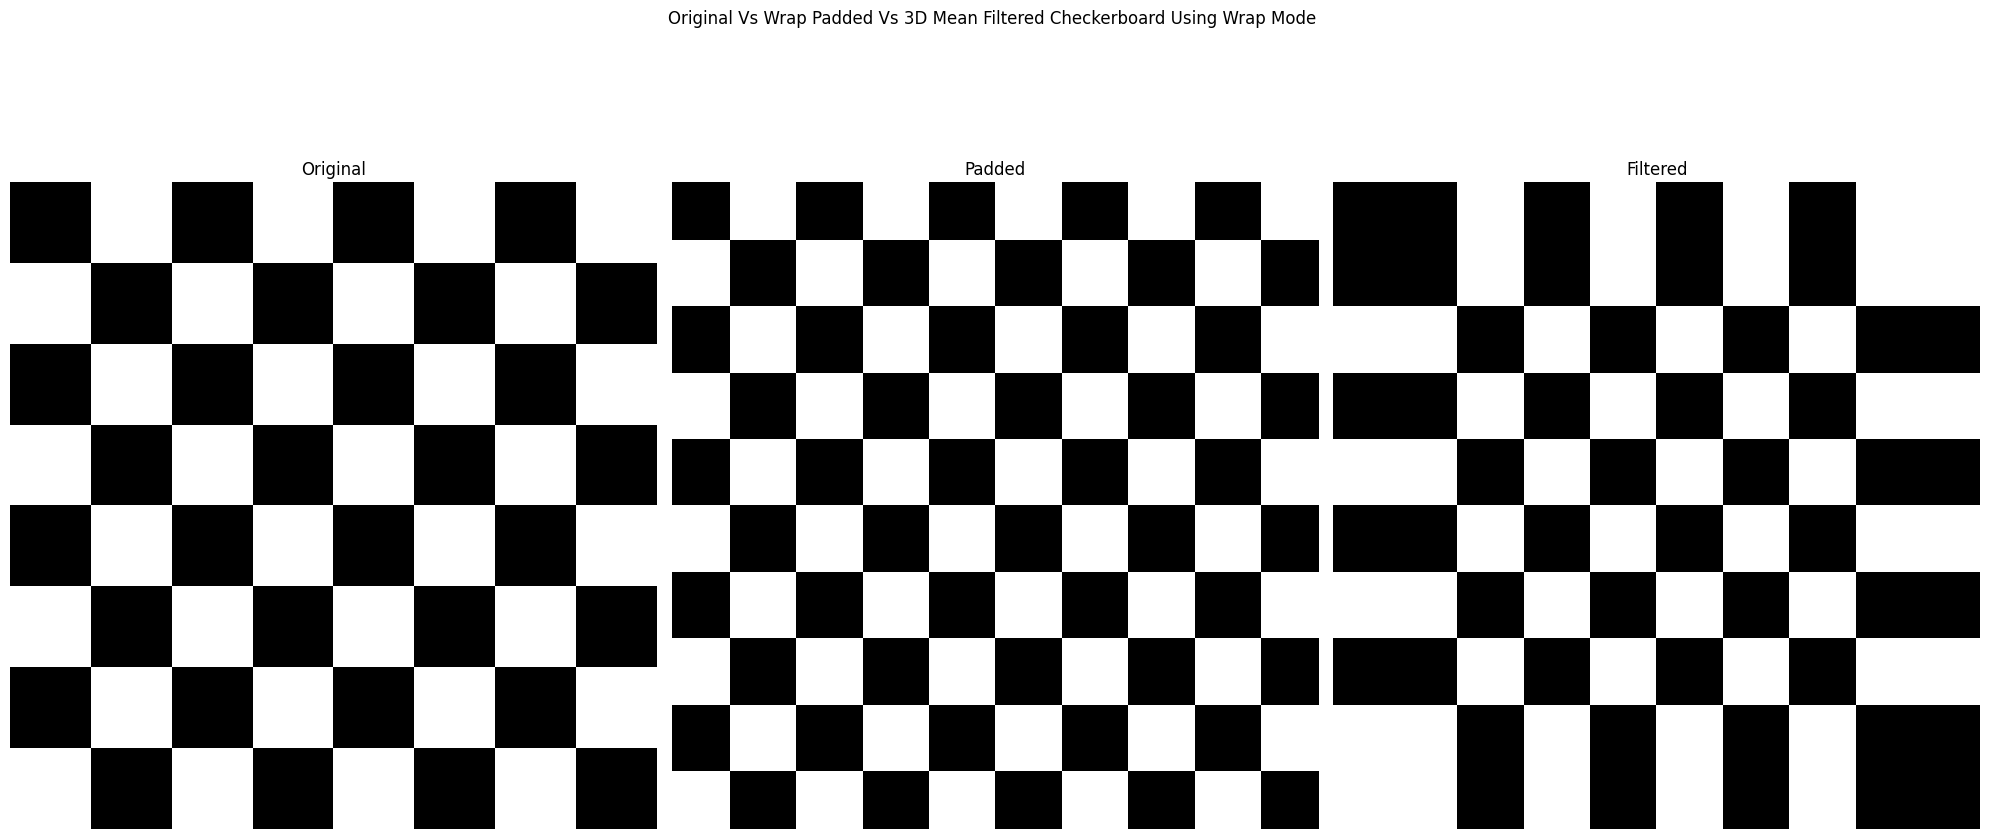

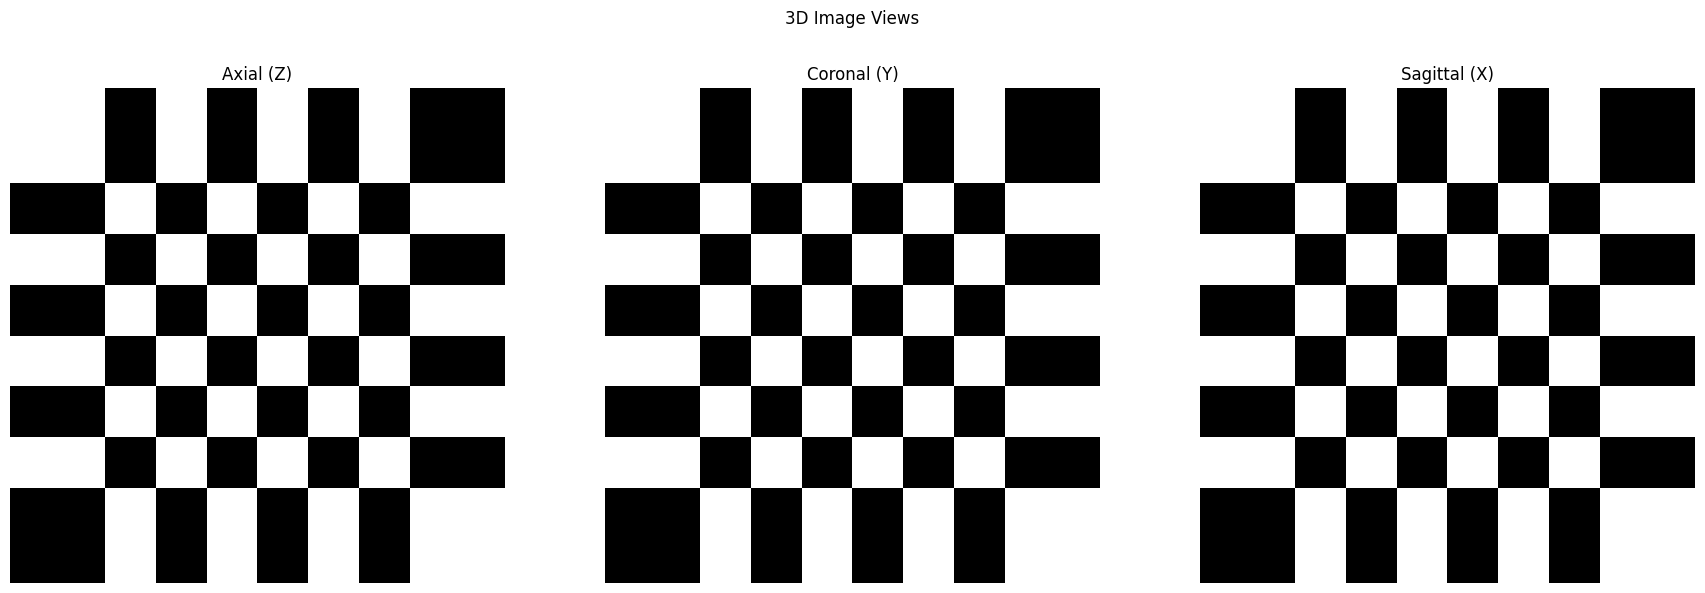

In [16]:
# 3D Mean Filtering Using Wrap Mode

filtered_3MCW= mean_filter_3D(periodic_pad_checkerboard, kernel_size=15, pad_mode='wrap')

# Append
filtered_images.append(('3D_Mean_Wrap_Checkerboard', filtered_3MCW))

# Visualize
visualize_images_3D(checkerboard, periodic_pad_checkerboard, filtered_3MCW, 'Original Vs Wrap Padded Vs 3D Mean Filtered Checkerboard Using Wrap Mode ')
visualize_3D_views(filtered_3MCW)

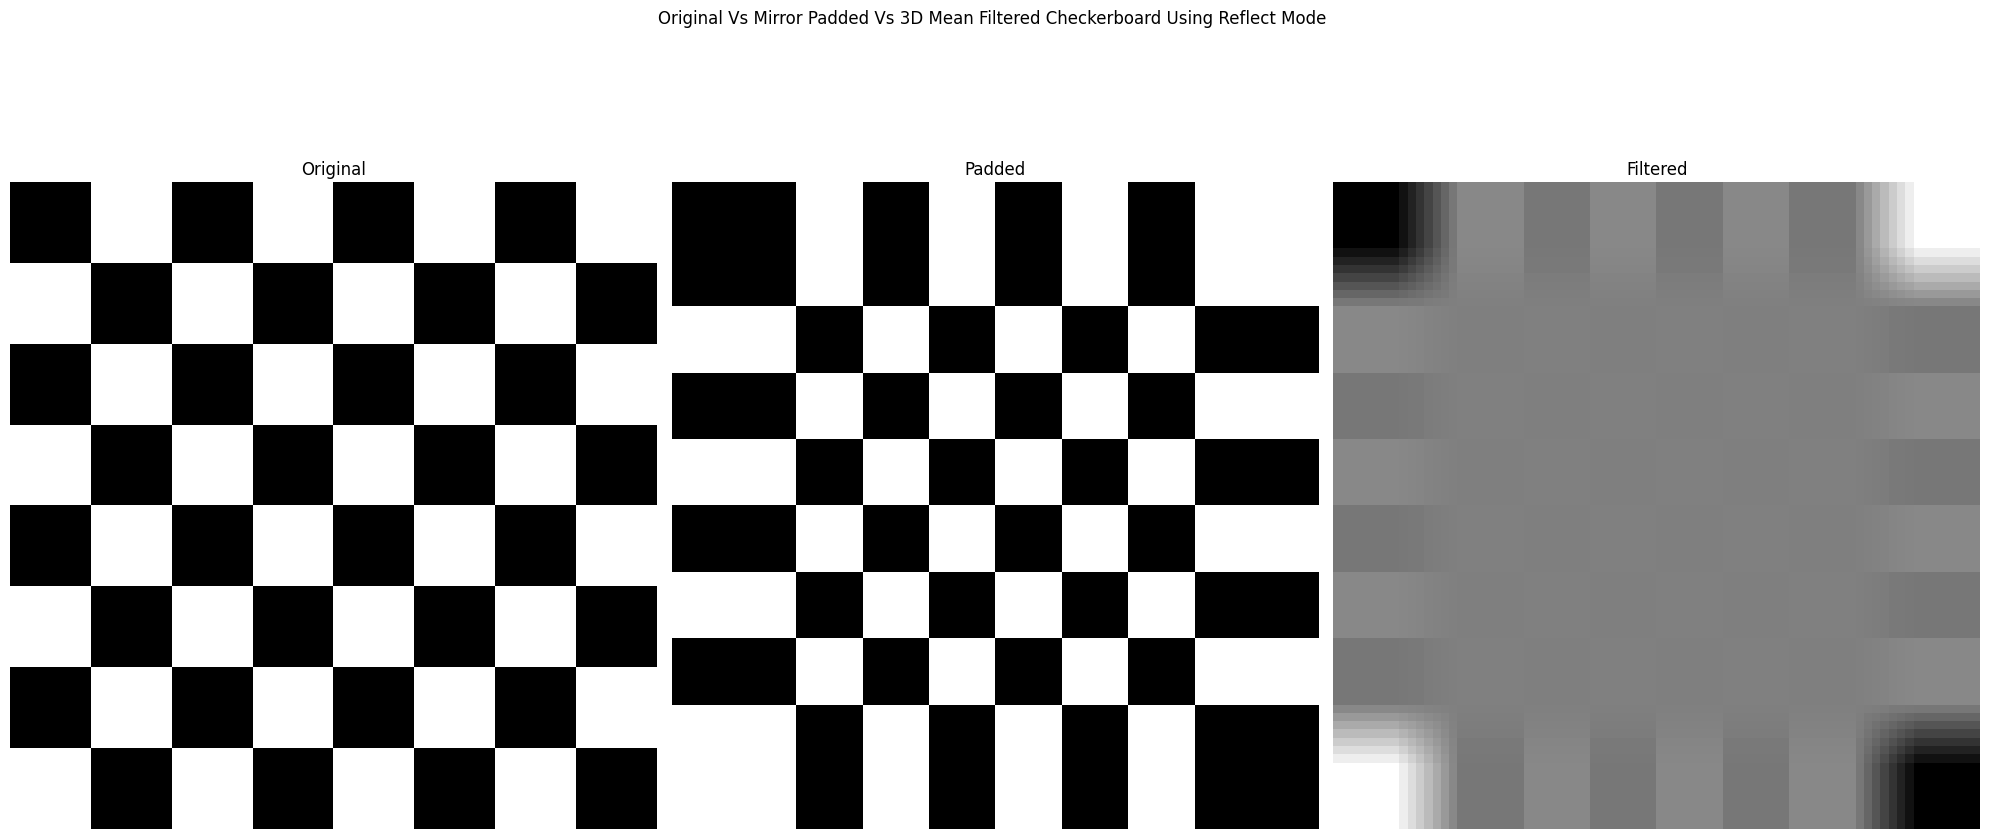

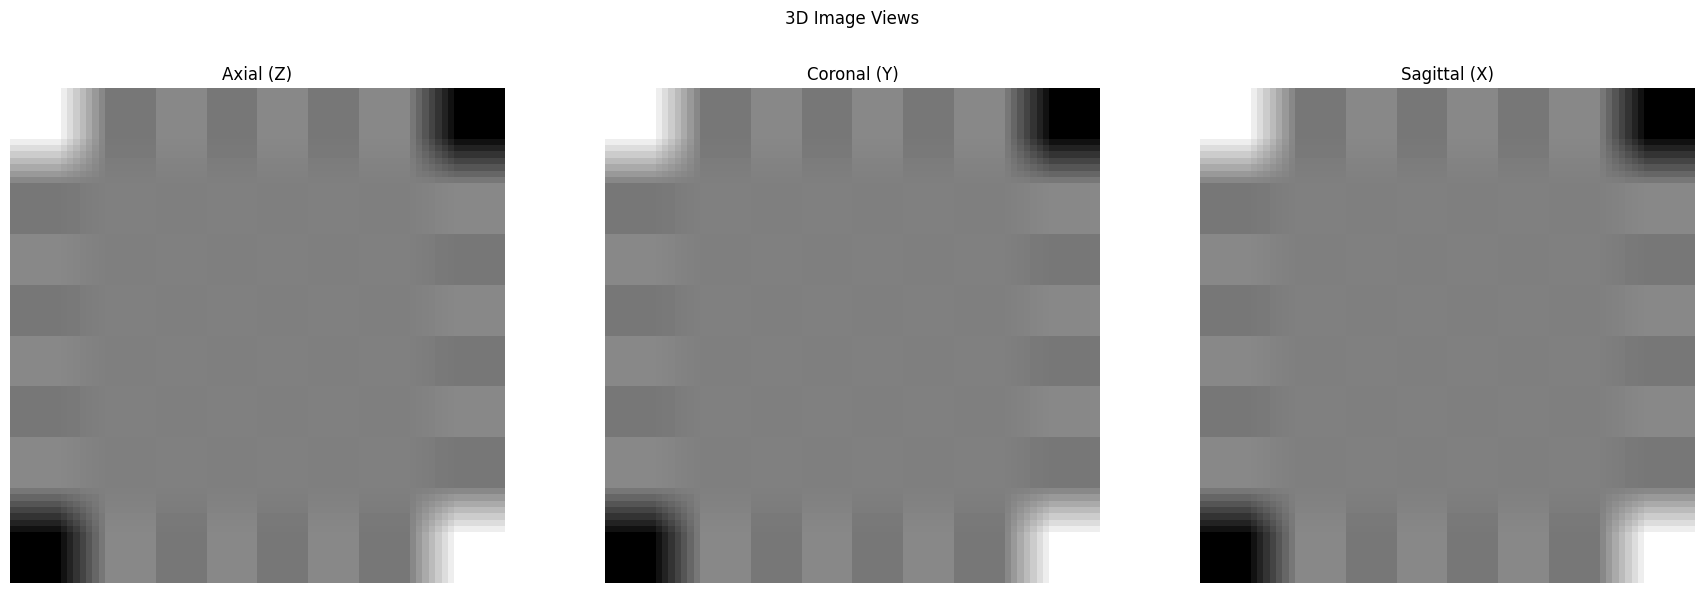

In [17]:
# 3D Mean Filtering Using Reflect Mode

filtered_3MCR = mean_filter_3D(mirror_pad_checkerboard, kernel_size=15, pad_mode='reflect')

# Append
filtered_images.append(('3D_Mean_Reflect_Checkerboard', filtered_3MCR))

# Visualize
visualize_images_3D(checkerboard, mirror_pad_checkerboard, filtered_3MCR, 'Original Vs Mirror Padded Vs 3D Mean Filtered Checkerboard Using Reflect Mode ')
visualize_3D_views(filtered_3MCR)

#### 2D Mean Filtering

In [18]:
# 2D Mean Filtering 

def mean_filter_2D(image, kernel_size=15, pad_mode='constant'):
        '''
        Applies a 2D mean filter to a 2D image.
        
        Args:
            image (np.ndarray): The 2D Slice of the image.
            kernel_size (int): The size of the mean filter kernel (e.g. 3 for 3x3x3 kernel).

        Returns:
            np.ndarray: The filtered 2D image slice.
        '''
        kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
        filtered_image = convolve(image, kernel, mode=pad_mode, cval=255)
        return filtered_image

In [19]:
impulse.shape

# Get the middle axis of each axis
idx = impulse.shape[0] // 2 # Since the shape is 64 for each 

# Extract the slices
axial_impulse = impulse[idx, :, :] # Axial slice (XY plane at Z)
coronal_impulse = impulse[:, idx, :] # Coronal slice (XZ plane at Y)
sagittal_impulse = impulse[:, :, idx] # Sagittal slice (YZ plane at X)

In [20]:
# Zero padding

zero_pad_axial_impulse = np.pad(axial_impulse, pad_size, mode='constant', constant_values=0)
zero_pad_coronal_impulse = np.pad(coronal_impulse, pad_size, mode='constant', constant_values=0)
zero_pad_sagittal_impulse = np.pad(sagittal_impulse, pad_size, mode='constant', constant_values=0)

In [21]:
# 2D Mean Filtering Using Constant Mode

# Axial Slice
filtered_2MAC = mean_filter_2D(zero_pad_axial_impulse, kernel_size=15, pad_mode='constant')

# Coronal Slice
filtered_2MCC = mean_filter_2D(zero_pad_coronal_impulse, kernel_size=15, pad_mode='constant')

# Sagittal Slice
filtered_2MSC = mean_filter_2D(zero_pad_sagittal_impulse, kernel_size=15, pad_mode='constant')

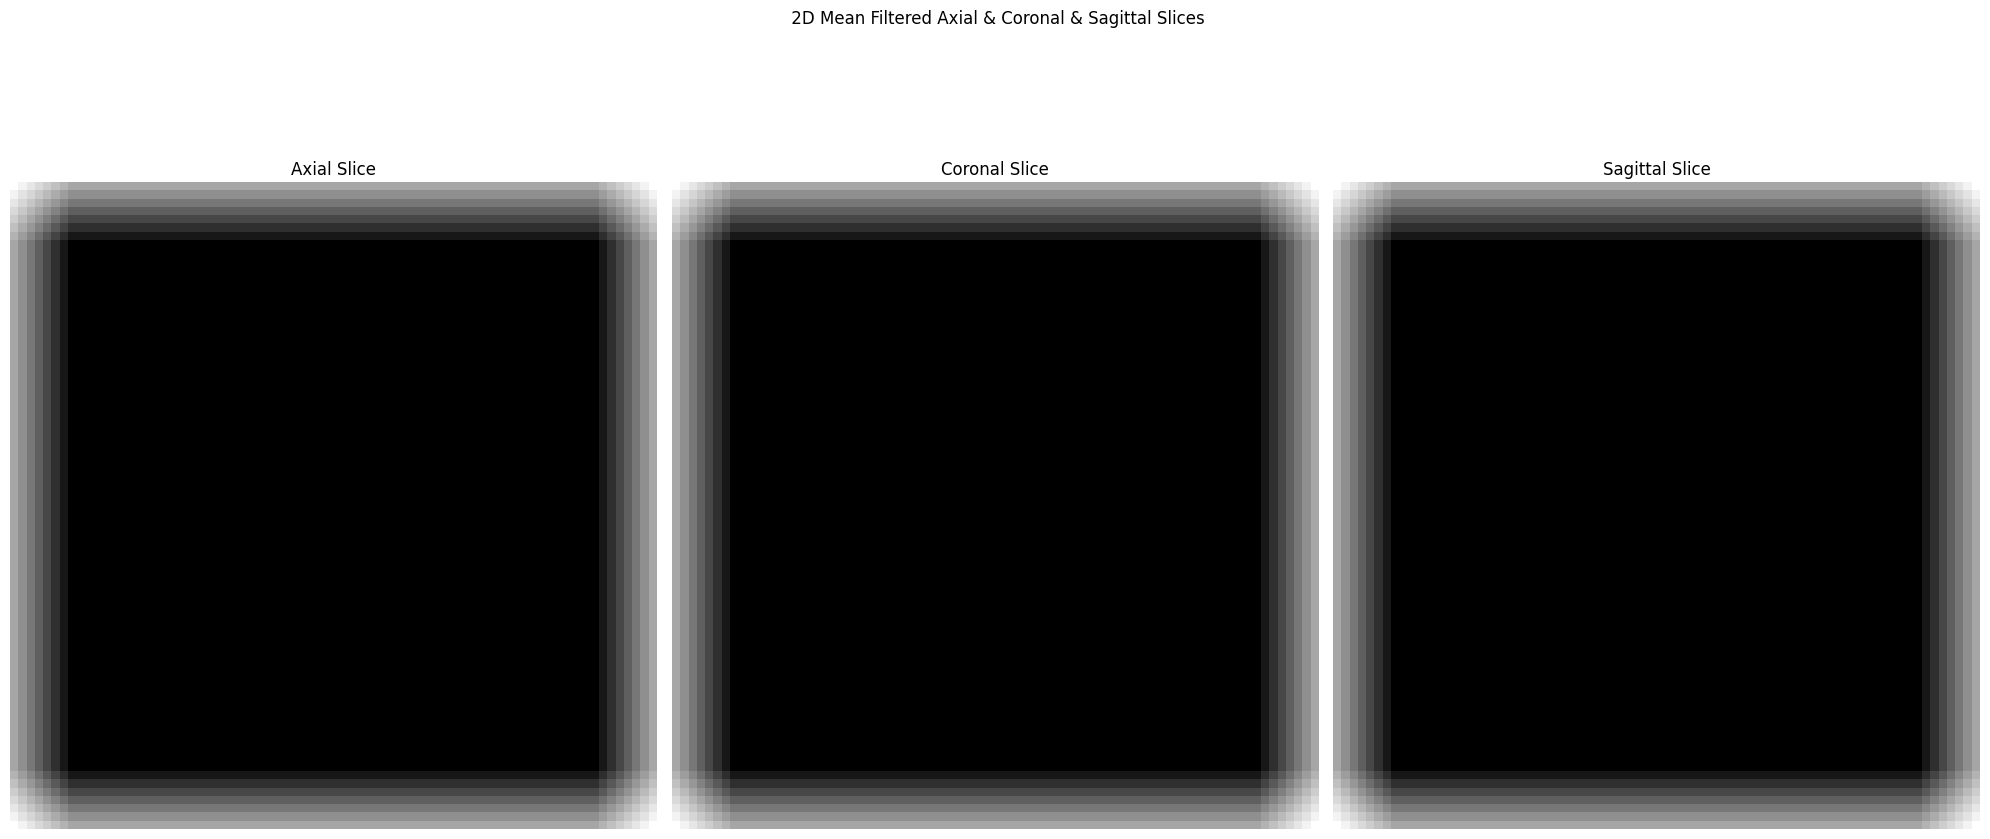

In [22]:
# Visualize
visualize_images_2D(filtered_2MAC, filtered_2MCC, filtered_2MSC, 'Mean' )

### Laplacian of Gaussian (LoG)
* Used for edge detection.
* Combination of 2 operations:
1. `Gaussian Filter`: smooths the image (reduces noise)
2. `Laplacian Operator`: detects the edges

In [23]:
def create_log_kernel(size, sigma, dimensions=2):
    """
    Create the Laplacian of Gaussian (LoG) kernel.
    """
    ax = np.linspace(-(size // 2), size // 2, size)

    if dimensions == 2:
        xx, yy = np.meshgrid(ax, ax)
        kernel = (xx**2 + yy**2 - 2 * sigma**2) * np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    elif dimensions == 3:
        xx, yy, zz = np.meshgrid(ax, ax, ax)
        kernel = (xx**2 + yy**2 + zz**2 - 3 * sigma**2) * np.exp(-(xx**2 + yy**2 + zz**2) / (2 * sigma**2))
    else:
        raise ValueError("Dimensions must be 2 or 3.")

    # Normalize the kernel by subtracting the mean to center it around 0
    kernel -= kernel.mean()

    return kernel

In [24]:
def log_filter(image, kernel, pad_mode='reflect'):
    """
    Apply Laplacian of Gaussian filter to an image.
    """
    # Convolve with the image and kernel
    filtered_image = convolve(image, kernel, mode=pad_mode)
    
    return filtered_image

In [25]:
sigma = 5.0
kernel_size = int(4 * sigma) + 1
pad_mode = 'reflect'

kernel_2d = create_log_kernel(kernel_size, sigma, dimensions=2)
kernel_3d = create_log_kernel(kernel_size, sigma, dimensions=3)

#### 3D LoG

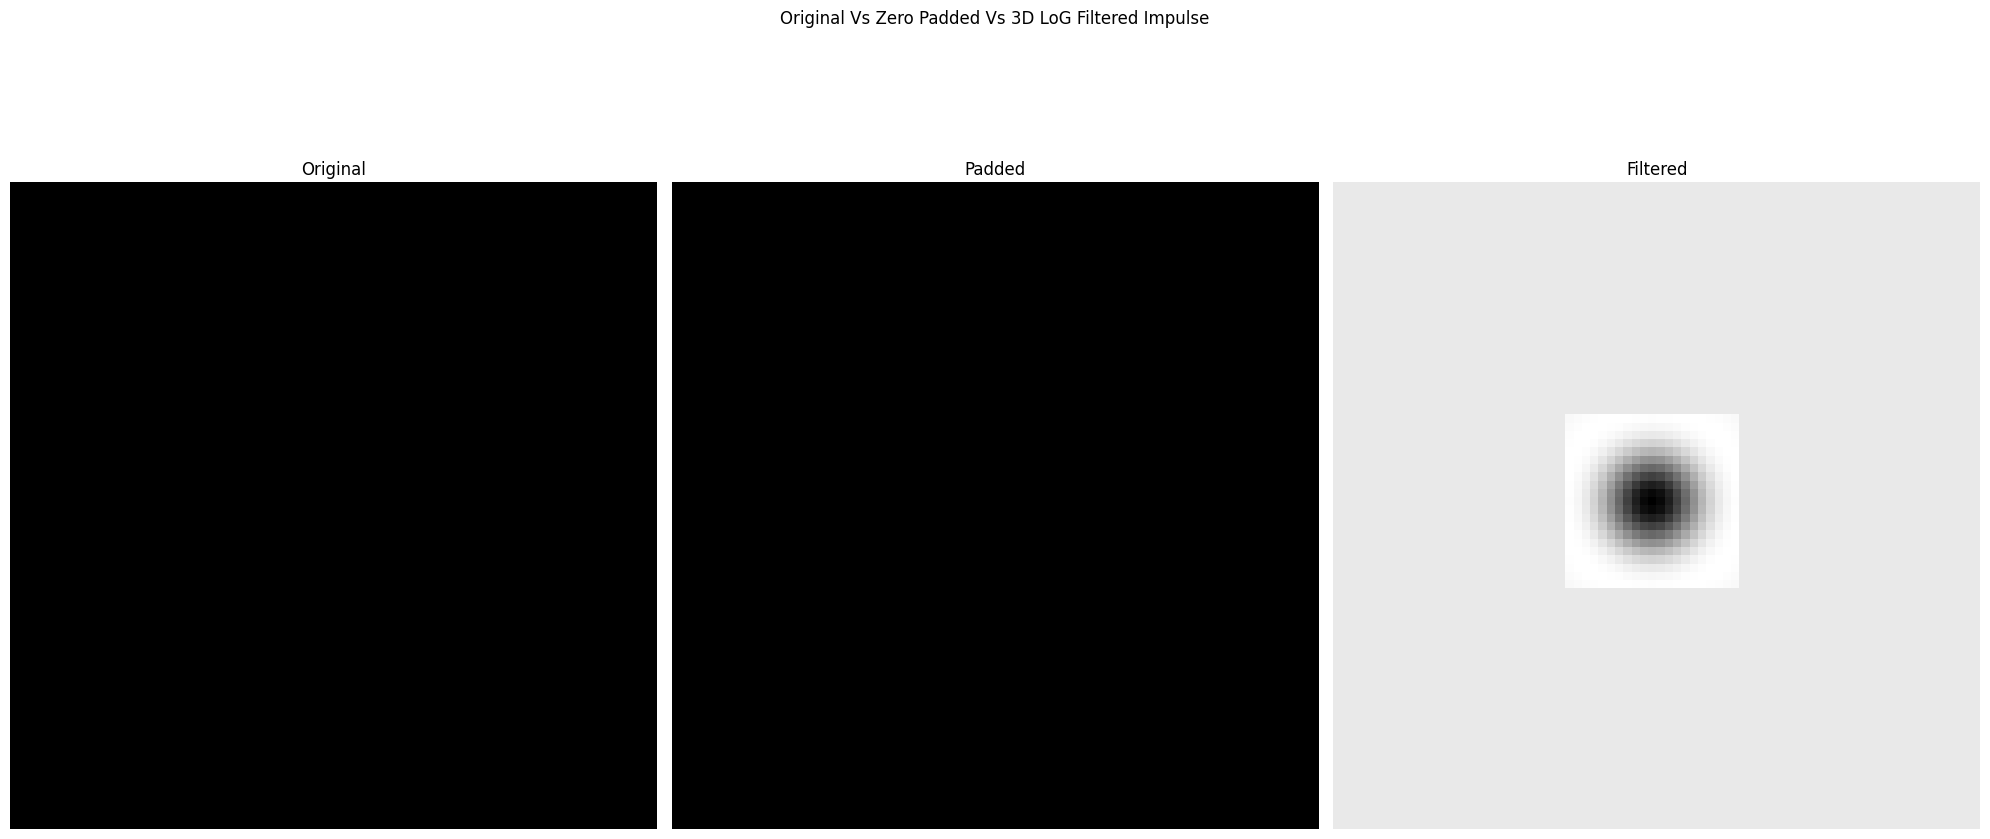

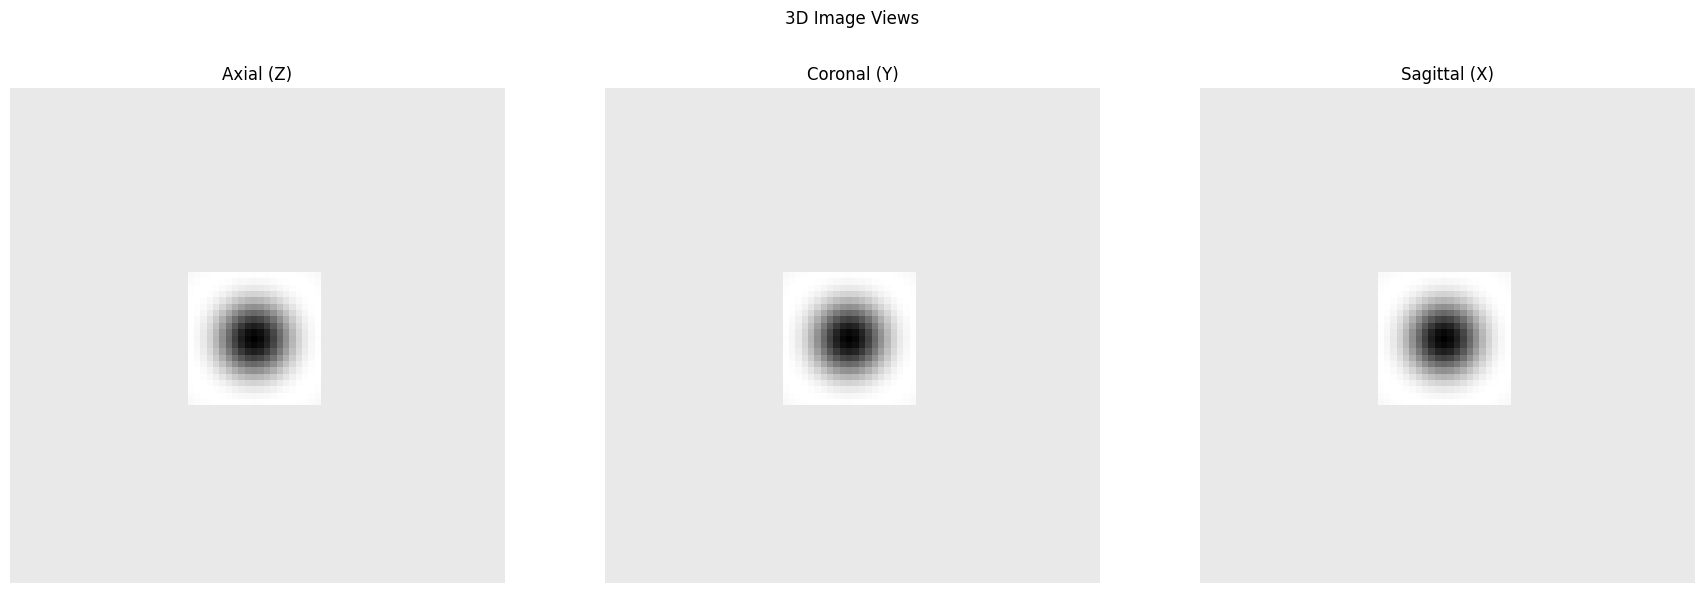

In [26]:
# 3D LoG filter on Zero Padded Impulse with sigma = 3.0 
filtered_3LIZ = log_filter(zero_pad_impulse, kernel_3d)

# Append
filtered_images.append(('3D_LoG_Zero_Impulse', filtered_3LIZ))

# Visualize
visualize_images_3D(impulse, zero_pad_impulse, filtered_3LIZ, 'Original Vs Zero Padded Vs 3D LoG Filtered Impulse')
visualize_3D_views(filtered_3LIZ)

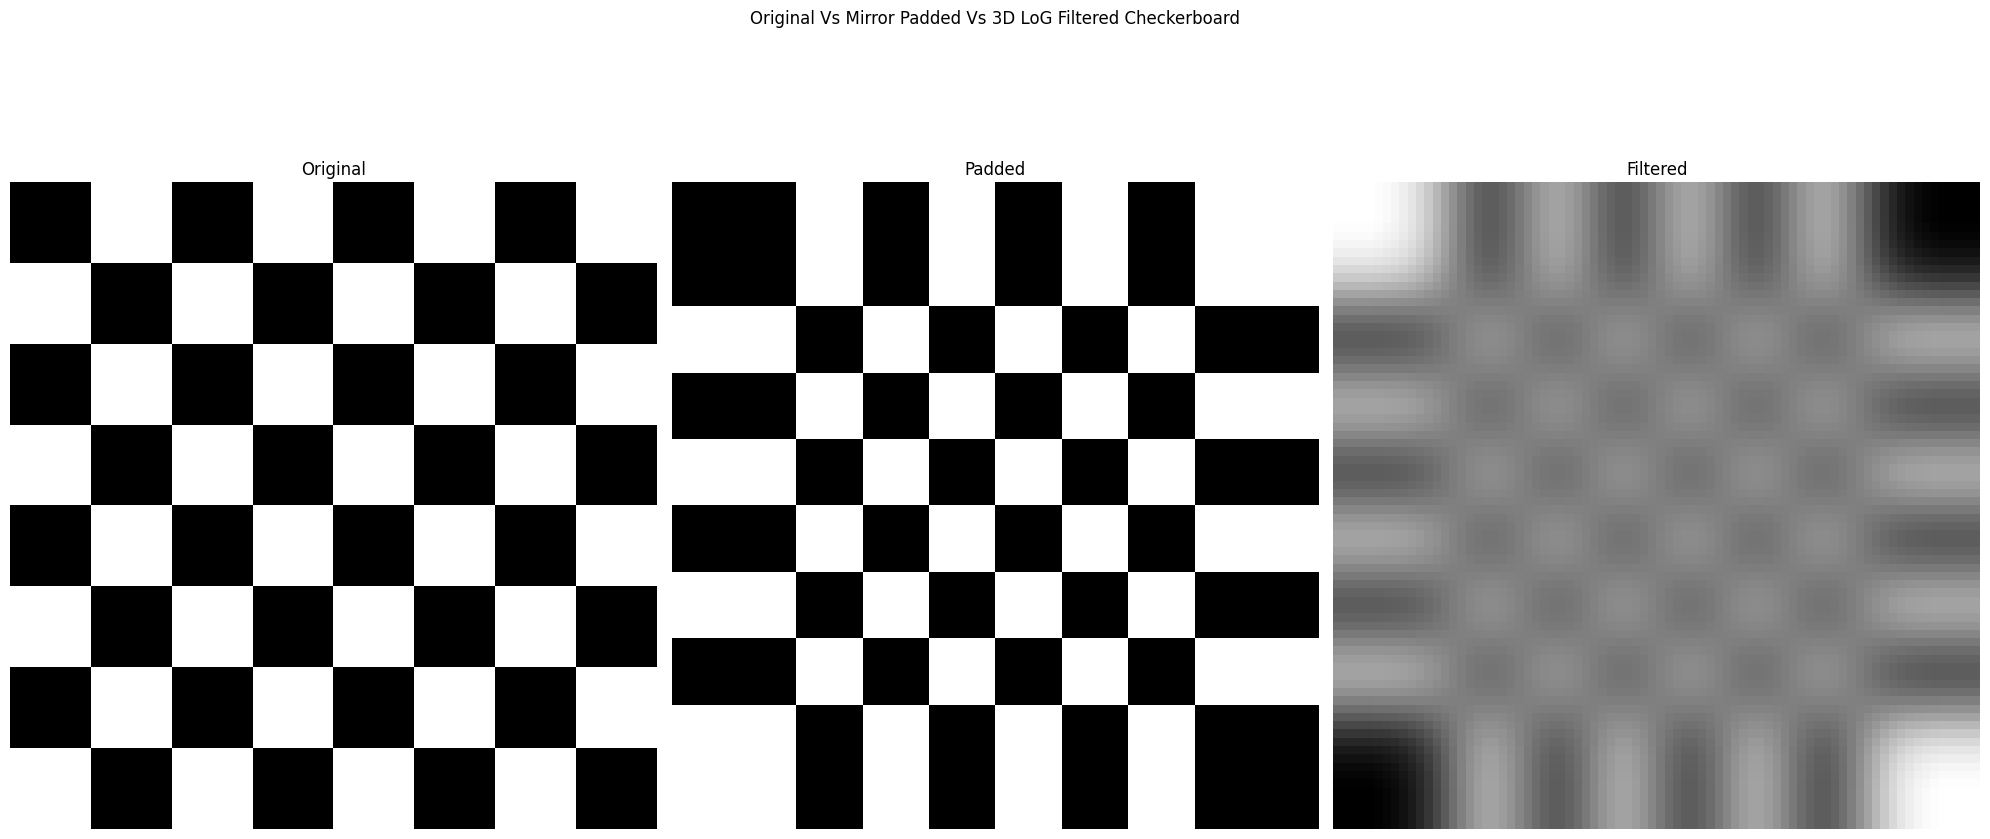

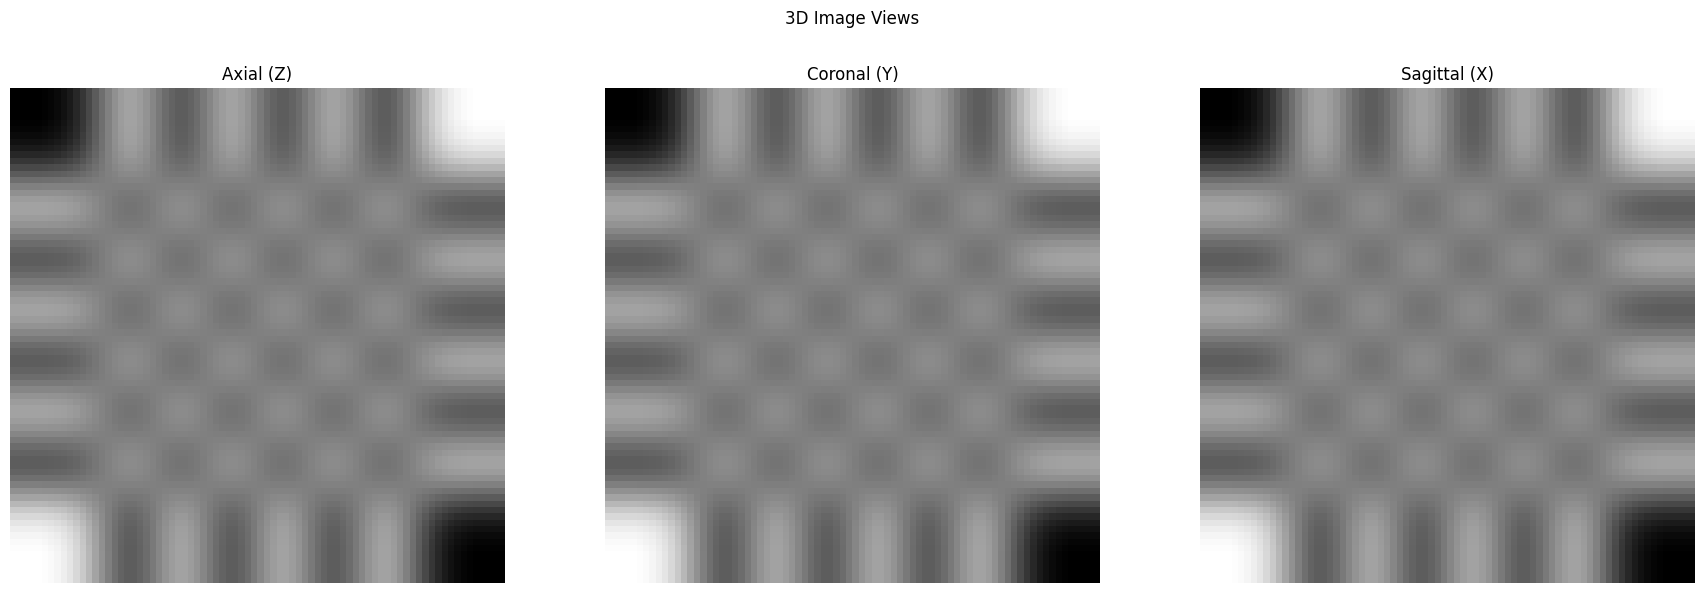

In [27]:
# 3D LoG filter on Mirror Padded Checkerboard with sigma = 5.0
filtered_3LCM = log_filter(mirror_pad_checkerboard, kernel_3d, pad_mode='reflect')

# Append
filtered_images.append(('3D_LoG_Mirror_Checkerboard', filtered_3LCM))

# Visualize
visualize_images_3D(checkerboard, mirror_pad_checkerboard, filtered_3LCM, 'Original Vs Mirror Padded Vs 3D LoG Filtered Checkerboard')
visualize_3D_views(filtered_3LCM)

#### 2D LoG

In [28]:
# 2D LoG filter on Mirror Padded Checkerboard with sigma = 5.0

# Middle index
idx = mirror_pad_checkerboard.shape[0]  // 2

# Slices
axial_checkerboard = mirror_pad_checkerboard[idx, :, :]
coronal_checkerboard = mirror_pad_checkerboard[:, idx, :]
sagittal_checkerboard = mirror_pad_checkerboard[:, :, idx]

# Filtered slices
# Axial Slice
filtered_2LAM = log_filter(axial_checkerboard, kernel_2d, pad_mode='reflect')

# Coronal Slice
filtered_2LCM = log_filter(coronal_checkerboard, kernel_2d, pad_mode='reflect')

# Sagittal Slice
filtered_2LSM = log_filter(sagittal_checkerboard, kernel_2d, pad_mode='reflect')

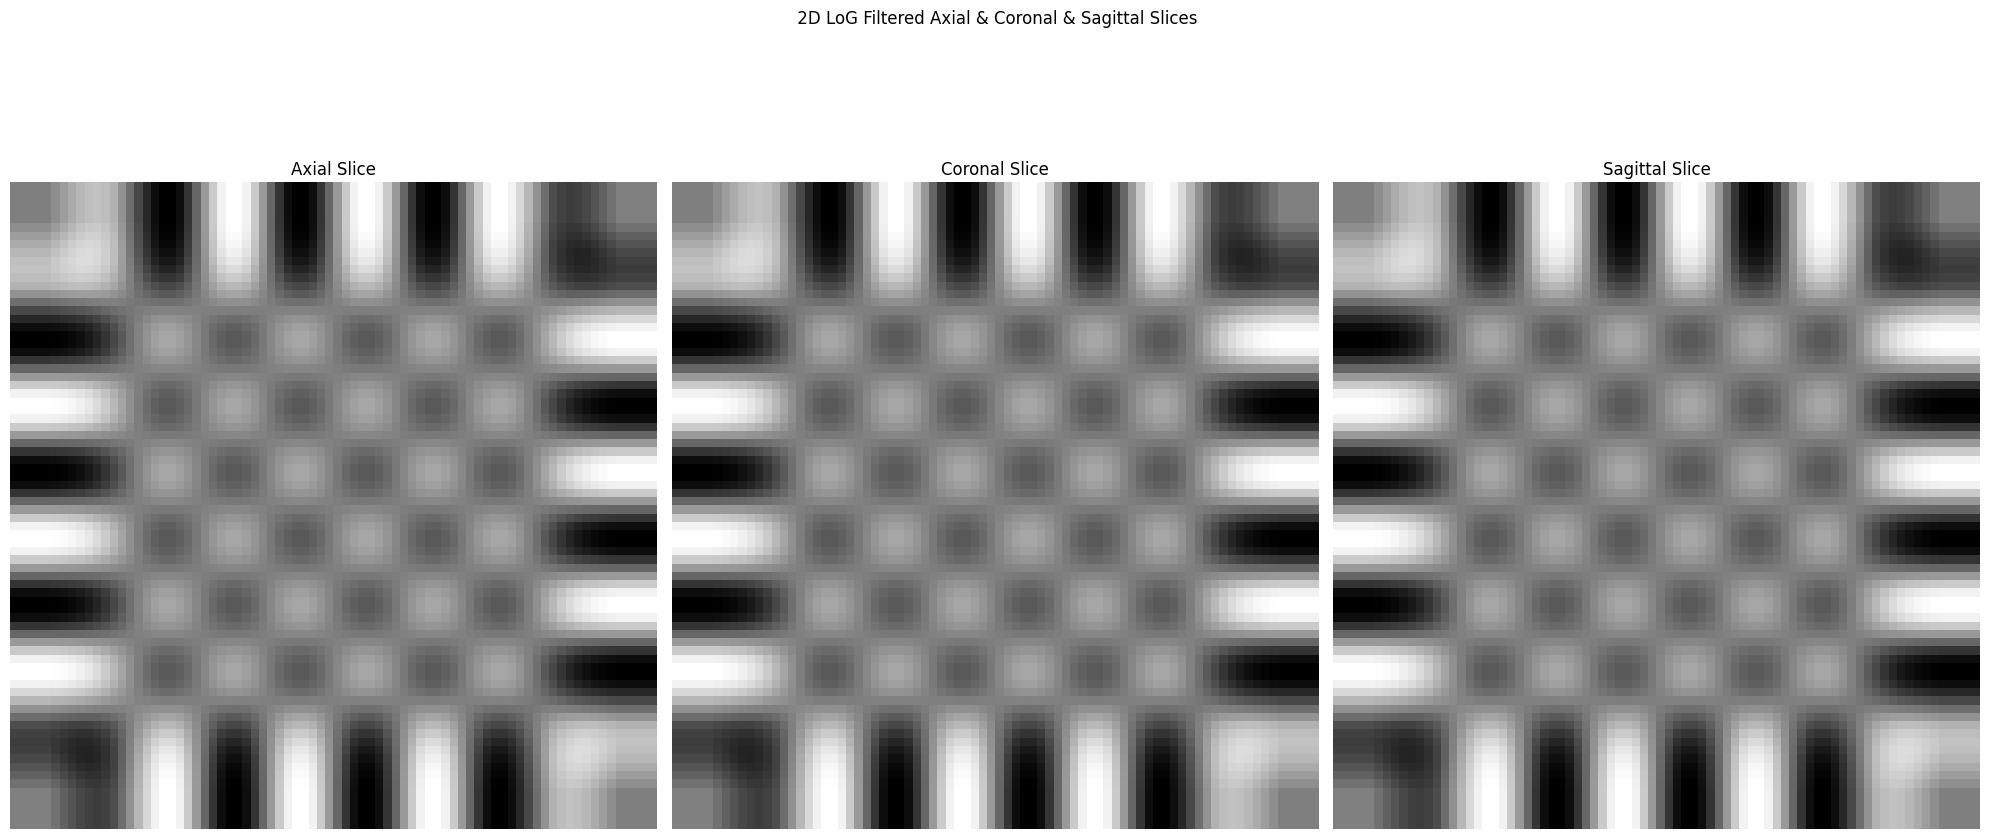

In [29]:
# Visualize
visualize_images_2D(filtered_2LAM, filtered_2LCM, filtered_2LSM, suptitle='LoG')

### Laws Kernels
* Used for Texture Classification.
* Convolves an image with a set of predefined kernels to extract energy features for different texture types.
* Each kernel is designed to capture a specific texture pattern in the image.

1. `Level(L5)`: Captures the overall intensity level in the image.
2. `Edge(E5)`: Detects edges, where there are rapid intensity transitions.
3. `Spot(S5)`: Detects localized variations in the image, such as small spots.
4. `Wave(W5)`: Captures sinusoidal-like wave patterns.
5. `Ripple(R5)`: Captures higher-frequency oscillations and can be seen as capturing more complex texture variations.

* Each 1D kernel can be combined with other kernels to form 2D Kernels.

#### Constructing 2D Laws' Kernels
By taking the outer product of the 1D kernels. 


#### Energy Maps
Once we apply the kernels to an image, we can compute the energy map.

In [30]:
# Define 1D Laws' Kernels
L5 = np.array([1, 4, 6, 4, 1]) # Level
E5 = np.array([-1, -2, 0, 2, 1]) # Edge
S5 = np.array([-1, 0, 2, 0, -1]) # Spot
W5 = np.array([-1, 2, 0, -2, 1]) # Wave
R5 = np.array([-1, -4, 6, -4, 1]) # Ripple

#### 2D Laws Kernel

In [31]:
def laws_kernel(image, kernel):
    '''
    Applies a single laws' Kernel to a 2D or 3D image.
    
    Args: 
        image (np.ndarray): Input 2D or 3D image.
        kernel (np.ndarray): 2D or 3D Laws' Kernel.
        padding_mode (str): Padding mode for convolution.
        cval (float): Value to fill pad if mode is 'constant'.
        
    Returns:
        filtered_image (np.ndarray): Image after applying convolution with the Laws' Kernel.  
    '''
    filtered_image = convolve(image, kernel)
    return filtered_image

In [32]:
# Create 2D L5S5 kernel
L5S5 = np.outer(L5, S5) # This will be a (5, 5) kernel
L5S5

array([[-1,  0,  2,  0, -1],
       [-4,  0,  8,  0, -4],
       [-6,  0, 12,  0, -6],
       [-4,  0,  8,  0, -4],
       [-1,  0,  2,  0, -1]])

In [33]:
# Mirror padded Slices
mirror_pad_axial_checkerboard = np.pad(axial_checkerboard, pad_size, mode='reflect')
mirror_pad_coronal_checkerboard = np.pad(coronal_checkerboard, pad_size, mode='reflect')
mirror_pad_sagittal_checkerboard = np.pad(sagittal_checkerboard, pad_size, mode='reflect')

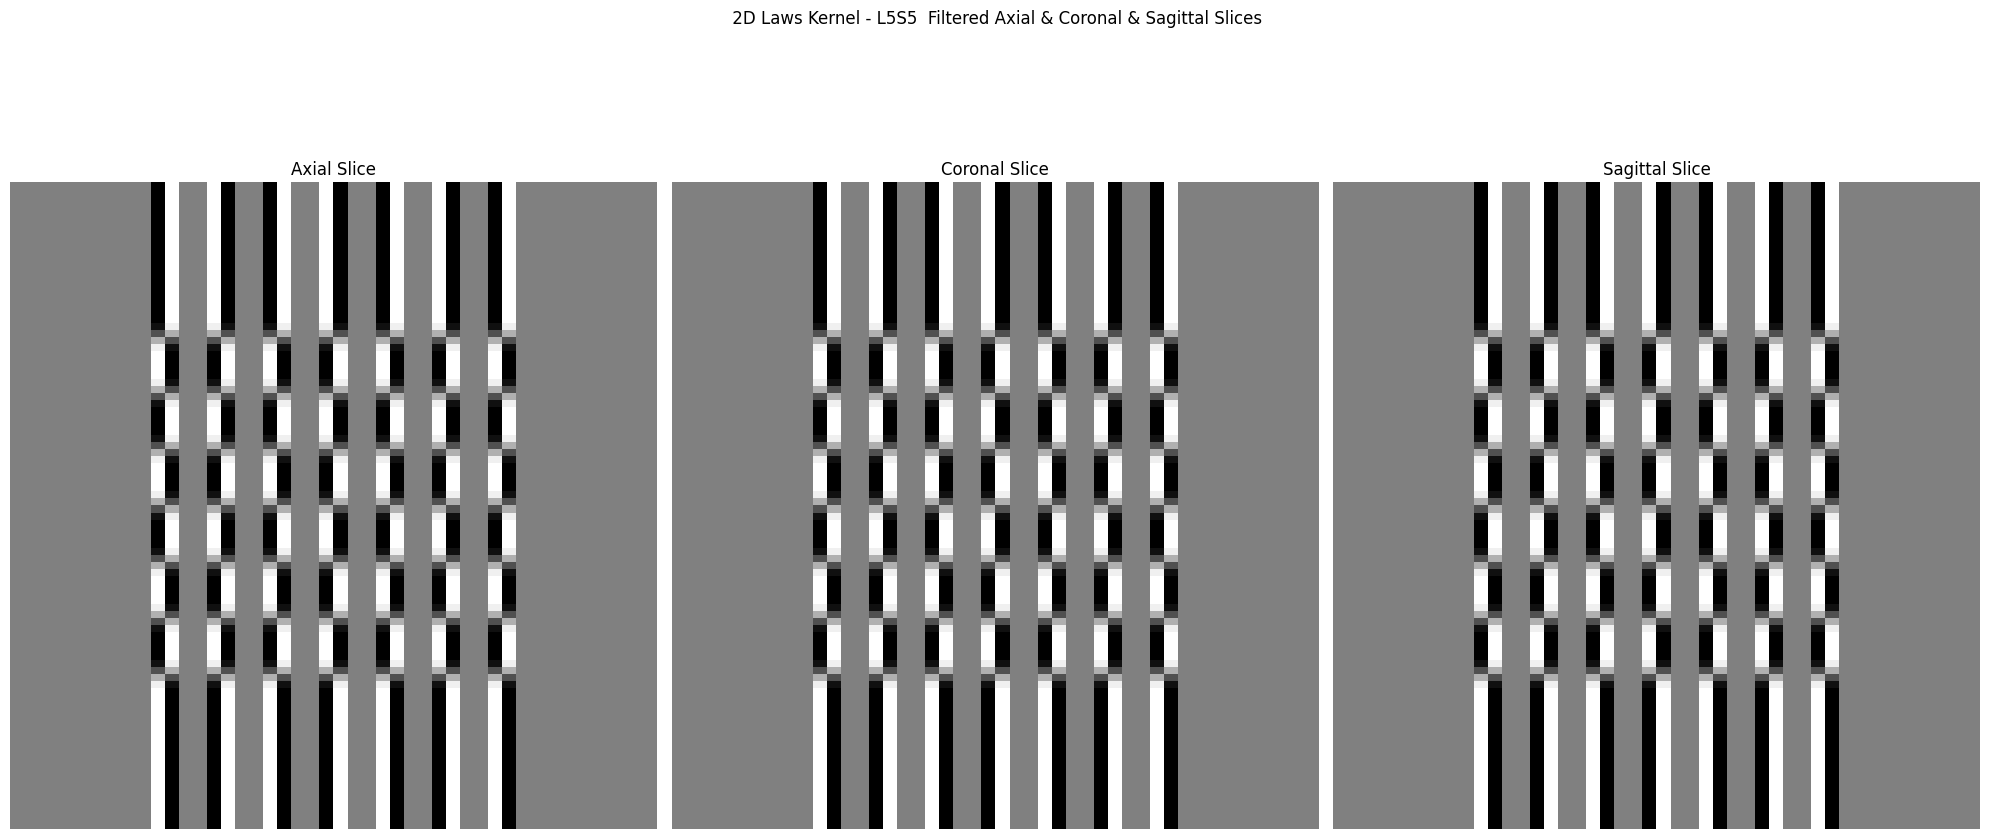

In [34]:
# Apply L5S5 filter to the slice
filtered_2LAM = laws_kernel(mirror_pad_axial_checkerboard, L5S5)
filtered_2LCM = laws_kernel(mirror_pad_coronal_checkerboard, L5S5)
filtered_2LSM = laws_kernel(mirror_pad_sagittal_checkerboard, L5S5)

# Visualize
visualize_images_2D(filtered_2LAM, filtered_2LCM, filtered_2LSM, 'Laws Kernel - L5S5 ')

To make the Laws' feature rotation-invariant with Max pooling:
* Take absolute value of filtered image
* Perform local max pooling


In [35]:
# Take absolute value
abs_filtered_2LAM = np.abs(filtered_2LAM)
abs_filtered_2LCM = np.abs(filtered_2LCM)
abs_filtered_2LSM = np.abs(filtered_2LSM)

In [36]:
from scipy.ndimage import maximum_filter

# Apply 3x3 max pooling
pooled_2LAM = maximum_filter(abs_filtered_2LAM, size=3)
pooled_2LCM = maximum_filter(abs_filtered_2LCM, size=3)
pooled_2LSM = maximum_filter(abs_filtered_2LSM, size=3)

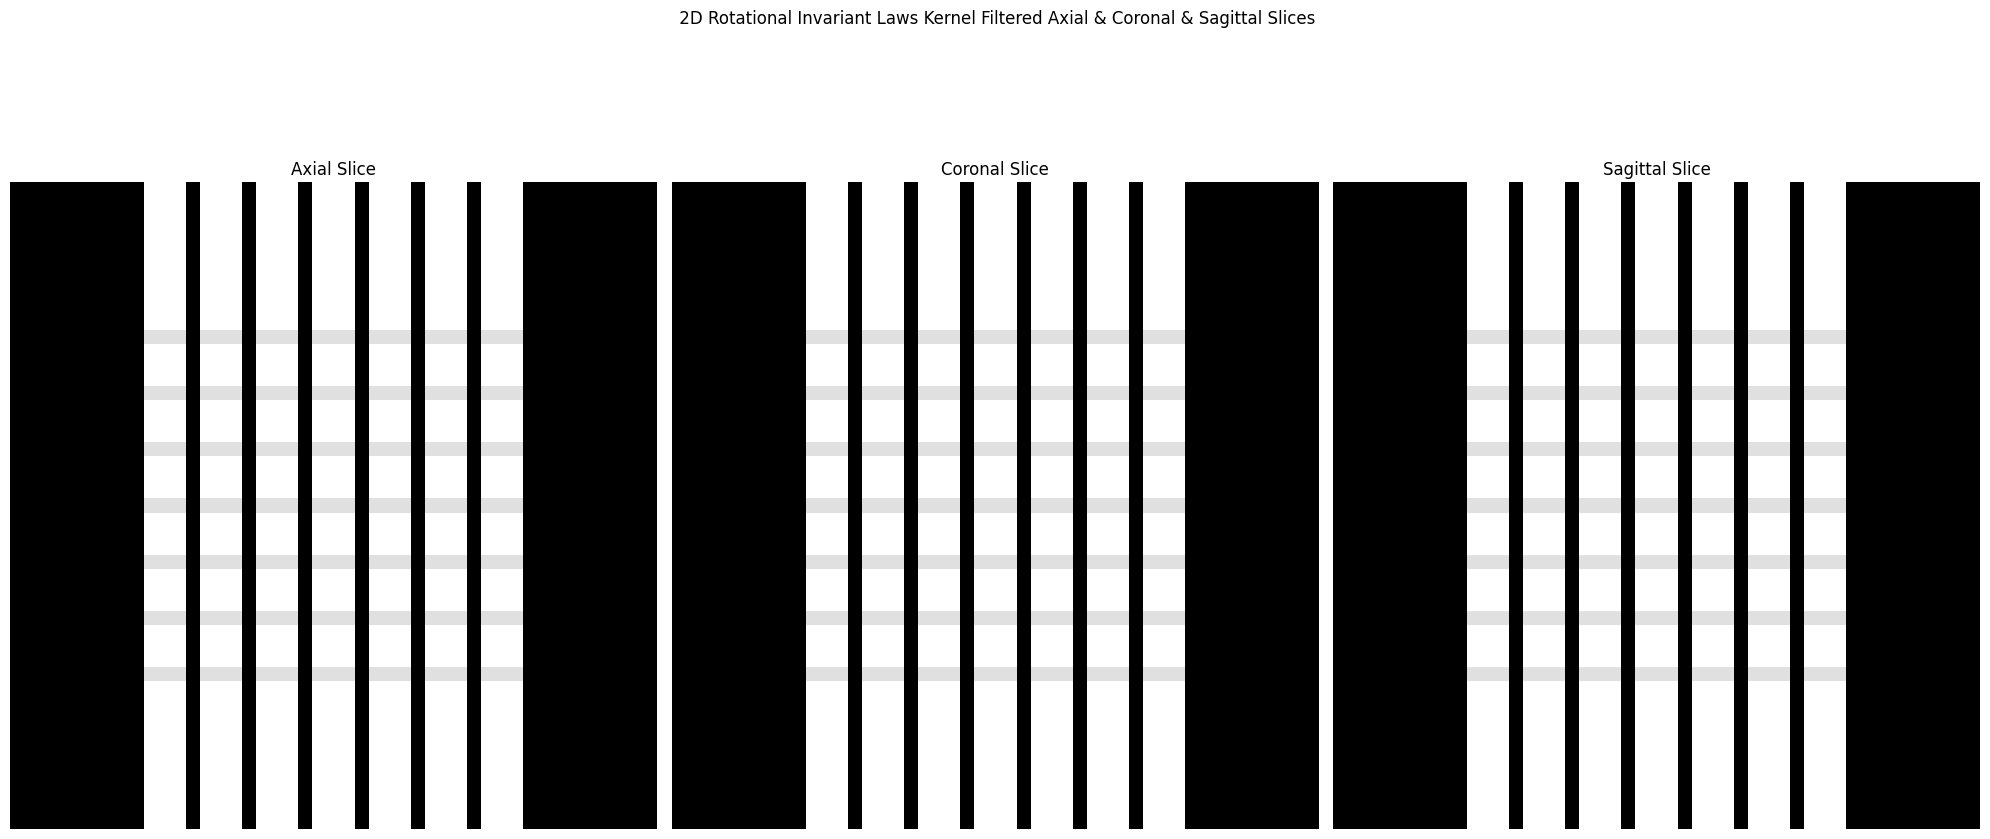

In [37]:
# Visualize
visualize_images_2D(pooled_2LAM, pooled_2LCM, pooled_2LSM, 'Rotational Invariant Laws Kernel')

`Energy map`: At every pixel (voxel), compute the local average energy in the neighbourhood.
`Distance = 7 voxels`: The size of the neighbourhood where you can calculate the energy is related to a radius of 7.
* Typically, this becomes a window size of 15x15 (2x7+1 = 15)
* Similar to smoothing the squared response with a uniform or Gaussian kernel of size 15x15

##### How to calculate Energy map
1. Filter the image using the Laws' Kernel
2. Take the absolute value (for rotation invariance)
3. Perform local max pooling
4. Square the filtered response
5. Apply a local averaging filter over a neighborhood of 15x15.

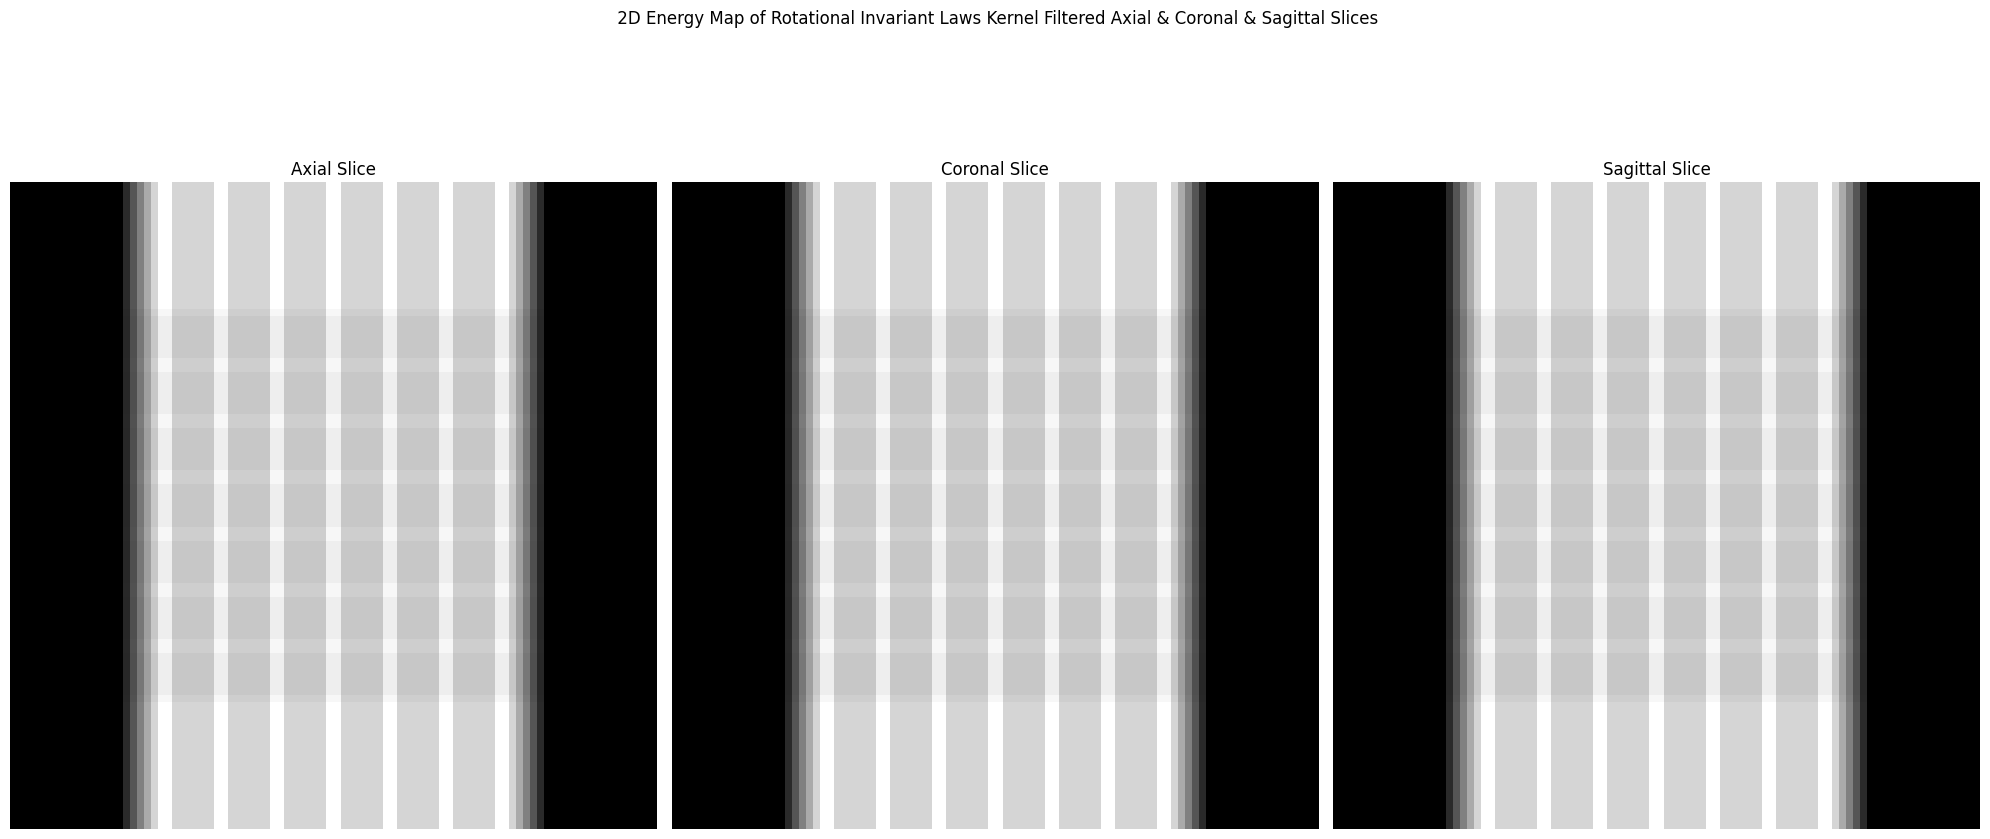

In [38]:
# Energy map computation

# Square the pooled output (energy)
squared_pooled_2LAM = pooled_2LAM ** 2
squared_pooled_2LCM = pooled_2LCM ** 2
squared_pooled_2LSM = pooled_2LSM ** 2

# Apply local averaging (distance = 7)
distance = 7
energy_map_2LAM = uniform_filter(squared_pooled_2LCM, size=distance)
energy_map_2LCM = uniform_filter(squared_pooled_2LCM, size=distance)
energy_map_2LSM = uniform_filter(squared_pooled_2LSM, size=distance)

# Visualize
visualize_images_2D(energy_map_2LAM, energy_map_2LCM, energy_map_2LSM, 'Energy Map of Rotational Invariant Laws Kernel')

#### 3D Laws Kernels

##### For 3D Kernels
`np.einsum`: For expressing operations like outer products, transpositions, summations.

For eg: `np.einsum('i,j,k -> ijk', E5, L5, S5)`

`i,j,k` tells `einsum` to treat each array as a separate axis.
`->ijk` tells it to form a 3D tensor where:
* E5 spans axis 0 (`i`)
* L5 spans axis 1 (`j`)
* S5 spans axis 2 (`k`)

So, 
`kernel_3D[i,j,k] = E5[i] * L5[j] * S5[k]`

In [39]:
# Construct the 3D Kernel E5L5S5
E5L5S5 = np.einsum('i,j,k->ijk', E5, L5, S5)

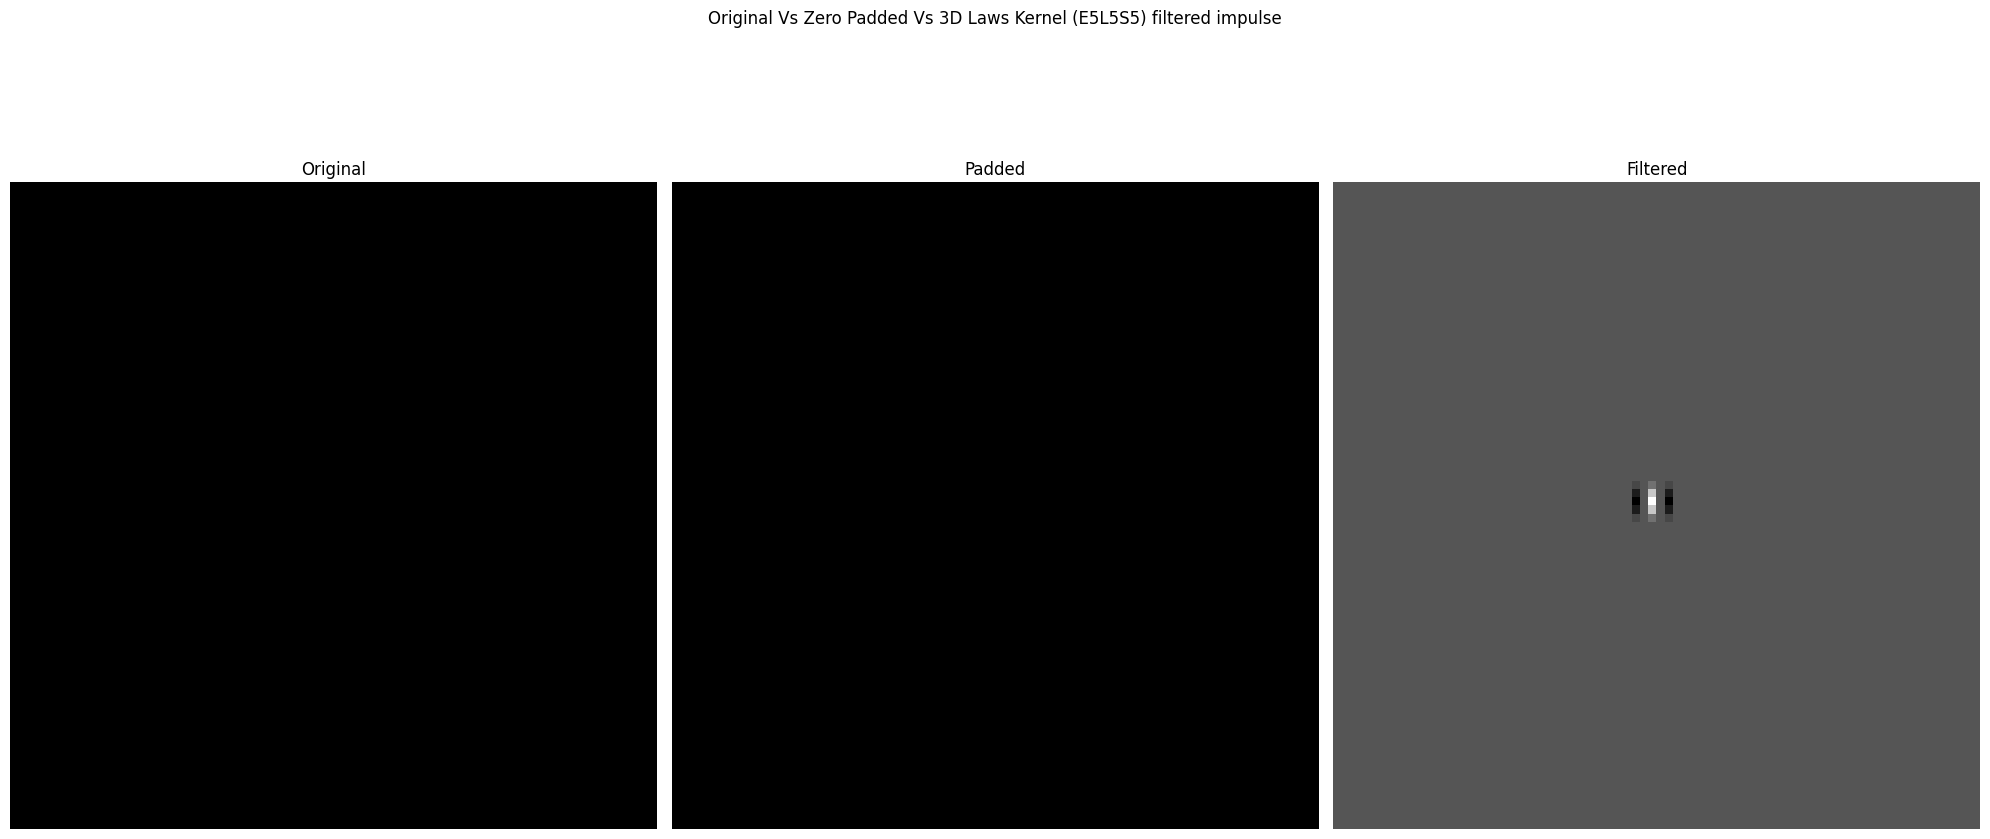

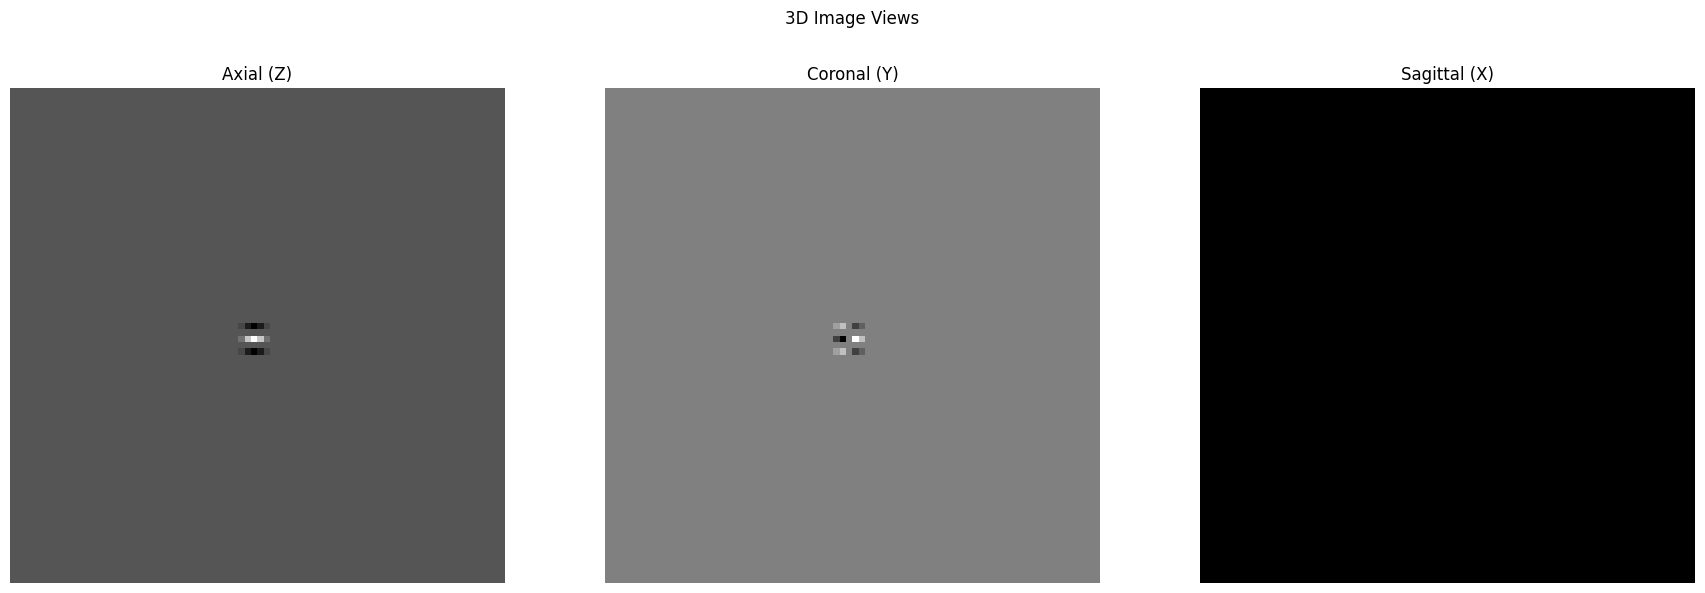

In [40]:
# Apply 3D kernel E5L5S5 on the zero padded impulse
filtered_3LZI = laws_kernel(zero_pad_impulse, E5L5S5)

# Append
filtered_images.append(('3D_Laws_Zero_Impulse', filtered_3LZI))

# Visualize
visualize_images_3D(impulse, zero_pad_impulse, filtered_3LZI, 'Original Vs Zero Padded Vs 3D Laws Kernel (E5L5S5) filtered impulse')
visualize_3D_views(filtered_3LZI)

In [41]:
# Take the absolute value of the filtered image
abs_3LZI = np.abs(filtered_3LZI)

In [42]:
# Apply 3x3 max pooling
pooled_3LZI = maximum_filter(abs_3LZI, size=3)

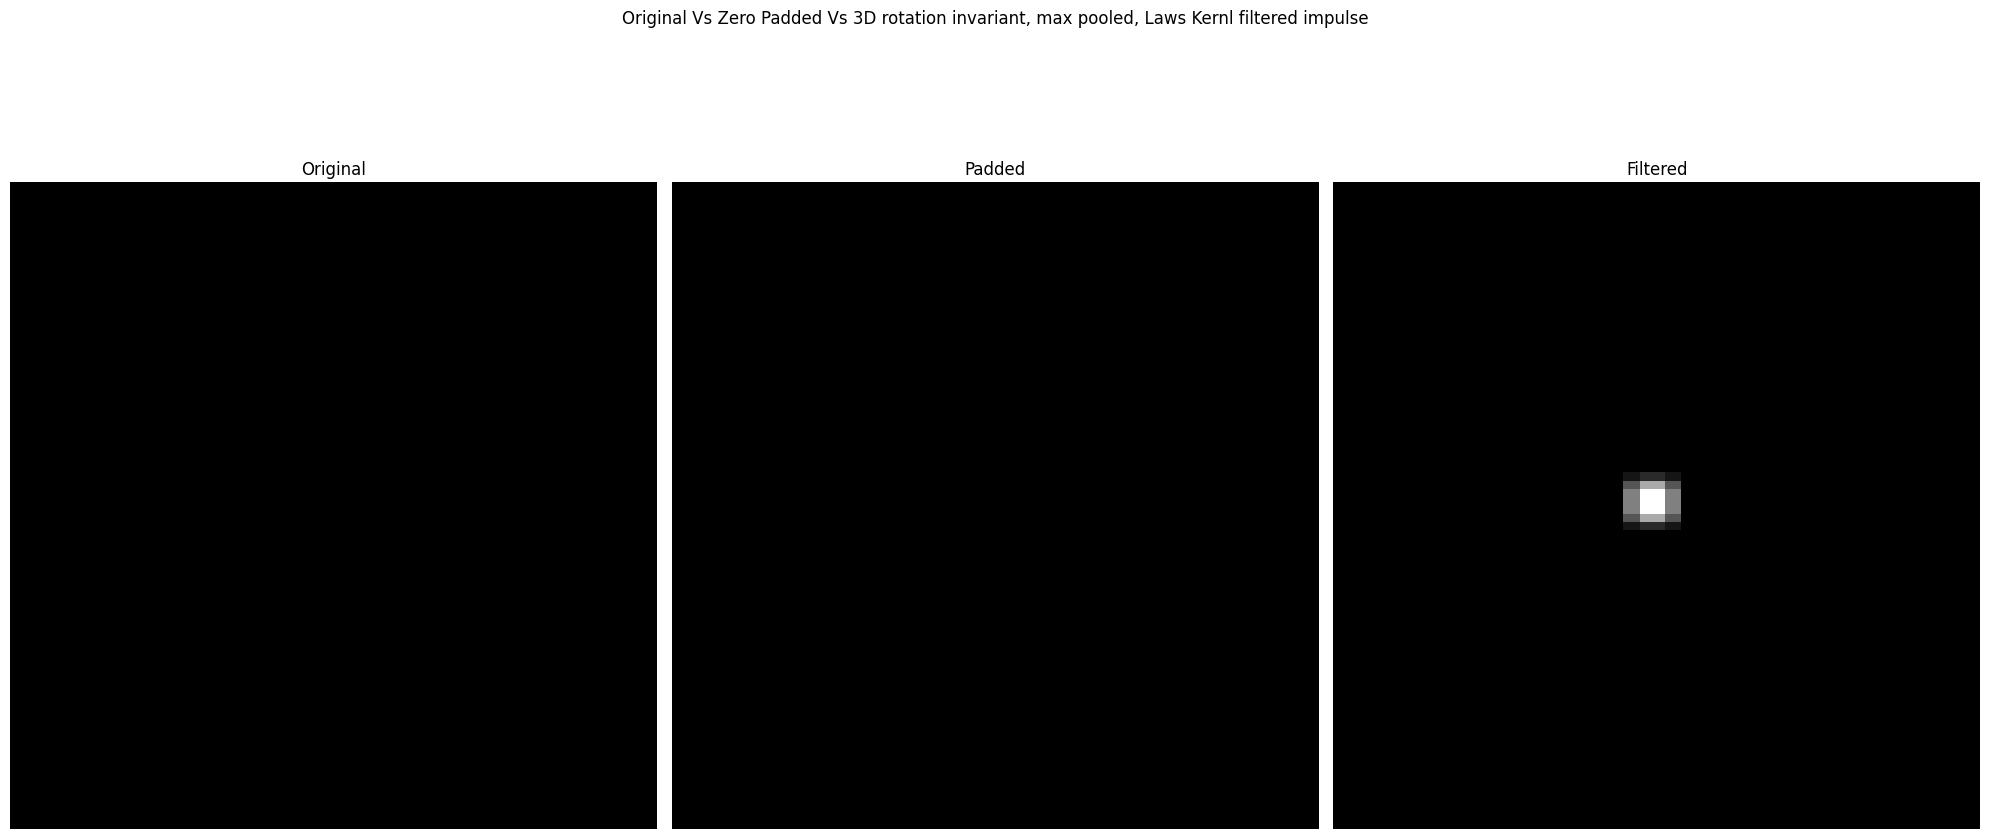

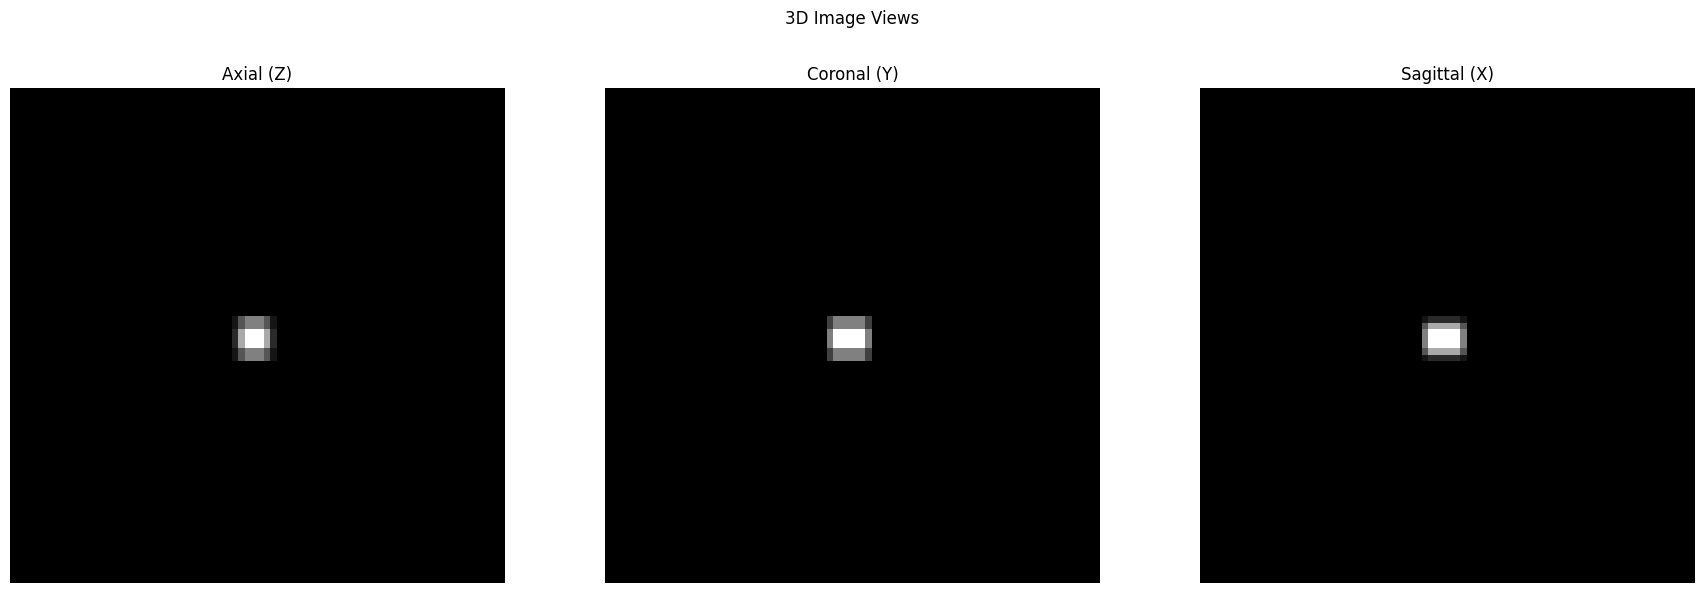

In [43]:
# Append
filtered_images.append(('3D_Laws_Pooled_Zero_Impulse', pooled_3LZI))

# Visualize the 3D rotation invariant, max pooled, Laws kernel filtered impulse
visualize_images_3D(impulse, zero_pad_impulse, pooled_3LZI, 'Original Vs Zero Padded Vs 3D rotation invariant, max pooled, Laws Kernl filtered impulse')
visualize_3D_views(pooled_3LZI)

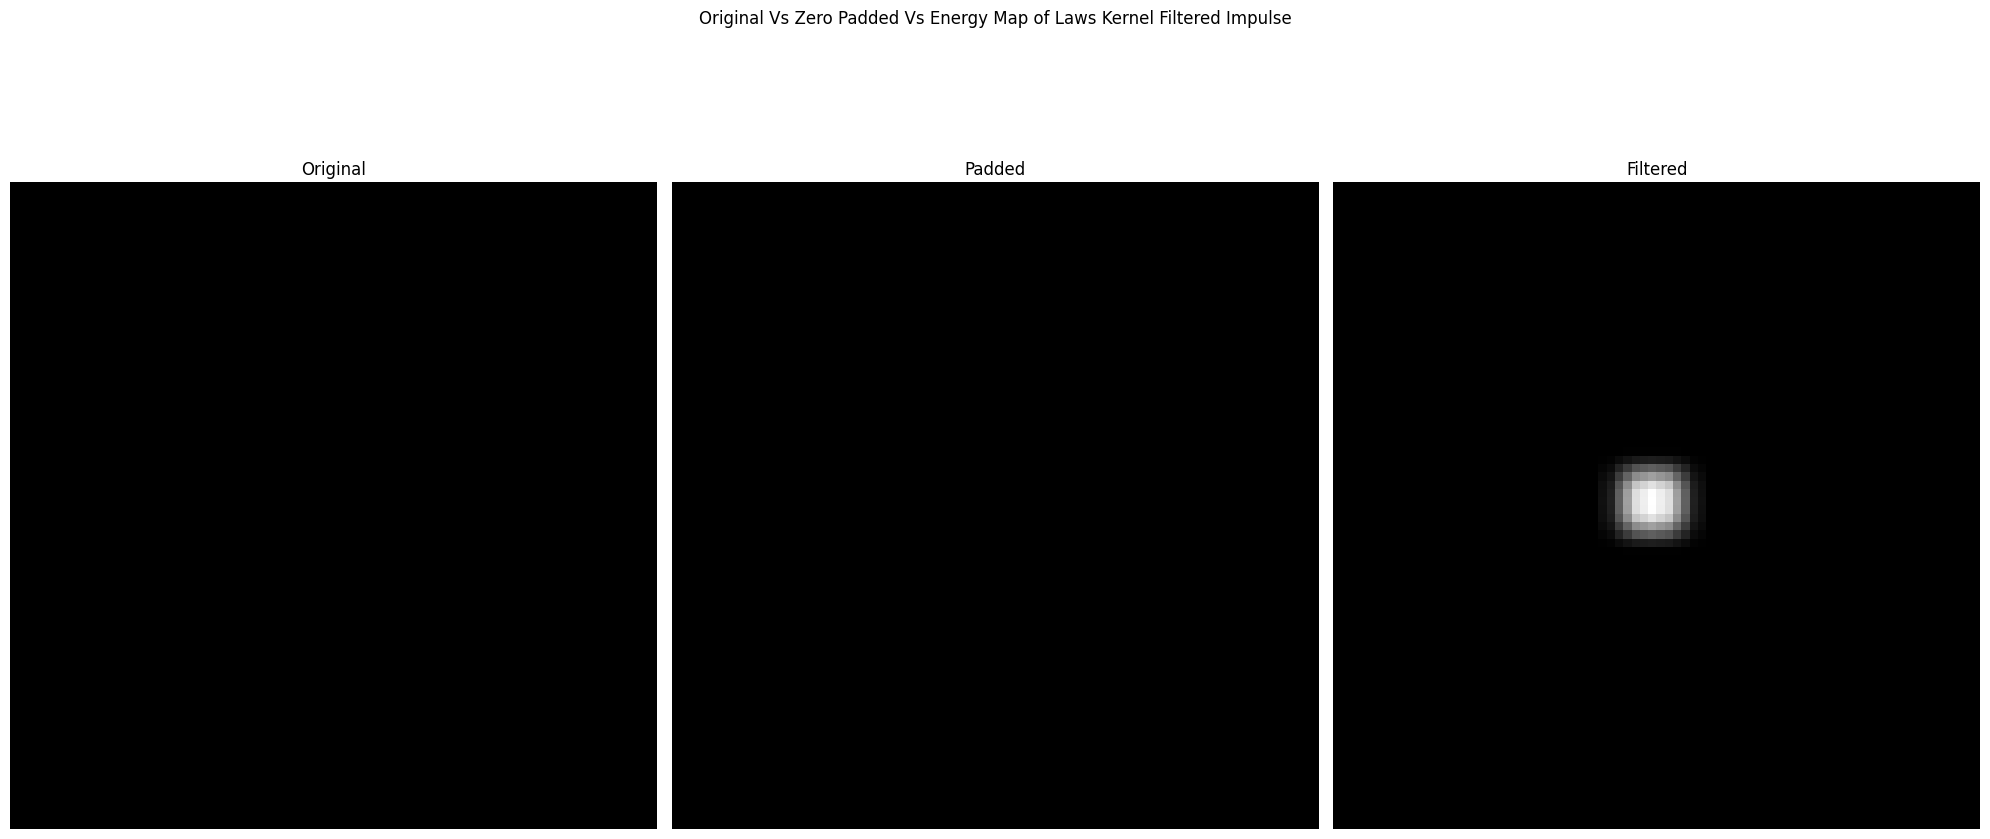

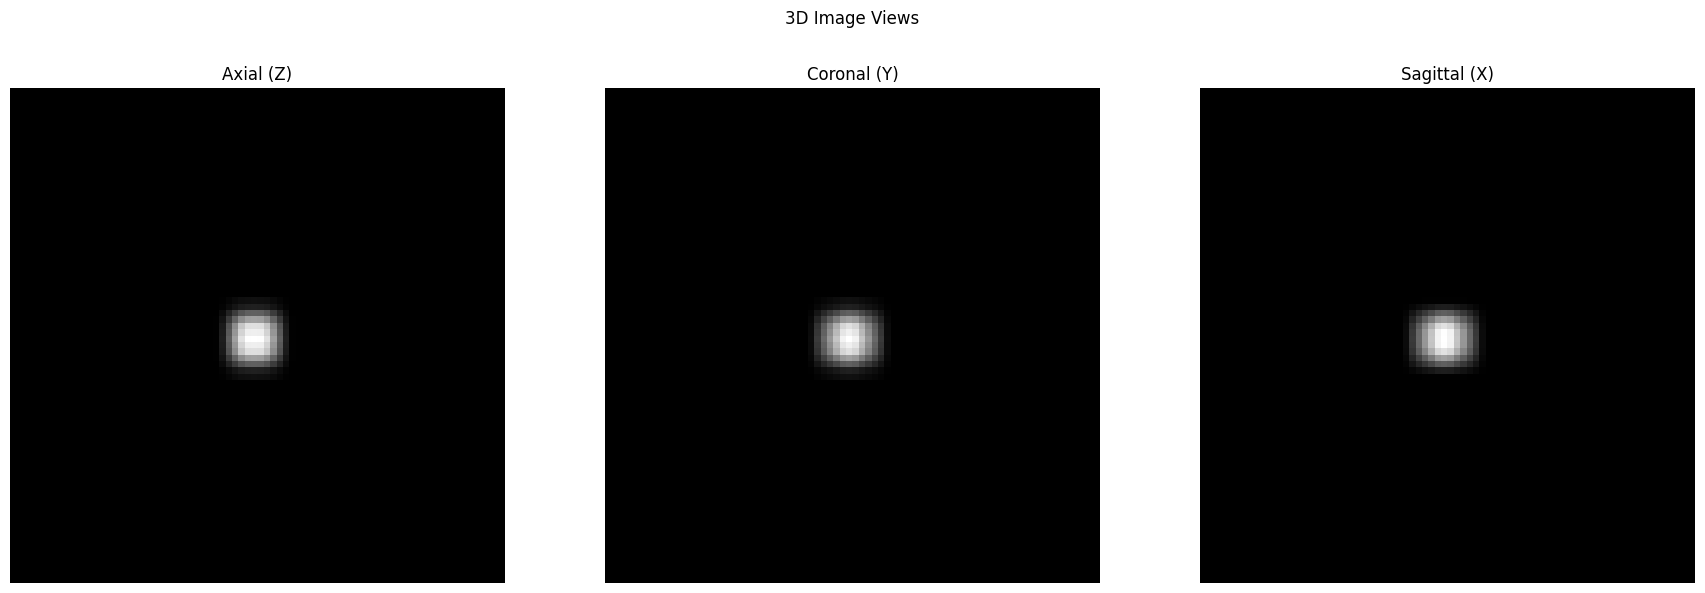

In [44]:
# Energy map computation

# Square the pooled image
squared_pooled_3LZI = pooled_3LZI ** 2

# Apply local averaging 
distance = 7
energy_map_3LZI = uniform_filter(squared_pooled_3LZI, size=distance)

# Append
filtered_images.append(('3D_Laws_Energy_Map_Impulse', filtered_3LZI))

# Visualize
visualize_images_3D(impulse, zero_pad_impulse, energy_map_3LZI, 'Original Vs Zero Padded Vs Energy Map of Laws Kernel Filtered Impulse')
visualize_3D_views(energy_map_3LZI)

In [45]:
# 3D Laws Kernel Filter (E3W5R5) on Mirror padded Checkerboard

E3 = [-1, 0, 1]

# Construct the 3D kernel
E3W5R5 = np.einsum('i,j,k->ijk', E3, W5, R5)

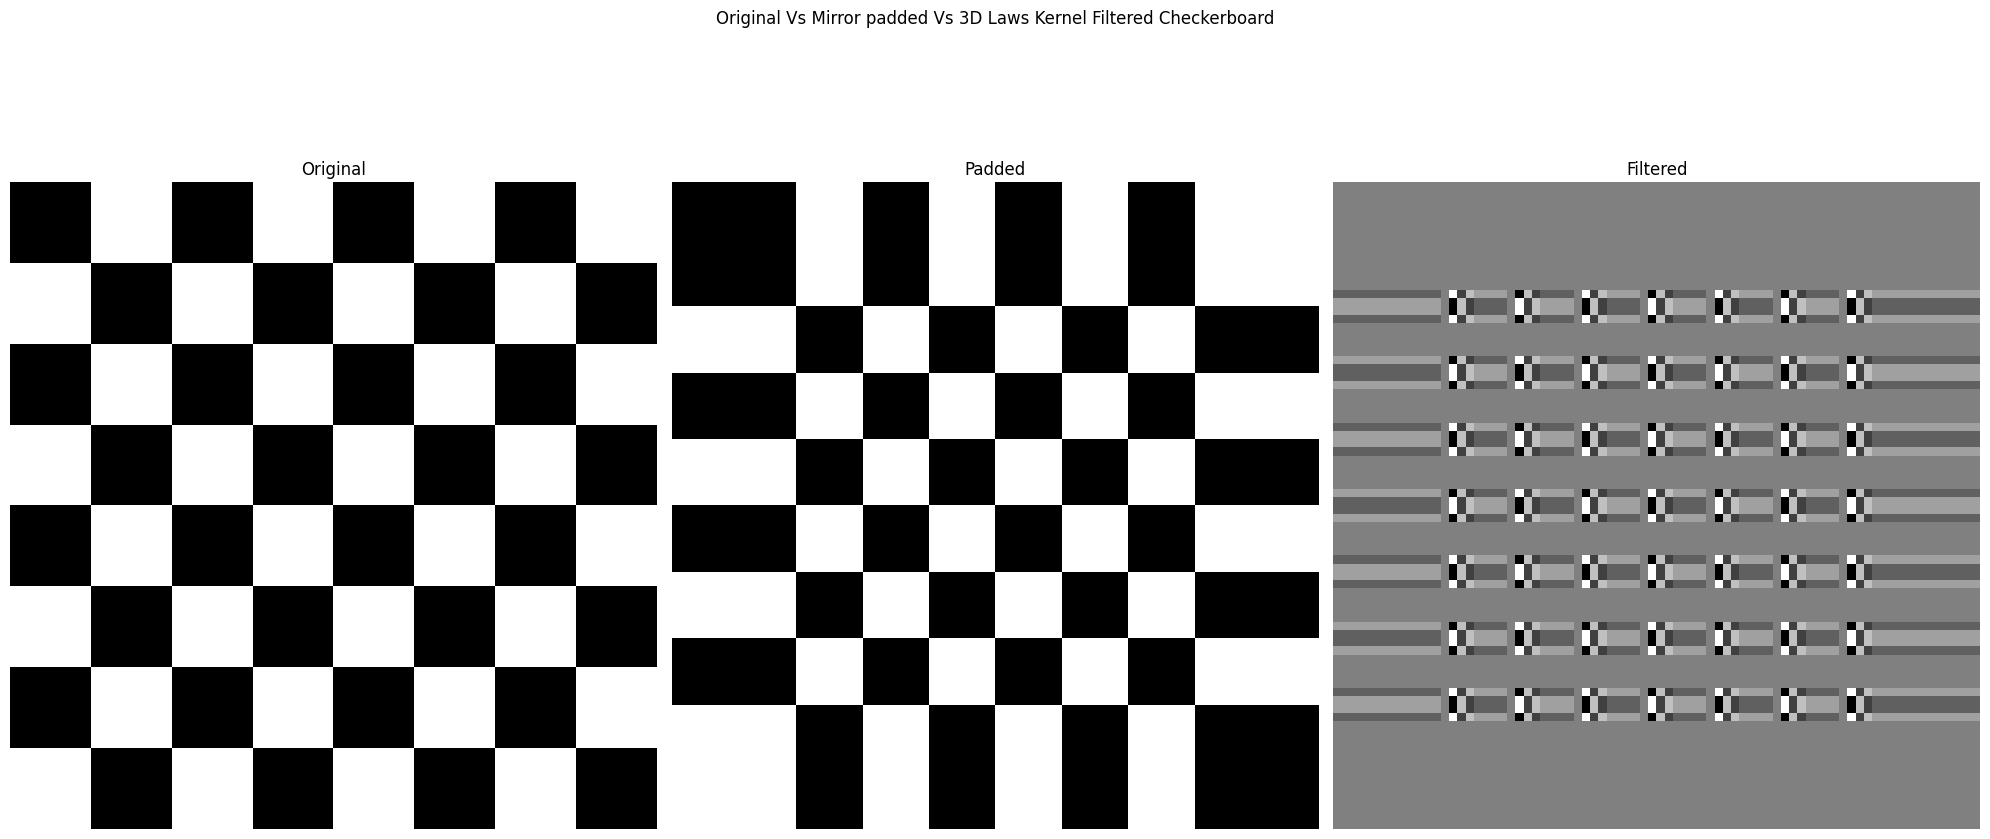

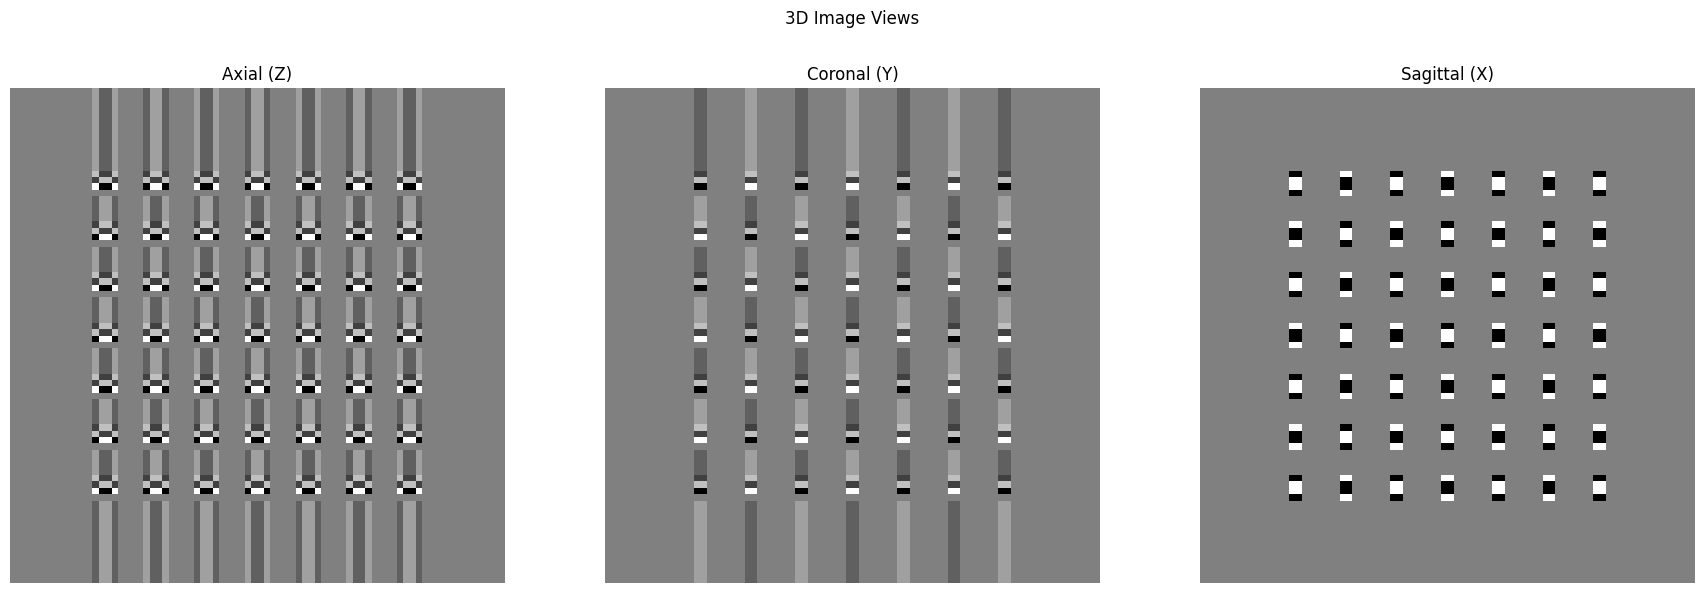

In [46]:
# Apply 3D Laws Kernel filter
filtered_3LMC = laws_kernel(mirror_pad_checkerboard, E3W5R5)

# Append
filtered_images.append(('3D_Laws_Mirror_Checkerboard', filtered_3LMC))

# Visualize 
visualize_images_3D(checkerboard, mirror_pad_checkerboard, filtered_3LMC, 'Original Vs Mirror padded Vs 3D Laws Kernel Filtered Checkerboard')
visualize_3D_views(filtered_3LMC)

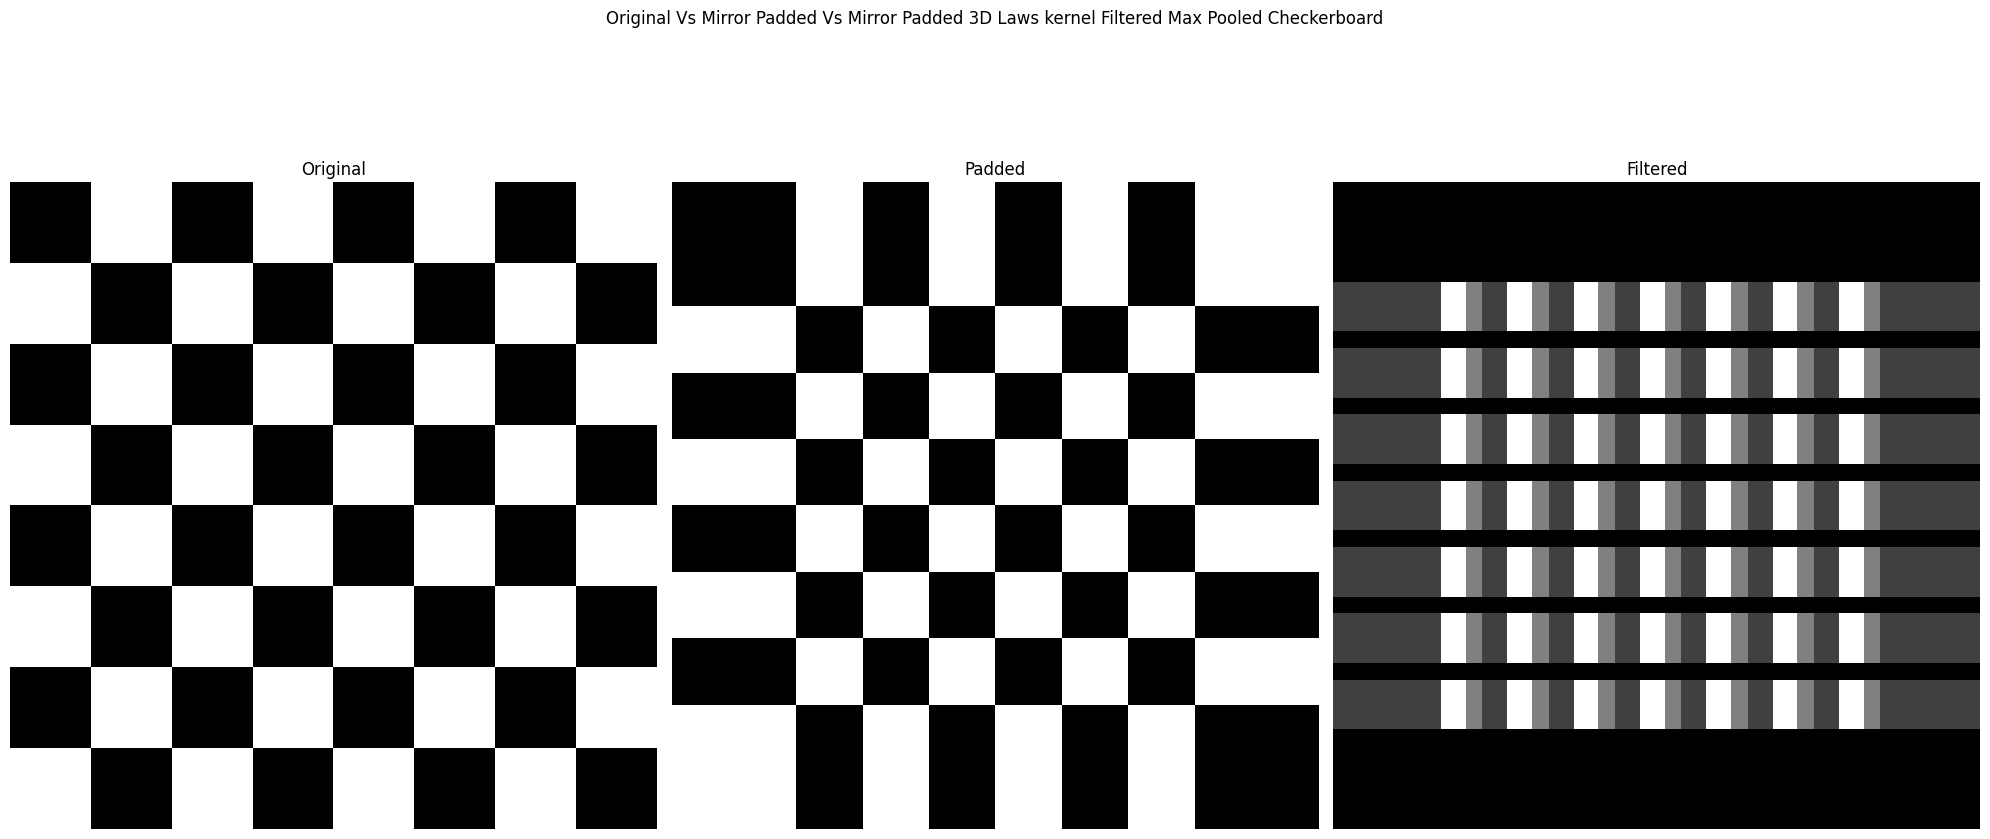

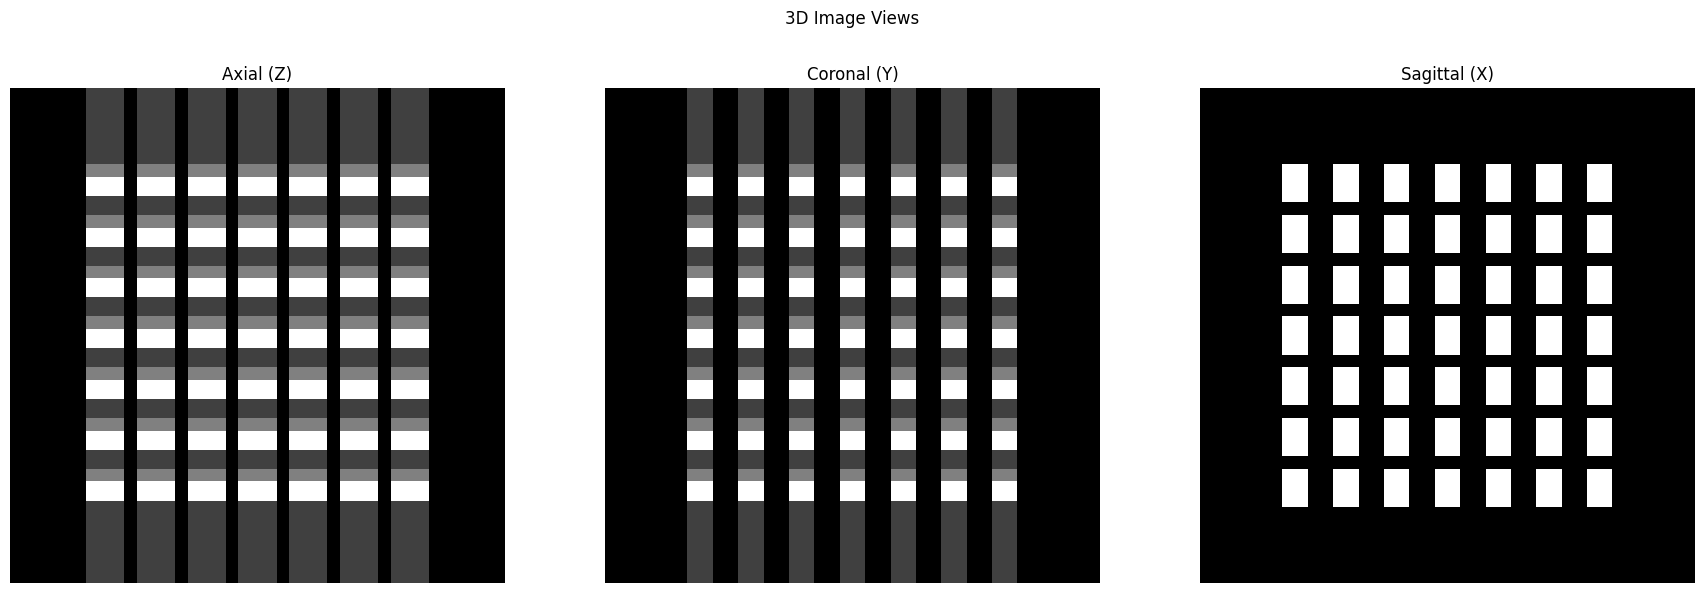

In [47]:
# 3D rotation invariance, max pooling

# Take the absolute value of the filtered image
abs_3LMC = np.abs(filtered_3LMC)

# Apply Max pooling to the absolute value
pooled_3LMC = maximum_filter(abs_3LMC, size=3)

# Append
filtered_images.append(('3D_Laws_Pooled_Checkerbaord', pooled_3LMC))

# Visualize
visualize_images_3D(checkerboard, mirror_pad_checkerboard, pooled_3LMC, 'Original Vs Mirror Padded Vs Mirror Padded 3D Laws kernel Filtered Max Pooled Checkerboard')
visualize_3D_views(pooled_3LMC)

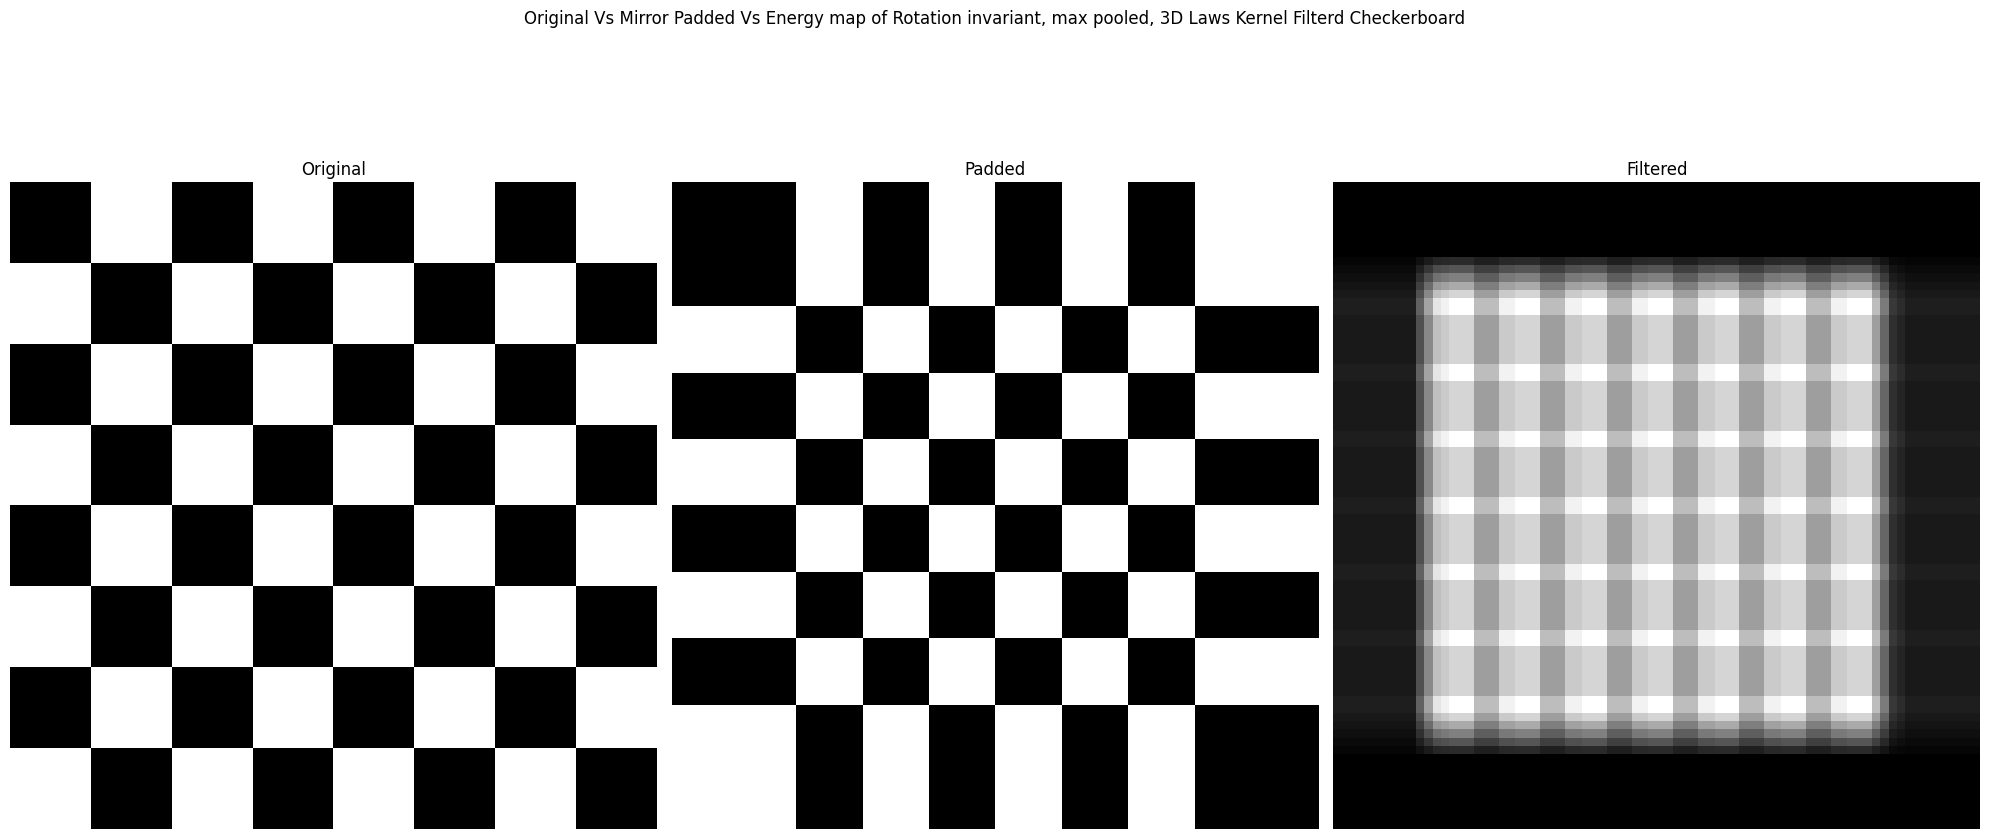

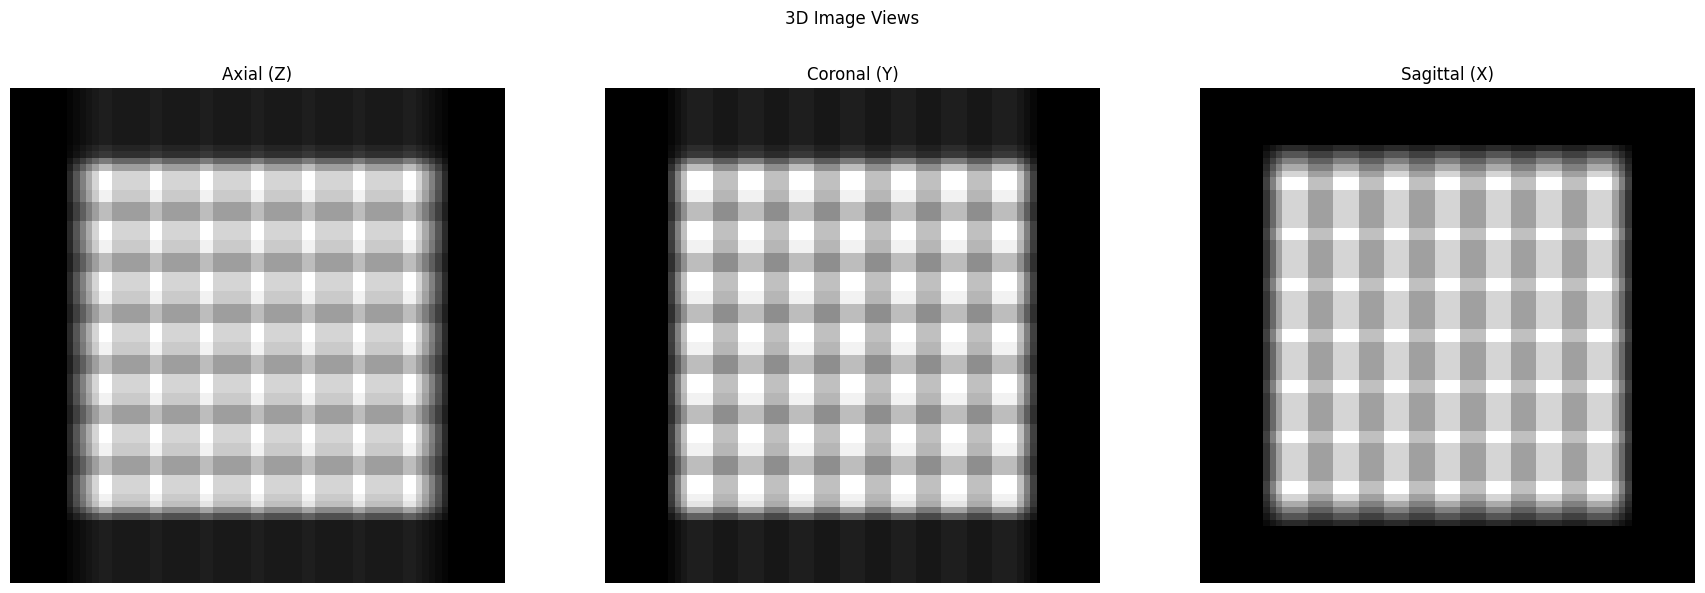

In [48]:
# Energy map computation

# Square the pooled image
squared_pooled_3LMC = pooled_3LMC ** 2

# Apply local averaging
distance = 7
energy_map_3LMC = uniform_filter(squared_pooled_3LMC, size=distance)

# Append
filtered_images.append(('3D_Laws_Energy_Map_Checkerboard', filtered_3LMC))

# Visualize
visualize_images_3D(checkerboard, mirror_pad_checkerboard, energy_map_3LMC, 'Original Vs Mirror Padded Vs Energy map of Rotation invariant, max pooled, 3D Laws Kernel Filterd Checkerboard') 
visualize_3D_views(energy_map_3LMC)

### Gabor Filter

**What is a Gabor filter?**

A Gabor filter is like a ***magnifying glass*** that looks for ***specific patterns*** — especially textures, edges, or repeating structures — in a ***small area*** of an image.

**What does it do?**

It answers:

* Is there a pattern in this part of the image?

* Is it in a specific direction?

* Is it at a specific thickness or spacing?

**How does it work?**

A Gabor filter is made of two parts:

* A **wavy** pattern — like ripples or stripes (this part finds edges or lines going a certain direction).

* A **blur** — like looking through a fuzzy circle (this keeps it focused on just a small region).

If the pattern in the image matches your filter, you get a strong response.

**Why use different filters?**

Because not all patterns are the same! You change:

1. `Direction (θ)` — to catch lines going left-right, up-down, diagonally.

2. `Frequency (λ)` — to catch thick or thin lines.

3. `Size (σ)` — to zoom in on small details or see bigger patterns.

So, we create a bunch of Gabor filters with different settings — this is called a **Gabor filter bank.**

The Gabor filter is defined as $g(x, y) = \exp\left(-\frac{x'^2 + \gamma^2 y'^2}{2\sigma^2}\right) \cos\left(2\pi \frac{x'}{\lambda} + \psi\right)$.

where:

$ x' = x cos\theta + y sin\theta$

$ y' = -xsin\theta + ycos\theta$



**Parameters:**
`λ` (Lambda): Wavelength of sinusoidal wave (controls ***frequency***).

`θ` (Theta): **Orientation** of the Gabor function (e.g., ***0°, 45°***, etc.).

`ψ` (Psi): **Phase offset** of the sinusoid.

`σ` (Sigma): **Standard deviation** of the Gaussian (controls ***width***).

`γ` (Gamma): Spatial **aspect ratio** (controls ***ellipticity*** of the Gaussian).




In [49]:
# Gabor Filter

def gabor_filter(sigma, theta, Lambda, psi, gamma):
    '''
    Constructs a 2D Gabor filter.
    
    Parameters:
        sigma: Standard deviation of Gaussian envelope.
        theta: Orientation in radians.
        Lambda: Wavelength of the sinusoidal factor.
        psi: Phase offset.
        gamma: Aspect ratio of the Gaussian.
    '''
    # Compute the filter size

    # These define the Gaussian size
    sigma_x = sigma
    sigma_y = sigma / gamma

    nstds = 3 # 3 std deviations
    xmax = np.ceil(max(1, nstds * sigma_x * np.cos(theta), nstds * sigma_y * np.sin(theta)))
    ymax = np.ceil(max(1, nstds * sigma_x * np.sin(theta), nstds * sigma_y * np.cos(theta)))
    xmin = -xmax
    ymin = -ymax

    # This gives the coordinates to compute values over
    (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))

    # Rotate the coordinates so the filter aligns with the desired orientation theta
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    # Real part of the Gabor filter
    gb = np.exp(-0.5 * ((x_theta ** 2) / sigma_x ** 2 + (y_theta ** 2) / sigma_y ** 2)) \
         * np.cos(2 * np.pi * x_theta / Lambda + psi)

    # Imaginary part
    gb_im = np.exp(-0.5 * ((x_theta ** 2) / sigma_x ** 2 + (y_theta ** 2) / sigma_y ** 2)) \
            * np.sin(2 * np.pi * x_theta / Lambda + psi)
    
    return gb, gb_im

In [50]:
# Set the Parameter values
sigma = 10
theta = np.pi/3
Lambda = 4
psi = 0
gamma = 0.5

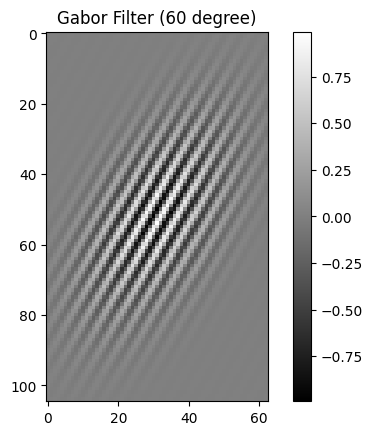

In [51]:
# Visualize the Filter
real_k, imag_k = gabor_filter(sigma, theta, Lambda, psi, gamma )

plt.imshow(imag_k, cmap='gray')
plt.title('Gabor Filter (60 degree)')
plt.colorbar()
plt.show()

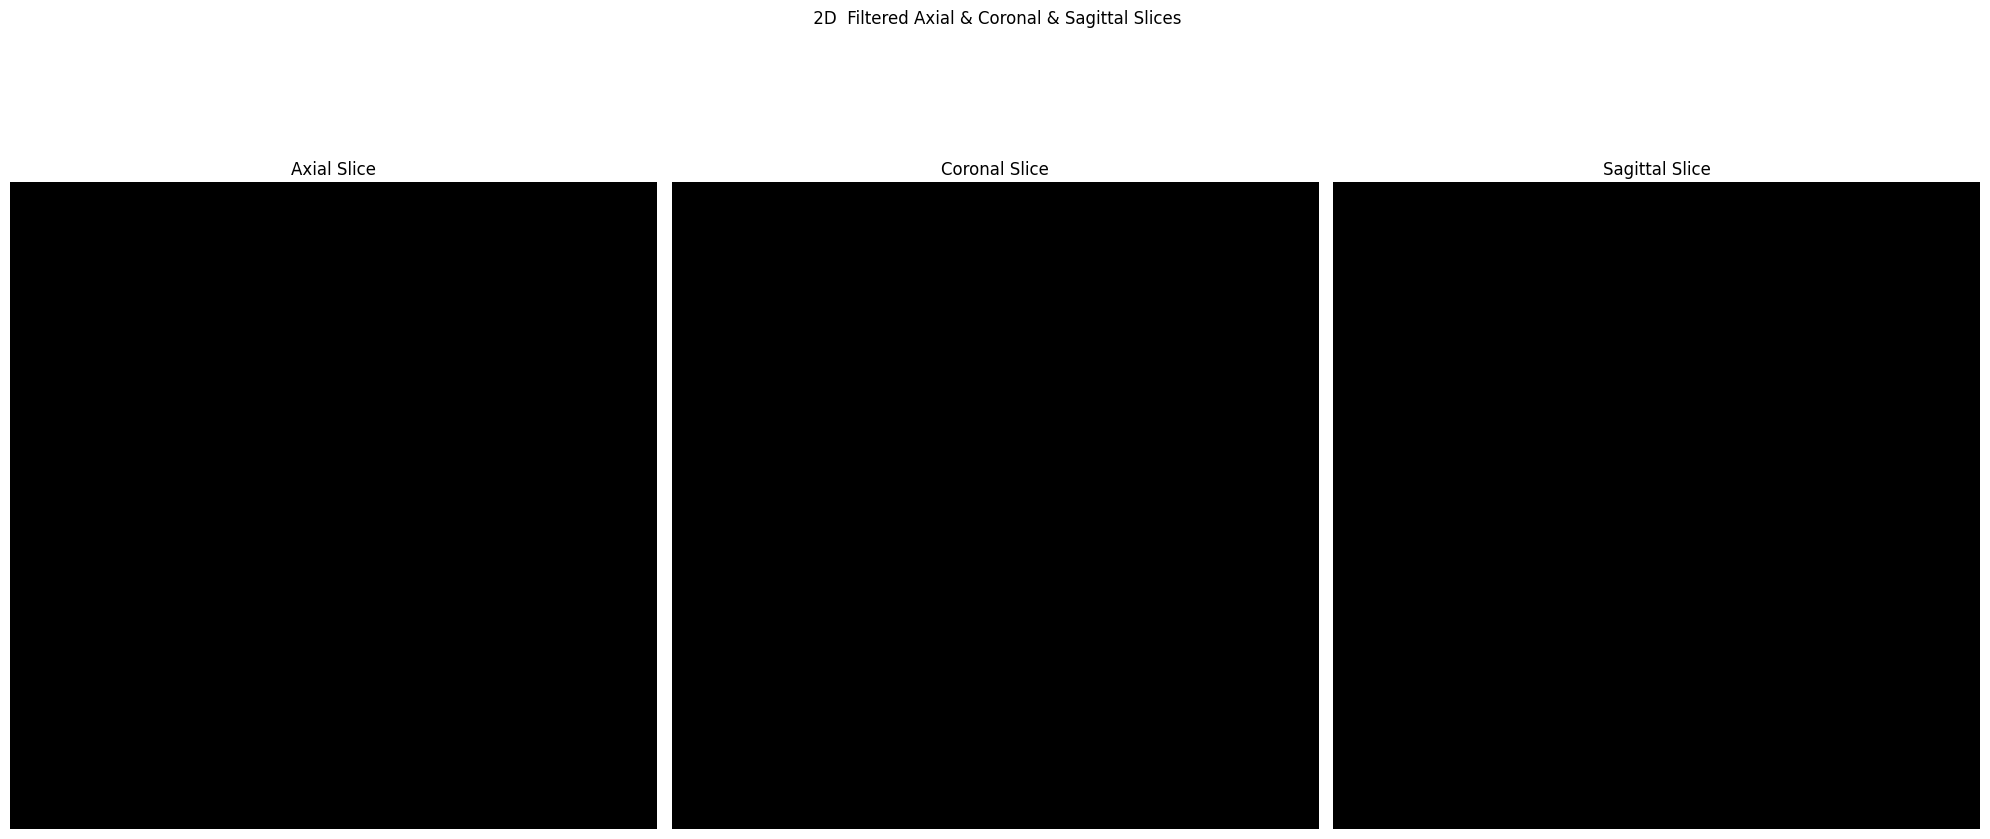

In [52]:
# Applying Gabor Filter to Zero padded Impulse

filtered_2GZAR = convolve(zero_pad_axial_impulse, real_k)
filtered_2GZAI = convolve(zero_pad_axial_impulse, imag_k)
modulus_2GZA = np.sqrt(filtered_2GZAR**2 + filtered_2GZAI**2)

filtered_2GZCR = convolve(zero_pad_coronal_impulse, real_k)
filtered_2GZCI = convolve(zero_pad_coronal_impulse, imag_k)
modulus_2GZC = np.sqrt(filtered_2GZCR**2 + filtered_2GZCI**2)

filtered_2GZSR = convolve(zero_pad_sagittal_impulse, real_k)
filtered_2GZSI = convolve(zero_pad_sagittal_impulse, imag_k)
modulus_2GZS = np.sqrt(filtered_2GZSR**2 + filtered_2GZSI**2)

visualize_images_2D(modulus_2GZA, modulus_2GZC, modulus_2GZS)

#### Rotation Invariance:

**Rotation invariance** in image processing (especially with Gabor filters) is a strategy ***to ensure that the response of a filter to a pattern or texture doesn't change significantly if that pattern is rotated in the image.***

**1. Create a `Gabor filter bank` with multiple orientations**

**2. `Convolve` the image `with each filter` (real + imaginary), then compute the `modulus response`**

**3. `Combine the responses` from all orientations**

In [53]:
orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4] # 0, 45, 90 and 135 degrees

# Rotation invariant response using average pooling
modulus_responses_axial = []
modulus_responses_coronal = []
modulus_responses_sagittal = []

for theta in orientations:
    real_k, imag_k = gabor_filter(sigma, theta, Lambda, psi, gamma)
    
    filtered_2GZAR = convolve(zero_pad_axial_impulse, real_k)
    filtered_2GZAI = convolve(zero_pad_axial_impulse, imag_k)
    modulus_2GZA = np.sqrt(filtered_2GZAR**2 + filtered_2GZAI**2)
    
    filtered_2GZCR = convolve(zero_pad_coronal_impulse, real_k)
    filtered_2GZCI = convolve(zero_pad_coronal_impulse, imag_k)
    modulus_2GZC = np.sqrt(filtered_2GZCR**2 + filtered_2GZCI**2)

    filtered_2GZSR = convolve(zero_pad_sagittal_impulse, real_k)
    filtered_2GZSI = convolve(zero_pad_sagittal_impulse, imag_k)
    modulus_2GZS = np.sqrt(filtered_2GZSR**2 + filtered_2GZSI**2)

    modulus_responses_axial.append(modulus_2GZA)
    modulus_responses_coronal.append(modulus_2GZC)
    modulus_responses_sagittal.append(modulus_2GZS)

    # Average modulus response (rotation invariant)
    rotation_invariant_response_A = np.mean(modulus_responses_axial, axis=0)
    rotation_invariant_response_C = np.mean(modulus_responses_coronal, axis=0)
    rotation_invariant_response_S = np.mean(modulus_responses_sagittal, axis=0)

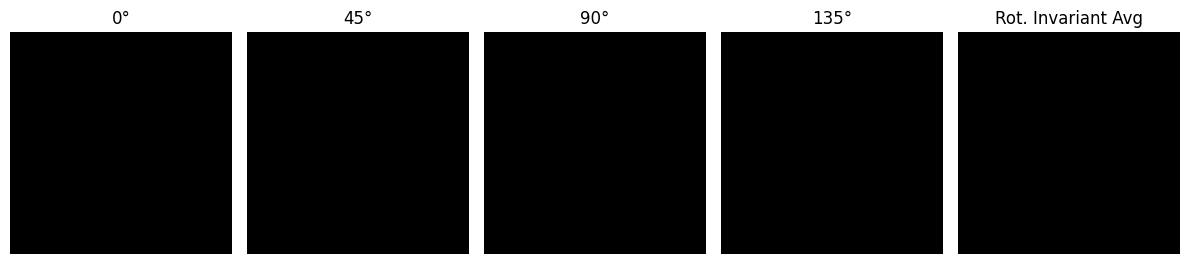

In [54]:
# Plotting The Axial 
plt.figure(figsize=(12, 4))
for i, modulus in enumerate(modulus_responses_axial):
    plt.subplot(1, len(orientations)+1, i+1)
    plt.title(f"{int(np.rad2deg(orientations[i]))}°")
    plt.imshow(modulus, cmap='gray')
    plt.axis('off')

plt.subplot(1, len(orientations)+1, len(orientations)+1)
plt.title("Rot. Invariant Avg")
plt.imshow(rotation_invariant_response_A, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

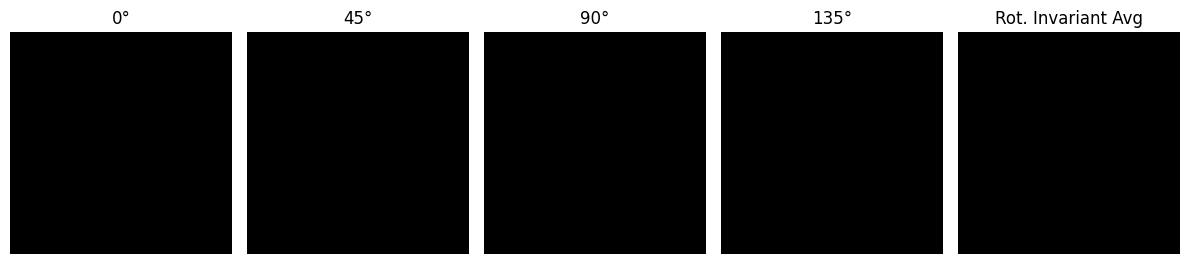

In [55]:
# Plotting The Coronal
plt.figure(figsize=(12, 4))
for i, modulus in enumerate(modulus_responses_coronal):
    plt.subplot(1, len(orientations)+1, i+1)
    plt.title(f"{int(np.rad2deg(orientations[i]))}°")
    plt.imshow(modulus, cmap='gray')
    plt.axis('off')

plt.subplot(1, len(orientations)+1, len(orientations)+1)
plt.title("Rot. Invariant Avg")
plt.imshow(rotation_invariant_response_C, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

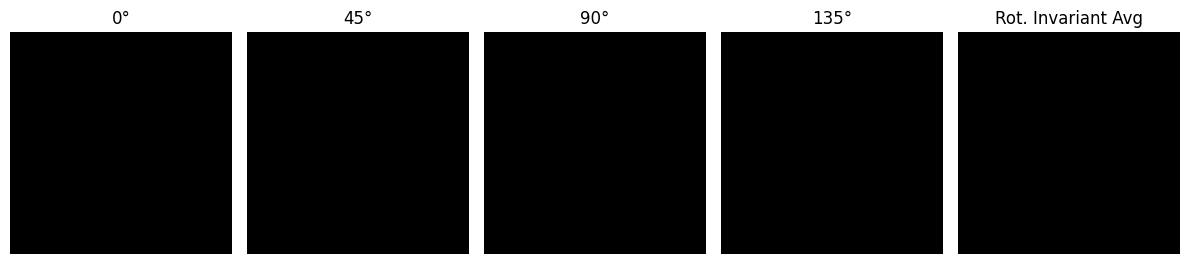

In [56]:
# Plotting The Sagittal
plt.figure(figsize=(12, 4))
for i, modulus in enumerate(modulus_responses_sagittal):
    plt.subplot(1, len(orientations)+1, i+1)
    plt.title(f"{int(np.rad2deg(orientations[i]))}°")
    plt.imshow(modulus, cmap='gray')
    plt.axis('off')

plt.subplot(1, len(orientations)+1, len(orientations)+1)
plt.title("Rot. Invariant Avg")
plt.imshow(rotation_invariant_response_S, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [57]:
# Average 2D responses over orthogonal planes
rotation_invariant_response_3D = (rotation_invariant_response_A +
                                  rotation_invariant_response_C + 
                                  rotation_invariant_response_S) / 3.0

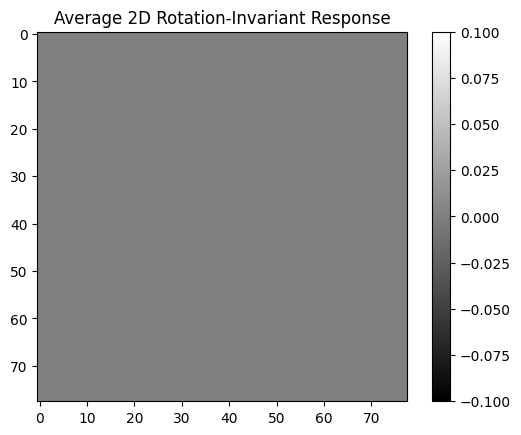

In [58]:
plt.imshow(rotation_invariant_response_3D, cmap='gray')
plt.title("Average 2D Rotation-Invariant Response")
plt.colorbar()
plt.show()

In [59]:
def apply_filter_2D(image, kernel, pad_mode):
    # Get the middle axis of each axis
    axial_idx = image.shape[0] // 2 
    coronal_idx = image.shape[1] // 2  
    sagittal_idx = image.shape[2] // 2  
    
    # Extract the slices
    axial_slice = image[idx, :, :] # Axial slice (XY plane at Z)
    coronal_slice = image[:, idx, :] # Coronal slice (XZ plane at Y)
    sagittal_slice = image[:, :, idx] # Sagittal slice (YZ plane at X)

    # Pad the slices
    padded_axial_slice = np.pad(image, pad_size, mode=pad_mode)
    padded_coronal_slice = np.pad(image, pad_size, mode=pad_mode)
    padded_sagittal_slice = np.pad(image, pad_size, mode=pad_mode)
    
    # Apply filter
    filtered_axial_slice = convolve(axial_slice, kernel, mode=pad_mode)
    filtered_coronal_slice = convolve(coronal_slice, kernel, mode=pad_mode)
    filtered_sagittal_slice = convolve(sagittal_slice, kernel, mode=pad_mode)

    return filtered_axial_slice, filtered_coronal_slice, filtered_sagittal_slice
    

In [60]:
# Set the Parameter values
sigma = 20
theta = np.pi * 5/4
Lambda = 8
psi = 0
gamma = 5/2

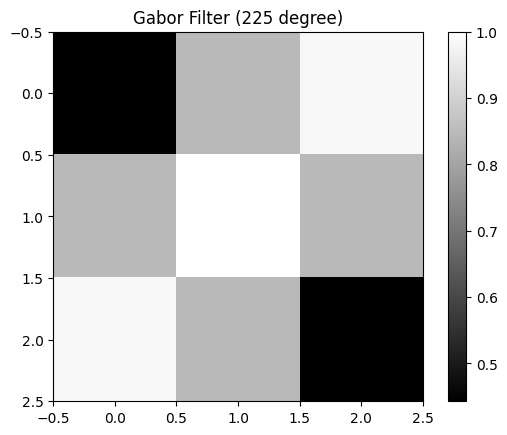

In [61]:
real_k, imag_k = gabor_filter(sigma, theta, Lambda, psi, gamma)

plt.imshow(real_k, cmap='gray')
plt.title('Gabor Filter (225 degree)')
plt.colorbar()
plt.show()

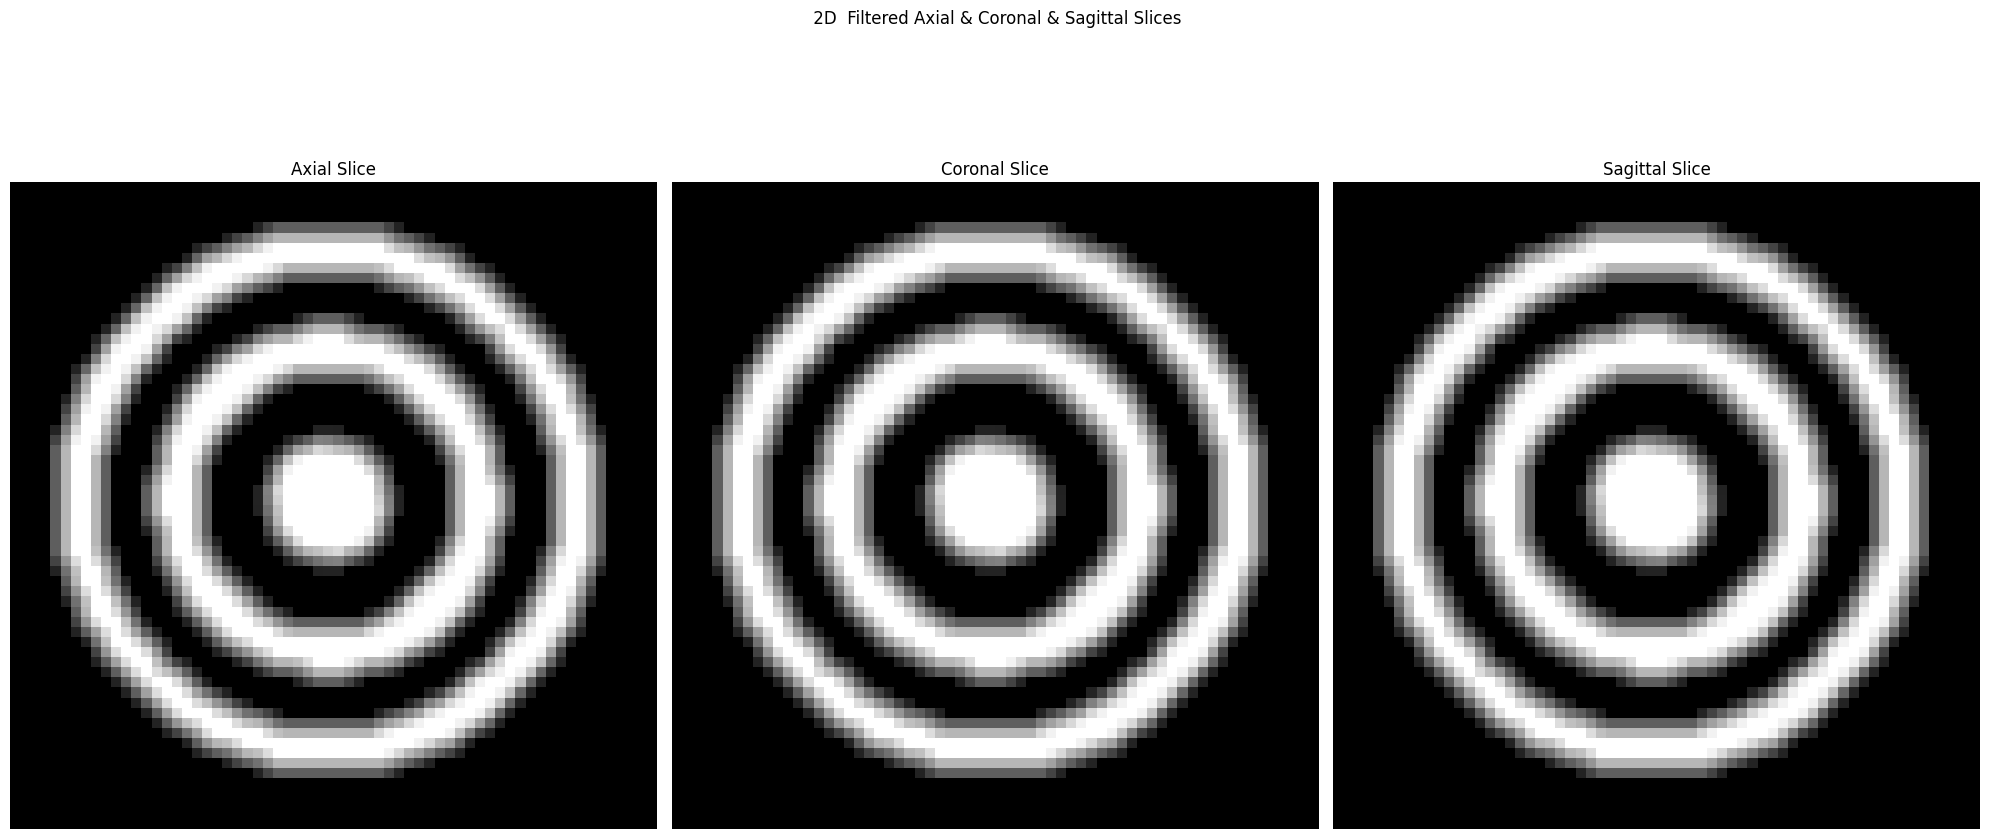

In [62]:
filtered_2GMSAR , filtered_2GMSCR, filtered_2GMSSR = apply_filter_2D(sphere, real_k, pad_mode='reflect')
filtered_2GMSAI , filtered_2GMSCI, filtered_2GMSSI = apply_filter_2D(sphere, imag_k, pad_mode='reflect')

modulus_2GMSA = np.sqrt(filtered_2GMSAR**2 + filtered_2GMSAI**2)
modulus_2GMSC = np.sqrt(filtered_2GMSCR**2 + filtered_2GMSCI**2)
modulus_2GMSS = np.sqrt(filtered_2GMSSR**2 + filtered_2GMSSI**2)

visualize_images_2D(modulus_2GMSA, modulus_2GMSC, modulus_2GMSS)

In [63]:
orientations = [0, np.pi/8, np.pi/4, 3*np.pi/8] # 0, 45, 90, 135 degrees

# Rotation invariant response using average pooling
modulus_responses_axial = []
modulus_responses_coronal = []
modulus_responses_sagittal = []

for theta in orientations:
    real_k, imag_k = gabor_filter(sigma, theta, Lambda, psi, gamma)
    
    filtered_2GMSAR , filtered_2GMSCR, filtered_2GMSSR = apply_filter_2D(sphere, real_k, pad_mode='reflect')
    filtered_2GMSAI , filtered_2GMSCI, filtered_2GMSSI = apply_filter_2D(sphere, imag_k, pad_mode='reflect')

    modulus_2GMSA = np.sqrt(filtered_2GMSAR**2 + filtered_2GMSAI**2)
    modulus_2GMSC = np.sqrt(filtered_2GMSCR**2 + filtered_2GMSCI**2)
    modulus_2GMSS = np.sqrt(filtered_2GMSSR**2 + filtered_2GMSSI**2)
    
    modulus_responses_axial.append(modulus_2GMSA)
    modulus_responses_coronal.append(modulus_2GMSC)
    modulus_responses_sagittal.append(modulus_2GMSS)

    # Average modulus response (rotation invariant)
    rotation_invariant_response_A = np.mean(modulus_responses_axial, axis=0)
    rotation_invariant_response_C = np.mean(modulus_responses_coronal, axis=0)
    rotation_invariant_response_S = np.mean(modulus_responses_sagittal, axis=0)

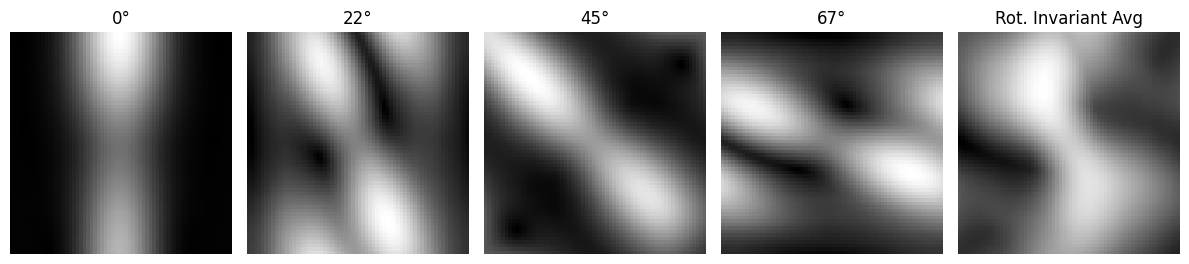

In [64]:
# Plotting The Axial 
plt.figure(figsize=(12, 4))
for i, modulus in enumerate(modulus_responses_axial):
    plt.subplot(1, len(orientations)+1, i+1)
    plt.title(f"{int(np.rad2deg(orientations[i]))}°")
    plt.imshow(modulus, cmap='gray')
    plt.axis('off')

plt.subplot(1, len(orientations)+1, len(orientations)+1)
plt.title("Rot. Invariant Avg")
plt.imshow(rotation_invariant_response_A, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

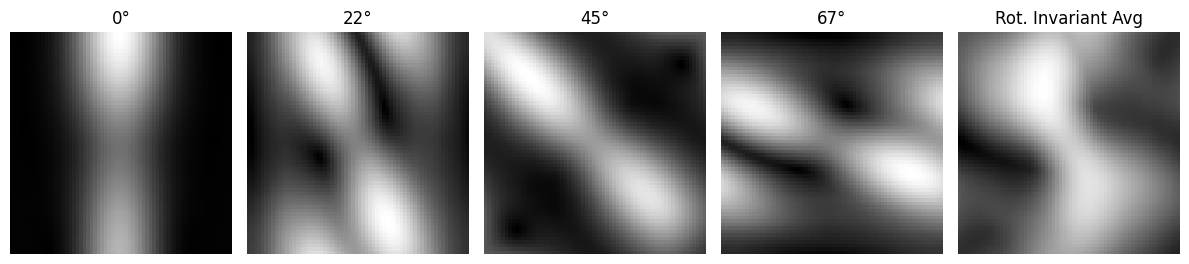

In [65]:
# Plotting The Coronal
plt.figure(figsize=(12, 4))
for i, modulus in enumerate(modulus_responses_coronal):
    plt.subplot(1, len(orientations)+1, i+1)
    plt.title(f"{int(np.rad2deg(orientations[i]))}°")
    plt.imshow(modulus, cmap='gray')
    plt.axis('off')

plt.subplot(1, len(orientations)+1, len(orientations)+1)
plt.title("Rot. Invariant Avg")
plt.imshow(rotation_invariant_response_C, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

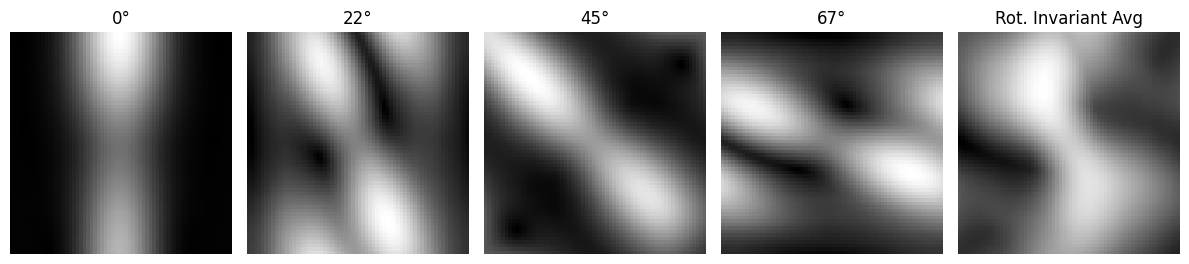

In [66]:
# Plotting The Sagittal
plt.figure(figsize=(12, 4))
for i, modulus in enumerate(modulus_responses_sagittal):
    plt.subplot(1, len(orientations)+1, i+1)
    plt.title(f"{int(np.rad2deg(orientations[i]))}°")
    plt.imshow(modulus, cmap='gray')
    plt.axis('off')

plt.subplot(1, len(orientations)+1, len(orientations)+1)
plt.title("Rot. Invariant Avg")
plt.imshow(rotation_invariant_response_S, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [67]:
# Average 2D responses over orthogonal planes
rotation_invariant_response_3D = (rotation_invariant_response_A +
                                  rotation_invariant_response_C + 
                                  rotation_invariant_response_S) / 3.0

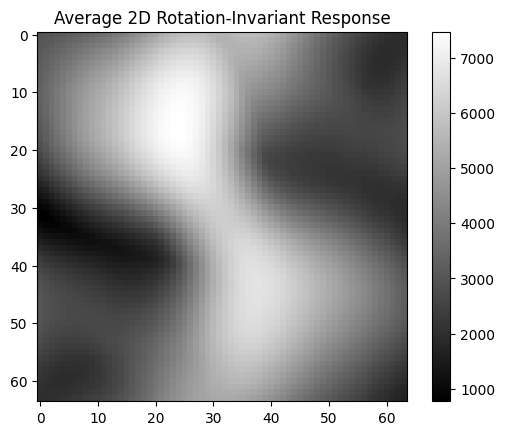

In [68]:
plt.imshow(rotation_invariant_response_3D, cmap='gray')
plt.title("Average 2D Rotation-Invariant Response")
plt.colorbar()
plt.show()

### Wavelets

* Miniature filters that let you look at an image in `different frequency bands` and at different `scales`.
* Use a set of filters and apply them in `layers`

* Start with:
* A `low pass filter gL` -> captures *smooth, large-scale* variations
* A `high pass filter gH` -> captures *sharp, fine* details

The results are called *response maps* or wavelet coefficients.

**In 2D**, applying both along rows and columns gives 4 filtered images per level:
`LL`: low-pass in both directions(the `base` image)
`LH, HL, HH`: edges or details in different directions

#### Decimated Transform
Decimated -> **Downsampling** -> Shrink the filtered images by a factor of 2 after each level.

*How it works*:
1. Start with full-resolution image.
2. Apply `gL` and `gH` filters -> Get 4 images (`LL, LH, HL, HH`)
3. Downsample them
4. Keep only the `LL` and repeat the filtering process on that.
5. This continues for multiple levels (like zooming out each time)

*Pro*: Lose Translation invariance

*Con*: Efficient and Compact

#### Undecimated Transform
*No Downsampling* -> Instead -> `Upsample the filter` to match the image size at each scale.

*How it works:*
1. Apply `gL` and `gH` to the image
2. `Expand the filter` by inserting zeros between it's values (`a trous` algorith, "with holes")
3. Apply these wider filters to the original full-size image again.
4. This give multiscale decomposition, but all outputs have the same size as the original image.

*Pro*: Translation Invariant

*Con*: Great for analysis

#### Separable Wavelets

Apply 1D filters in each direction (x, then y, then z in 3D).

eg: Filter rows with `gL`, then columns with `gH`

Efficient but **not rotation invariant.**

### Deubechies Wavelets

* Each Deubechies Wavelet is defined by its number of *vanishing moments* (`p`)
* `Vanishing moments` determine how well the wavelet can approximate polynomials.
* A `higher p` means smoother wavelets and better approximation.

**For example**
* `db1` (Daubechies with p=1) = Haar wavelet
* `db2`, `db3`, ... are smoother and more accurate

#### 3D Undecimated LHL Map:

`Input`: 3D image + `Undecimated`: No Downsampling after filtering i.e Output size = Input size + `LHL map`: 
* Apply Low-pass filter along axis 0
* Apply High-pass filter along axis 1
* Apply Low-pass filter along axis 2

*Extracts Directional Texture Features from the image*

In [71]:
import sys
!{sys.executable} -m pip install PyWavelets

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 5.0 MB/s eta 0:00:004.8 MB/s eta 0:00:01

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [72]:
import pywt
from scipy.ndimage import convolve1d
 
def undecimated_LHL_daubechies_3D(image, wavelet_name='db2'):
    # Step 1: Get Daubechies filters
    wavelet = pywt.Wavelet(wavelet_name)
    gL = np.array(wavelet.dec_lo) # Low-pass
    gH = np.array(wavelet.dec_hi) # High-pass

    # Step 2: Zero pad filters to odd length for symmetry
    if len(gL) % 2 == 0:
        gL = np.append(gL, 0)
    if len(gH) % 2 == 0:
        gH = np.append(gH, 0)

    # Step 3: Apply convolution in 3D: LHL = Low (axis 0), High (axis 1), Low (axis 2)
    # Use mode='constant' for zero padding
    low_0 = convolve1d(image, gL, axis=0, mode='constant', cval=0.0)
    high_1 = convolve1d(low_0, gH, axis=1, mode='constant', cval=0.0)
    lhl_map = convolve1d(high_1, gL, axis=2, mode='constant', cval=0.0)

    return lhl_map

In [73]:
# Compute 1st-level LHL wavelet map
lhl_map = undecimated_LHL_daubechies_3D(zero_pad_impulse, wavelet_name='db2')

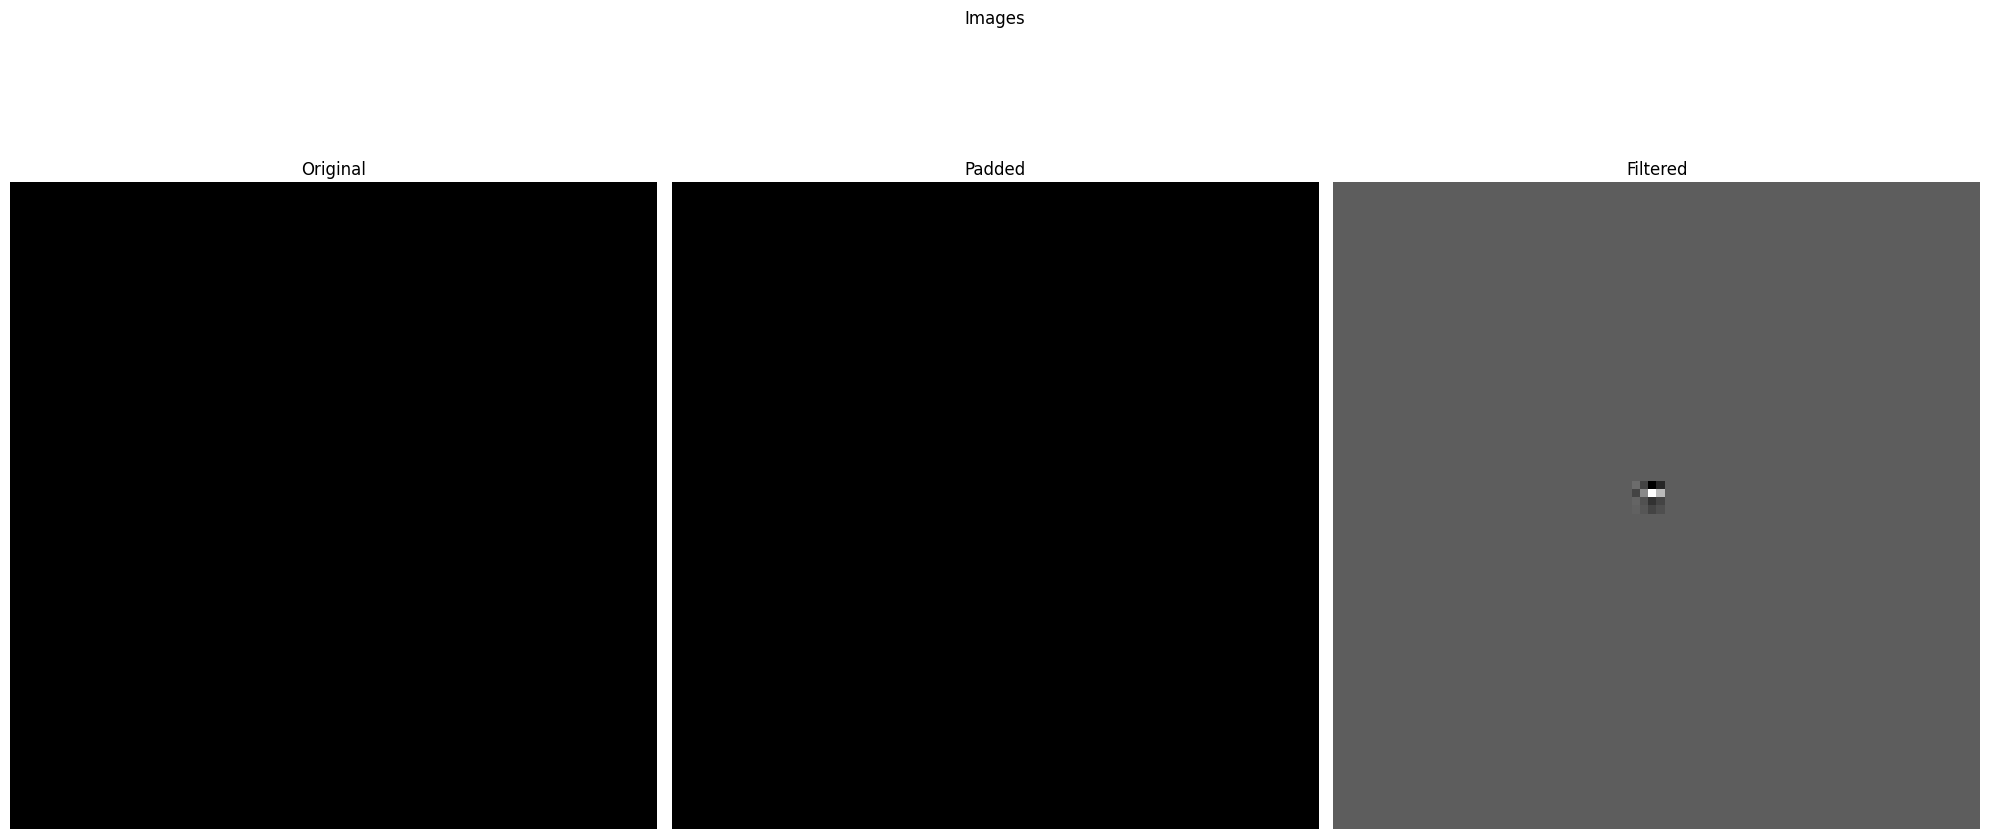

In [74]:
visualize_images_3D(impulse, zero_pad_impulse, lhl_map)

#### Rotation Invariance
Daubechies wavelets are not inherently rotation-invariant, because the filtering is axis-aligned. So to gain rotation invariance:

* Rotate the volume in 90-degree increments across the three planes (xy, xz, yz)
* For each rotated version, apply the same filtering
* Then aggregate the outputs using maximum, average or other statistical measures 

In [75]:
from scipy.ndimage import rotate

def generate_rotations(volume):
    '''
    Return 90-degree rotations around all major axes.
    '''

    rotations = []

    for axes in [(0, 1), (0, 2), (1, 2)]:
        for angle in [0, 90, 180, 270]:
            rotated = rotate(volume, angle=angle, axes=axes, reshape=False, order=1)
            rotations.append(rotated)
    return rotations

In [76]:
rotations = generate_rotations(zero_pad_impulse)

In [77]:
filtered = []
for rotation in rotations:
    filtered.append(undecimated_LHL_daubechies_3D(rotation, wavelet_name='db2')) 

len(filtered)

filtered_LHL_agg = np.mean(np.stack(filtered), axis=0)

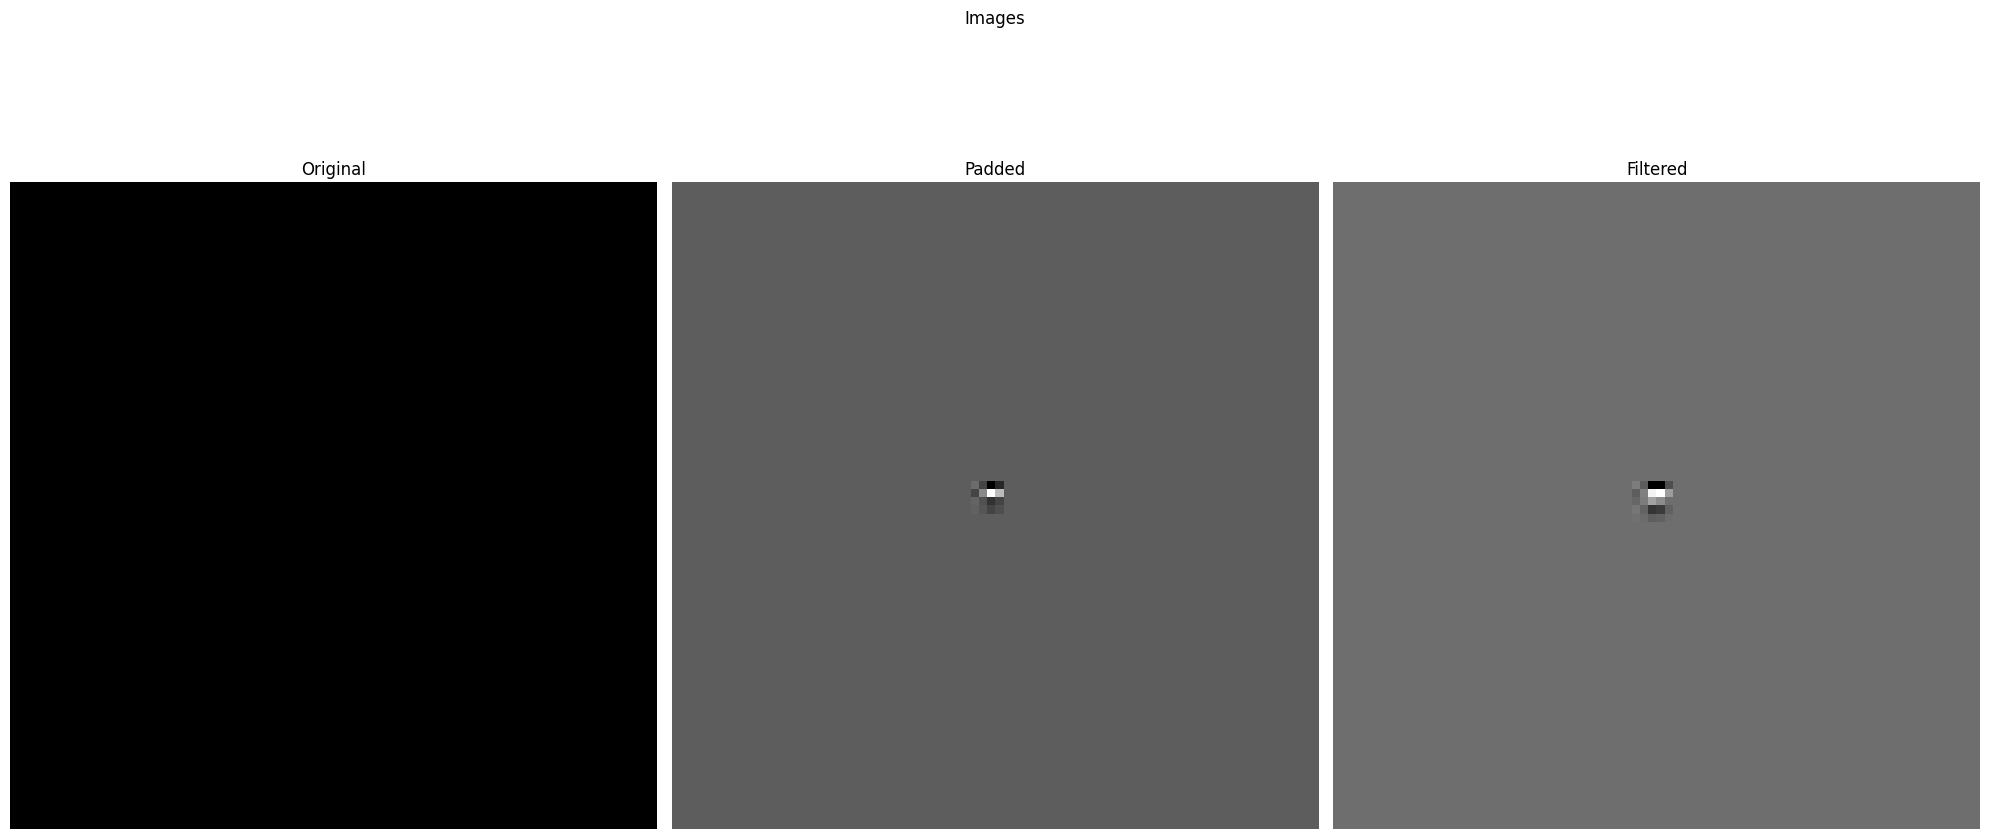

In [78]:
visualize_images_3D(zero_pad_impulse, lhl_map, filtered_LHL_agg)

### Coiflet 1


In [79]:
def undecimated_HHL_coiflet_3D(image, wavelet_name='coif1'):
    # Step 1: Get Coiflet filters
    wavelet = pywt.Wavelet(wavelet_name)
    gL = np.array(wavelet.dec_lo) # Low-pass
    gH = np.array(wavelet.dec_hi) # High-pass

    # Step 1: Apply 1D convolution along each axis with periodic padding
    # Use mode='constant' for zero padding
    high_0 = convolve1d(image, gH, axis=0, mode='wrap')
    high_1 = convolve1d(high_0, gH, axis=1, mode='wrap')
    hhl_map = convolve1d(high_1, gL, axis=2, mode='wrap')

    return hhl_map

In [80]:
periodic_pad_sphere = np.pad(sphere, pad_size, mode='wrap')

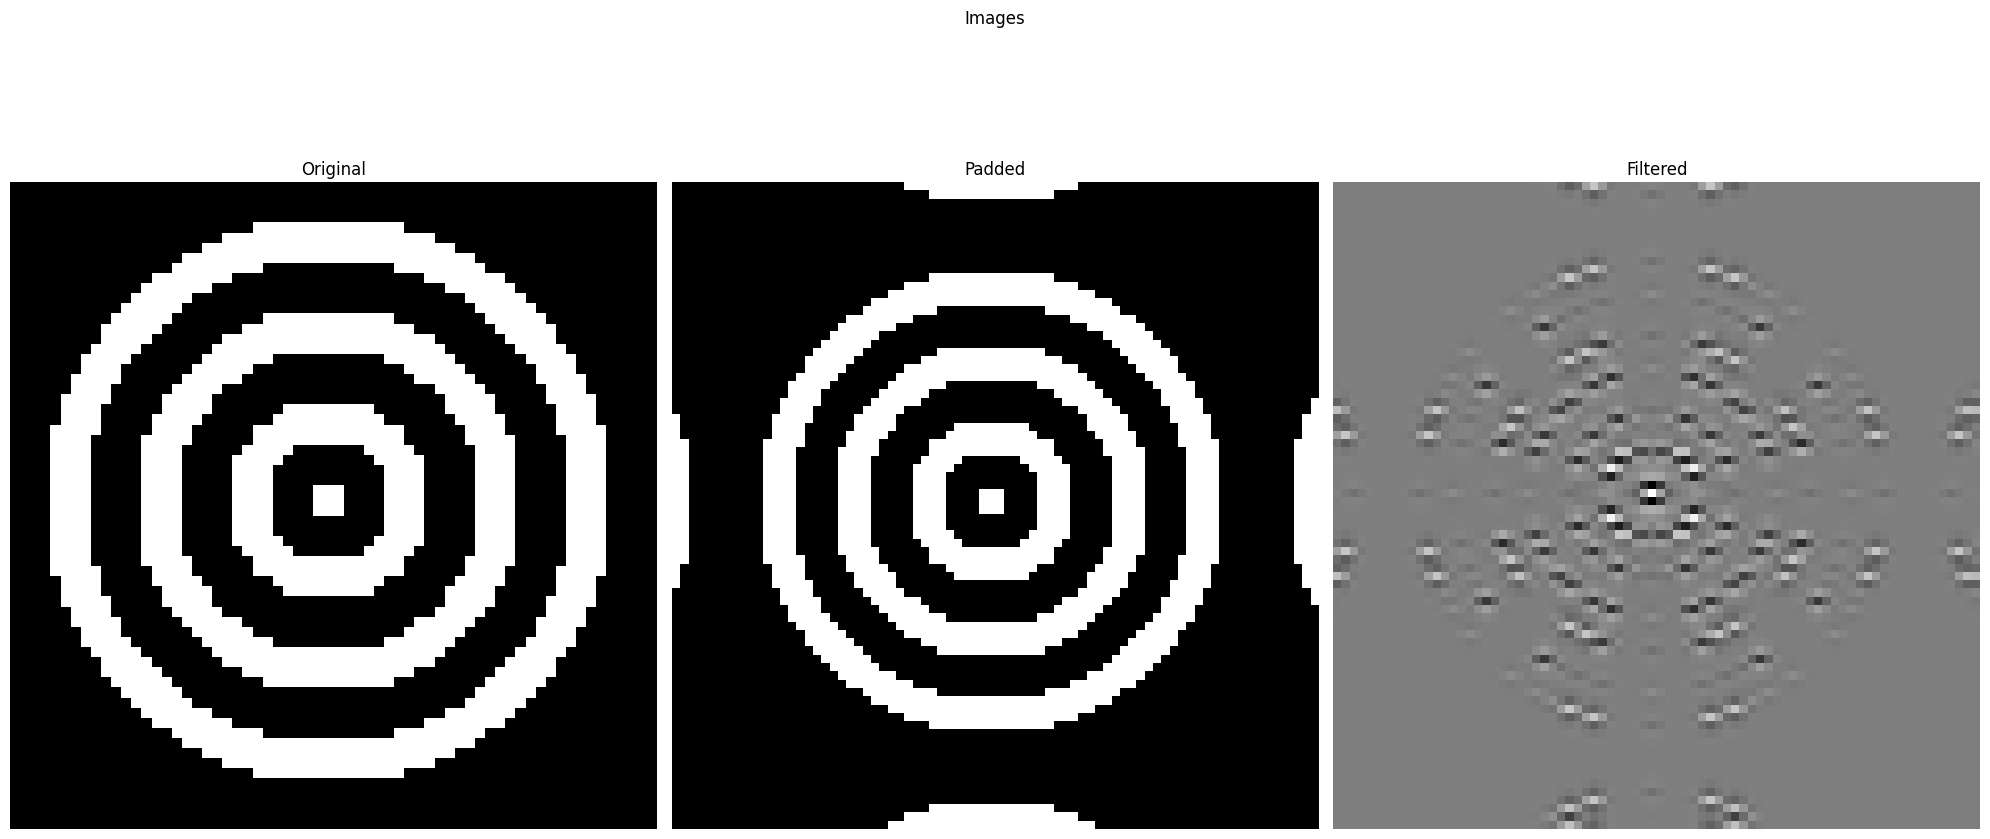

In [81]:
# Compute 1st-level HHL wavelet map
hhl_map = undecimated_HHL_coiflet_3D(periodic_pad_sphere, wavelet_name='coif1')
visualize_images_3D(sphere, periodic_pad_sphere, hhl_map)

In [82]:
rotations = generate_rotations(periodic_pad_sphere)

In [83]:
filtered = []
for rotation in rotations:
    filtered.append(undecimated_HHL_coiflet_3D(rotation, wavelet_name='db2')) 

len(filtered)

filtered_HHL_agg = np.mean(np.stack(filtered), axis=0)

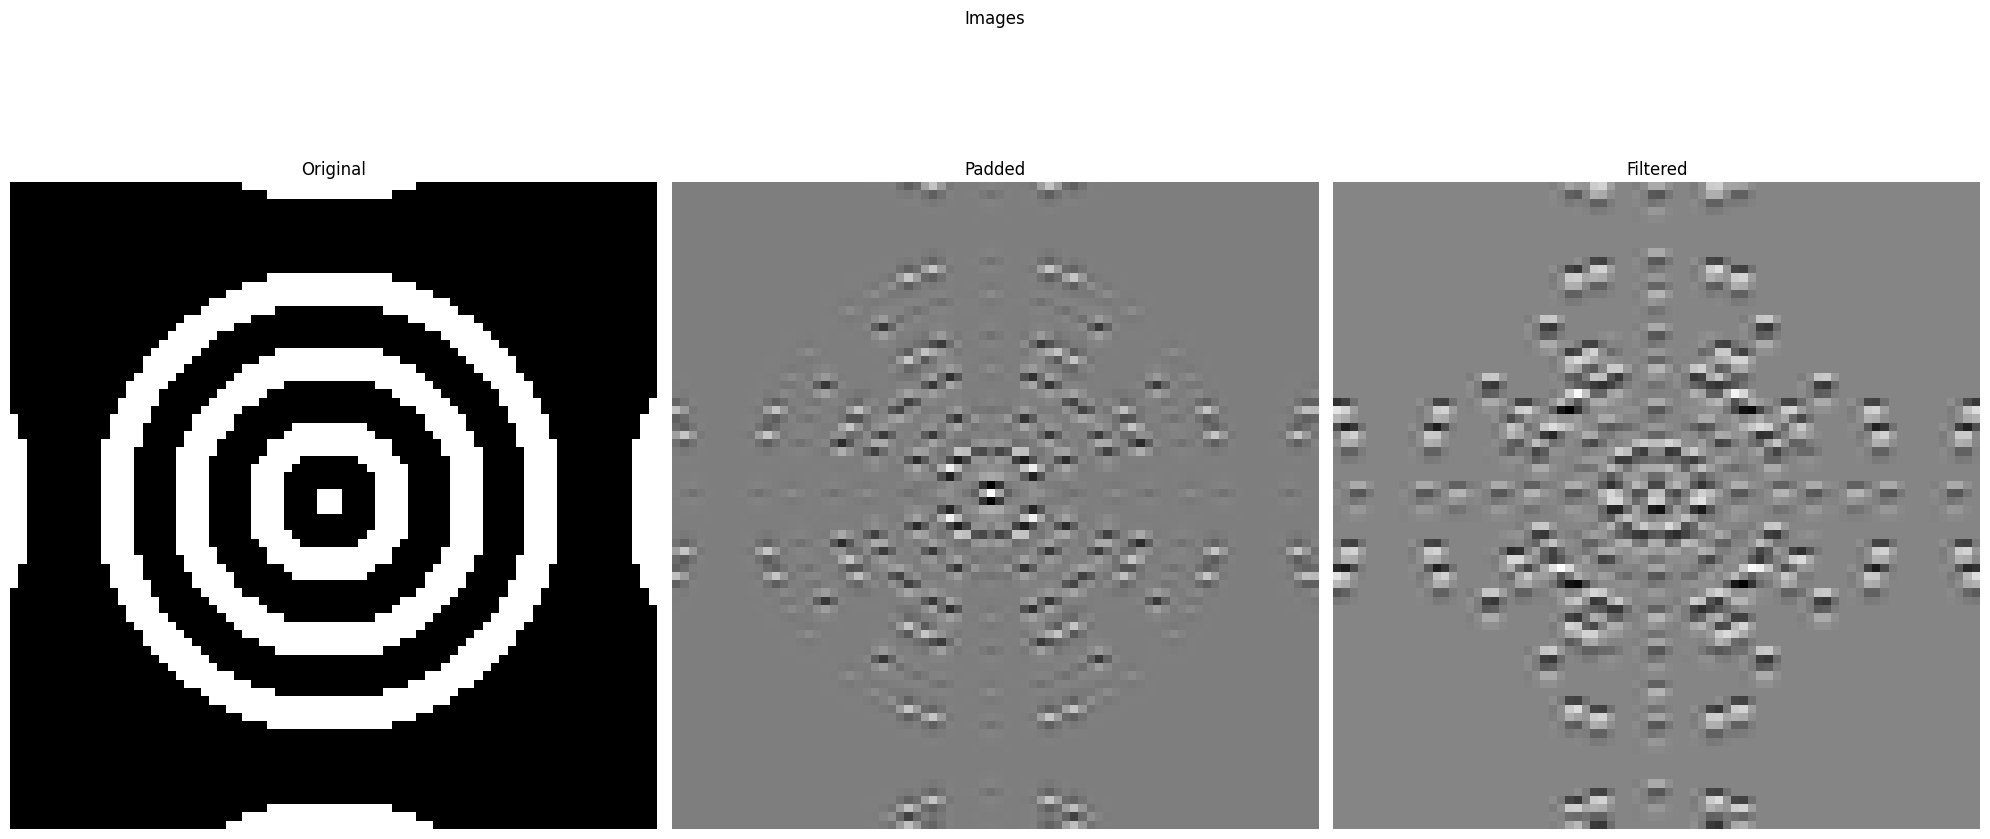

In [84]:
visualize_images_3D(periodic_pad_sphere, hhl_map, filtered_HHL_agg)

#### Haar Filter

• Mirror padding

• 3D filter, undecimated LLL map – 2nd level

• 3D rotation invariance, average pooling

In [85]:
import numpy as np
from scipy.ndimage import convolve1d

# Haar wavelet filters
gL = np.array([1 / np.sqrt(2), 1 / np.sqrt(2)])
gH = np.array([1 / np.sqrt(2), -1 / np.sqrt(2)])

def haar_filter_3D(image, filter_type='LLL', level=2):
    """
    Applies undecimated 3D Haar wavelet filtering with mirror (symmetric) padding.
    
    Parameters:
        image (ndarray): 3D input image.
        filter_type (str): One of 'LLL' or 'HHH'.
        level (int): 1 or 2 for decomposition level.

    Returns:
        ndarray: Filtered image.
    """
    # Choose kernel based on filter type
    if filter_type == 'LLL':
        kernel = gL
    elif filter_type == 'HHH':
        kernel = gH
    else:
        raise ValueError("Supported filter types: 'LLL', 'HHH'")

    def apply_separable_filter(img):
        out = convolve1d(img, kernel, axis=0, mode='reflect')  # mirror padding
        out = convolve1d(out, kernel, axis=1, mode='reflect')
        out = convolve1d(out, kernel, axis=2, mode='reflect')
        return out

    result = image.copy()
    for _ in range(level):
        result = apply_separable_filter(result)

    return result

In [86]:
def rotation_invariance_pooling(image, rotations=8):
    """
    Rotates the image at different angles and averages the results to achieve rotation invariance.
    """
    rotated_images = []
    
    for i in range(rotations):
        angle = 360 * i / rotations  # 8 rotations for example
        rotated_image = np.rot90(image, k=i)  # Rotate image by angle
        rotated_images.append(rotated_image)
    
    # Average pooling across the rotated images
    pooled_image = np.mean(rotated_images, axis=0)
    
    return pooled_image

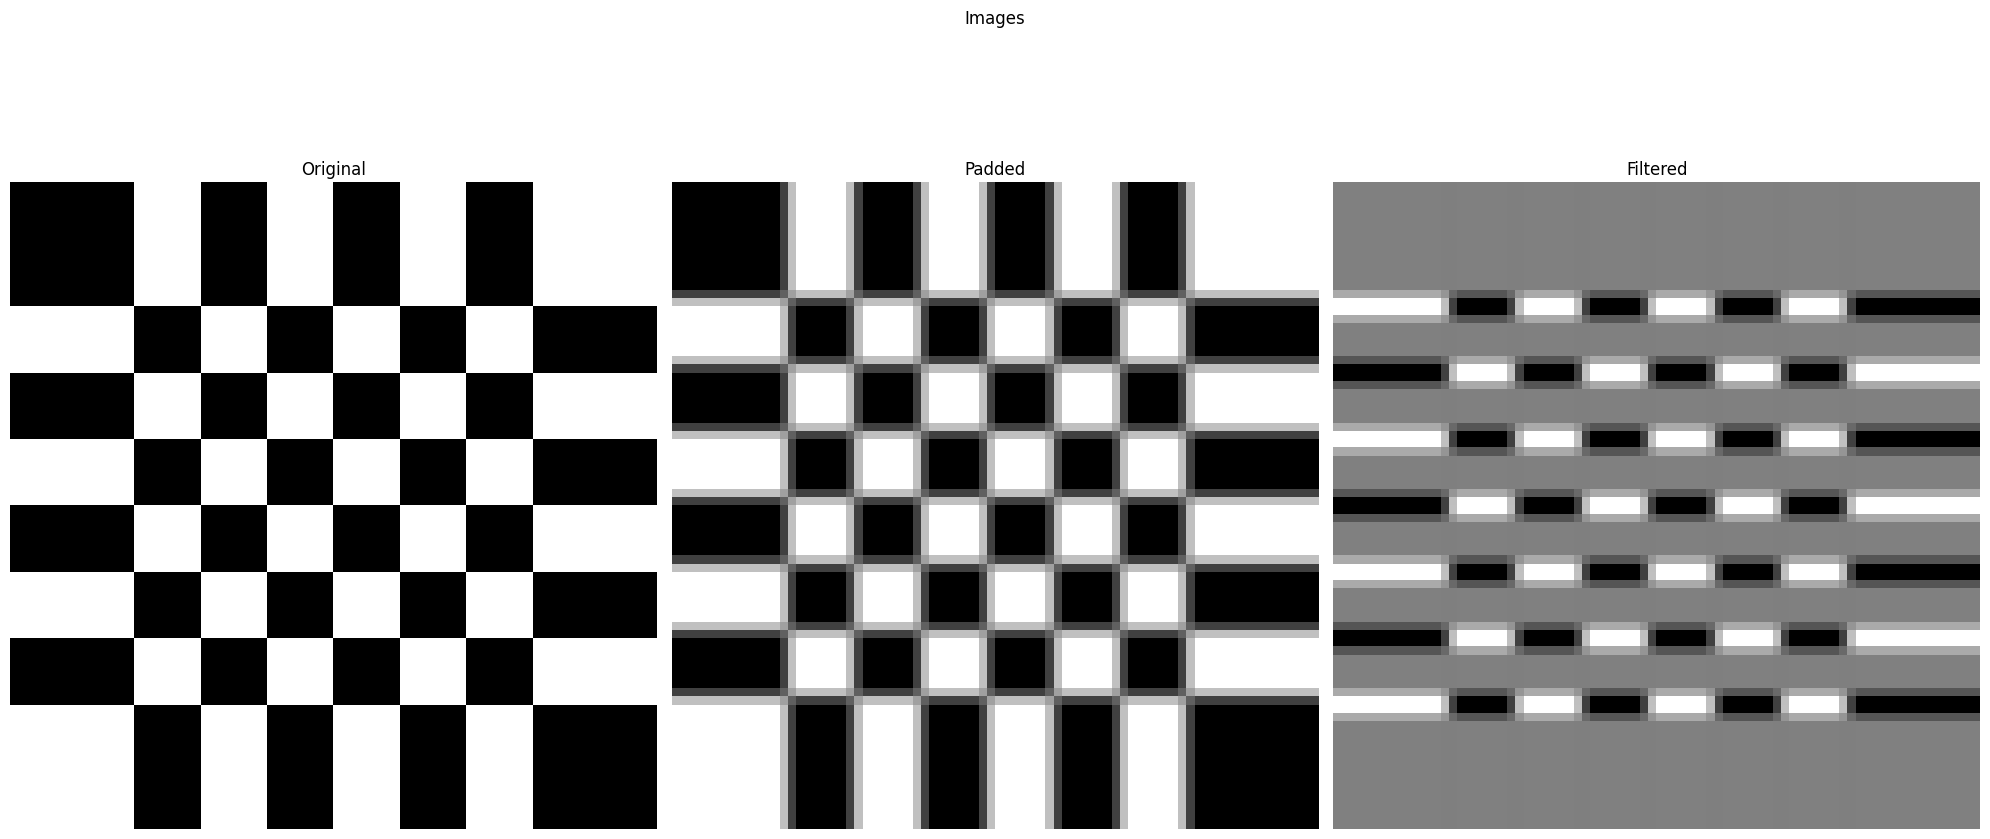

In [87]:
lll_map_2 = haar_filter_3D(mirror_pad_checkerboard, filter_type='LLL', level=2)
pooled_lll_map_2 = rotation_invariance_pooling(lll_map_2)

visualize_images_3D(mirror_pad_checkerboard, lll_map_2, pooled_lll_map_2)

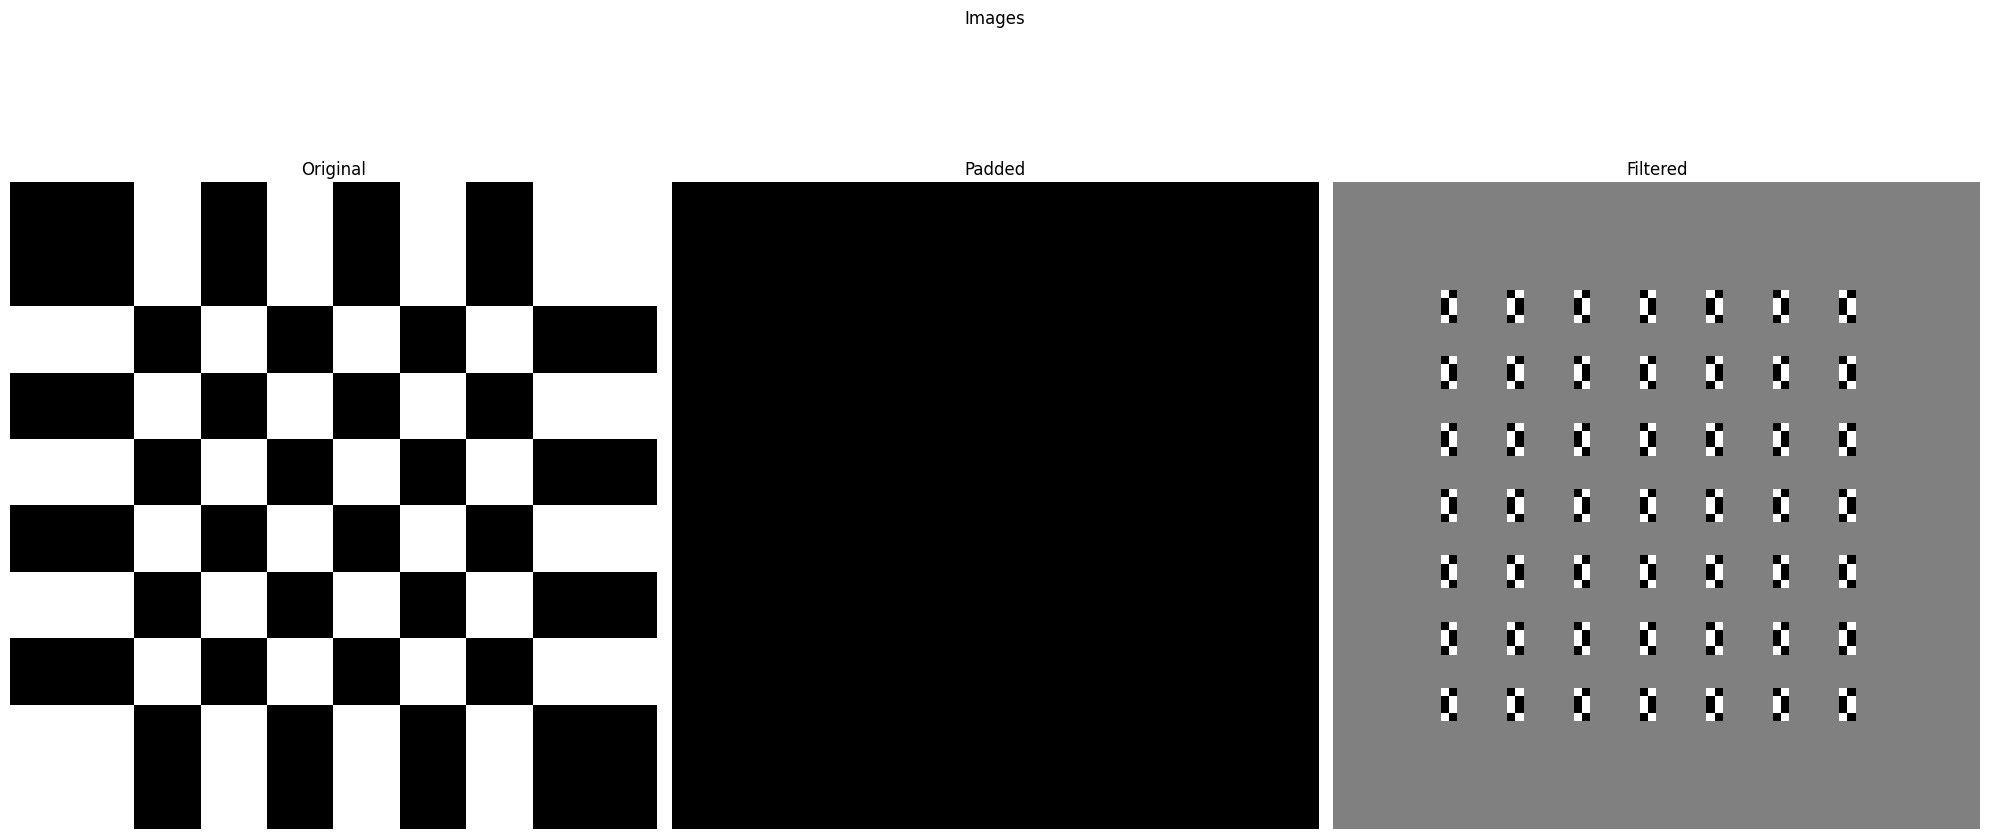

In [88]:
hhh_map_2 = haar_filter_3D(mirror_pad_checkerboard, filter_type='HHH', level=2)
pooled_hhh_map_2 = rotation_invariance_pooling(hhh_map_2)

visualize_images_3D(mirror_pad_checkerboard, hhh_map_2, pooled_hhh_map_2)

### Non Separable Wavelets
Analyze the `whole 2D or 3D` frequency spectrum in a `rotation invariant` way.

`Common non-separable wavelets:`
* `Shannon Wavelet:` sharp band-pass
* `Simoncelli Wavelet:` smoother, with compact support in space

#### Simoncelli Wavelet

* It is defined in the *Fourier Domain* based on a smooth radial function.
* Naturally suited for rotation-invariant analysis, particularly in applications like radiomics.

*Non-Separable*

*Rotation-invariant*

*Undecimated*

*Multi-scale*

**Implementation**

1. Prepare the frequency grid
2. Define the Simoncelli filter in Fourier domain
3. Apply the filter in Fourier domain

In [89]:
def get_radial_freq_grid_3D(shape):
    '''
    Generates a 3D radial frequency grid (||v||) in the normalized Fourier domain.
    '''
    N1, N2, N3 = shape
    freqs_x = np.fft.fftfreq(N1, d=1/N1) * np.pi  # range [-π, π]
    freqs_y = np.fft.fftfreq(N2, d=1/N2) * np.pi
    freqs_z = np.fft.fftfreq(N3, d=1/N3) * np.pi
    
    fx, fy, fz = np.meshgrid(freqs_x, freqs_y, freqs_z, indexing='ij')
    norm_freq = np.sqrt(fx**2 + fy**2 + fz**2)
    return norm_freq

In [90]:
def simoncelli_filter(norm_freq, nu_B=np.pi):
    response = np.zeros_like(norm_freq)
    mask = (norm_freq >= nu_B/4) & (norm_freq <= nu_B)
    response[mask] = np.cos((np.pi / 2) * np.log2((2 * norm_freq[mask]) / nu_B))
    return response

In [91]:
from numpy.fft import fftn, ifftn

def simoncelli_3D_response(image_3d, level=1):
    """
    Applies the 3D Simoncelli wavelet filter (1st level B map) to a 3D image.
    """
    nu_B = np.pi / (2**(level - 1))  # e.g., π at level 1
    norm_freq = get_radial_freq_grid_3D(image_3d.shape)
    
    # Define the filter
    sim_filter = simoncelli_filter(norm_freq, nu_B)
    
    # Fourier transform of the image
    image_fft = fftn(image_3d)
    
    # Apply bandpass filter via Hadamard product
    filtered_fft = image_fft * sim_filter
    
    # Inverse Fourier transform to get filtered image (real part only)
    response = np.real(ifftn(filtered_fft))
    
    return response

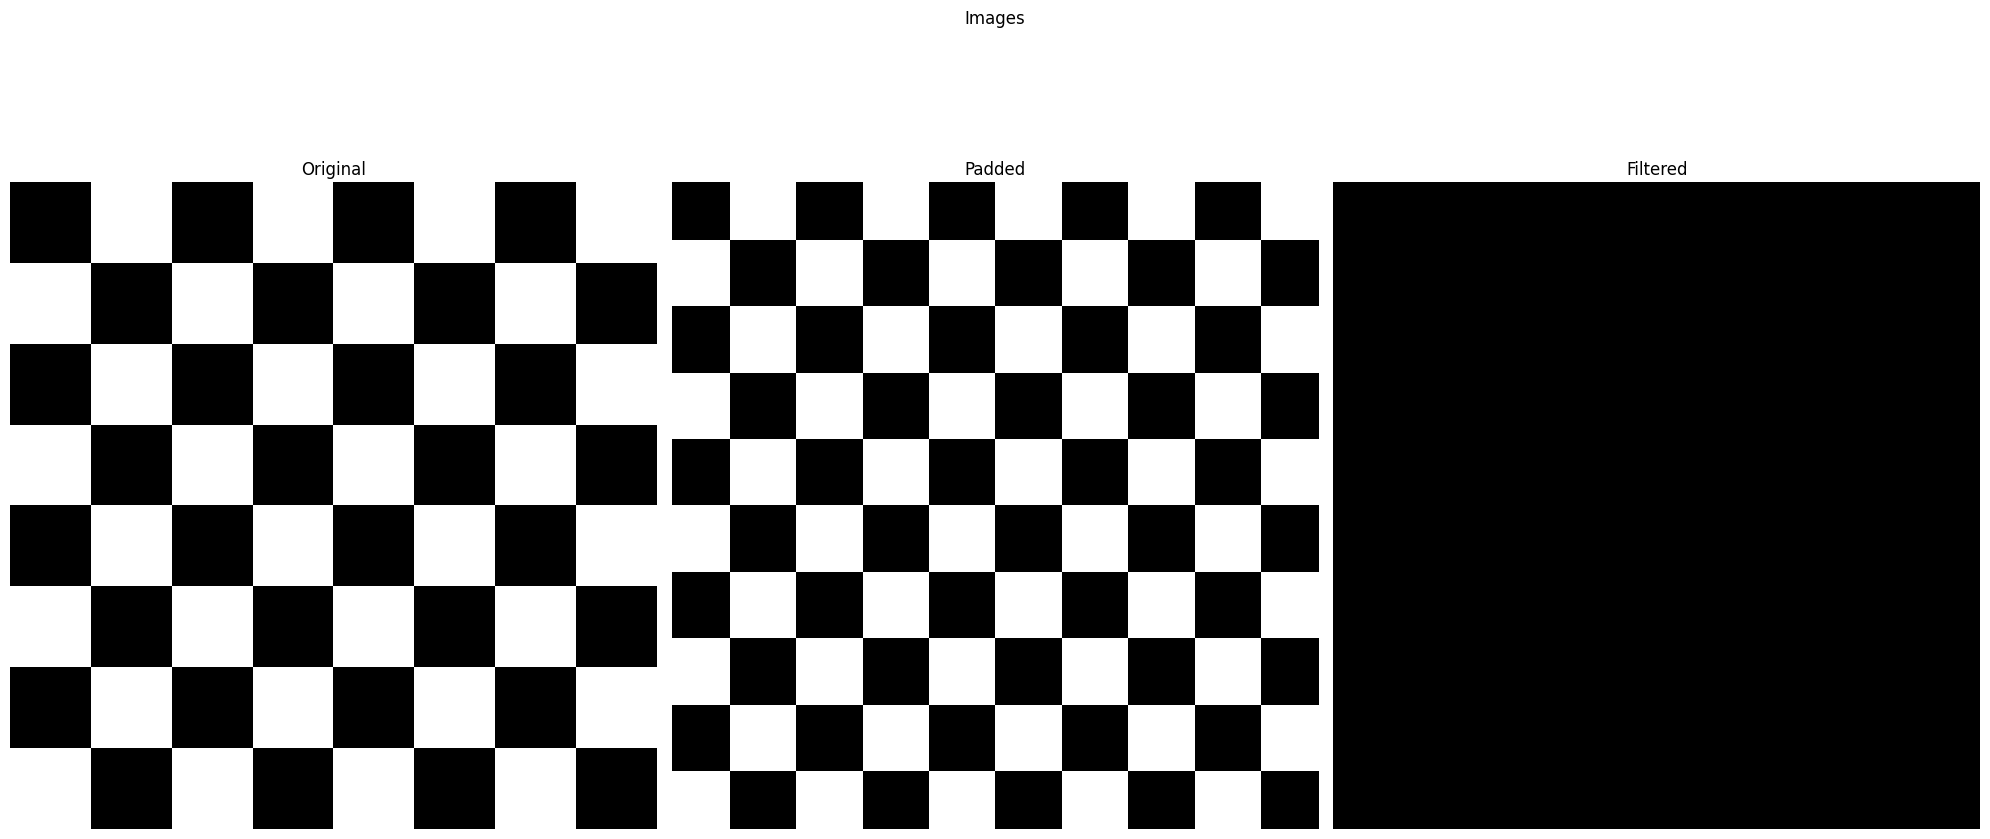

In [92]:
# 1st Level
filtered_3SPCL1 = simoncelli_3D_response(periodic_pad_checkerboard, level=1)

# Visualize
visualize_images_3D(checkerboard, periodic_pad_checkerboard, filtered_3SPCL1)

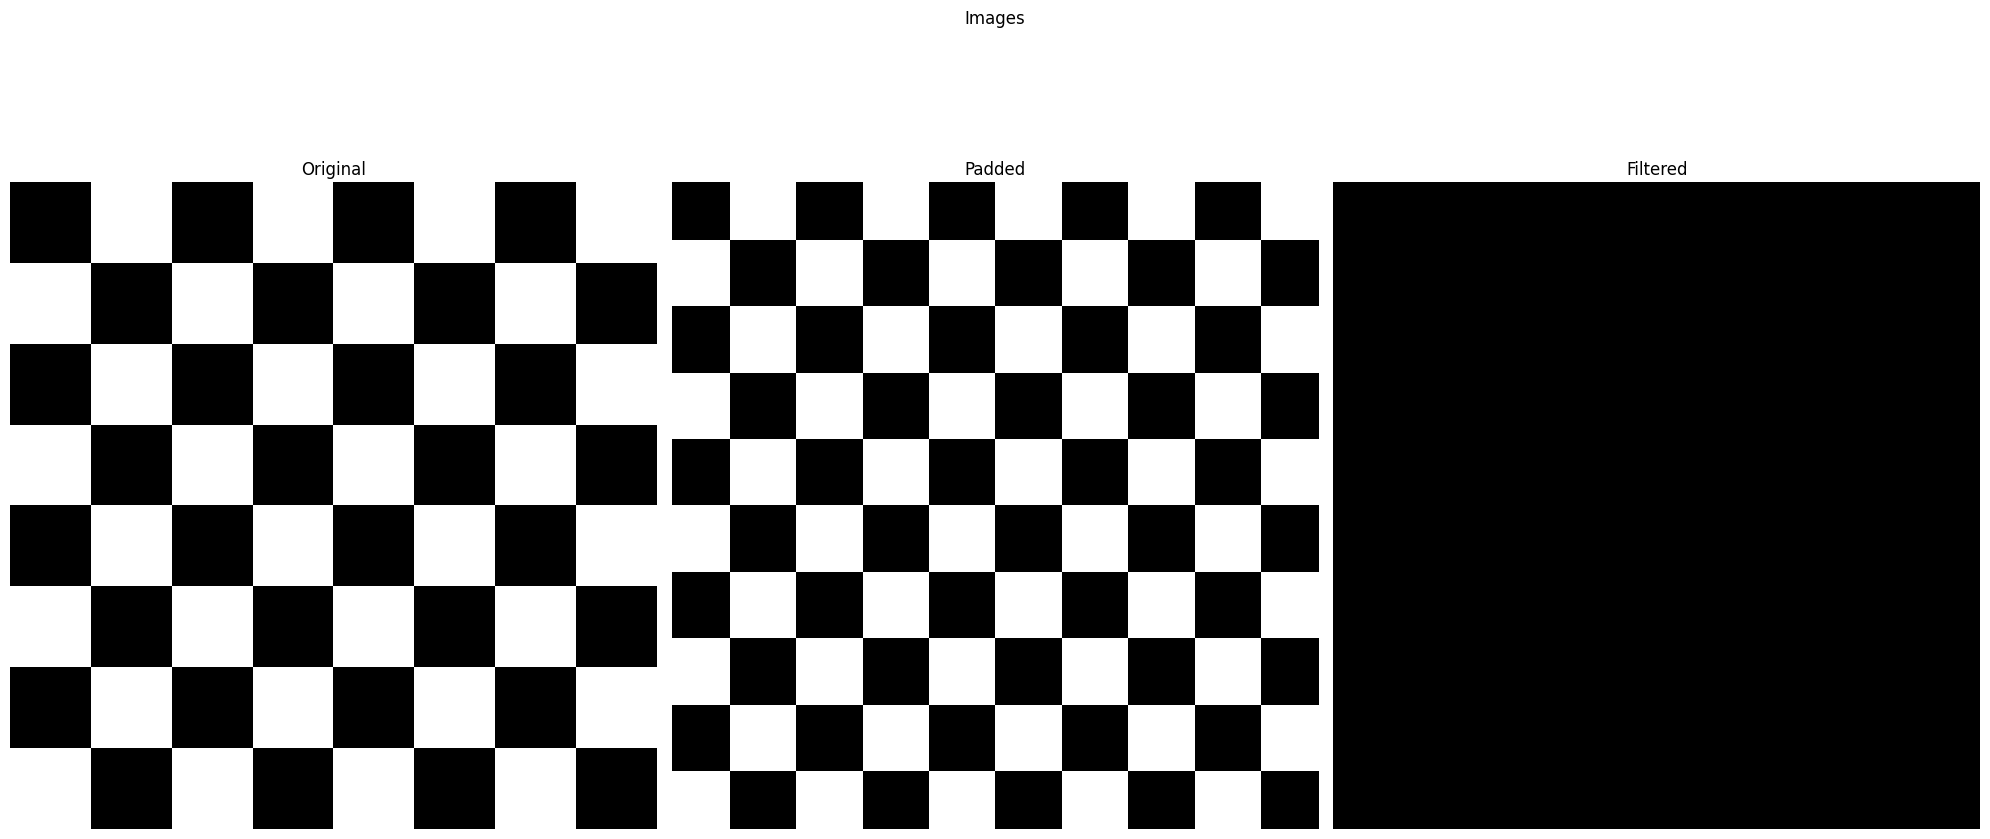

In [93]:
# 2nd Level
filtered_3SPCL2 = simoncelli_3D_response(periodic_pad_checkerboard, level=2)

# Visualize
visualize_images_3D(checkerboard, periodic_pad_checkerboard, filtered_3SPCL2)

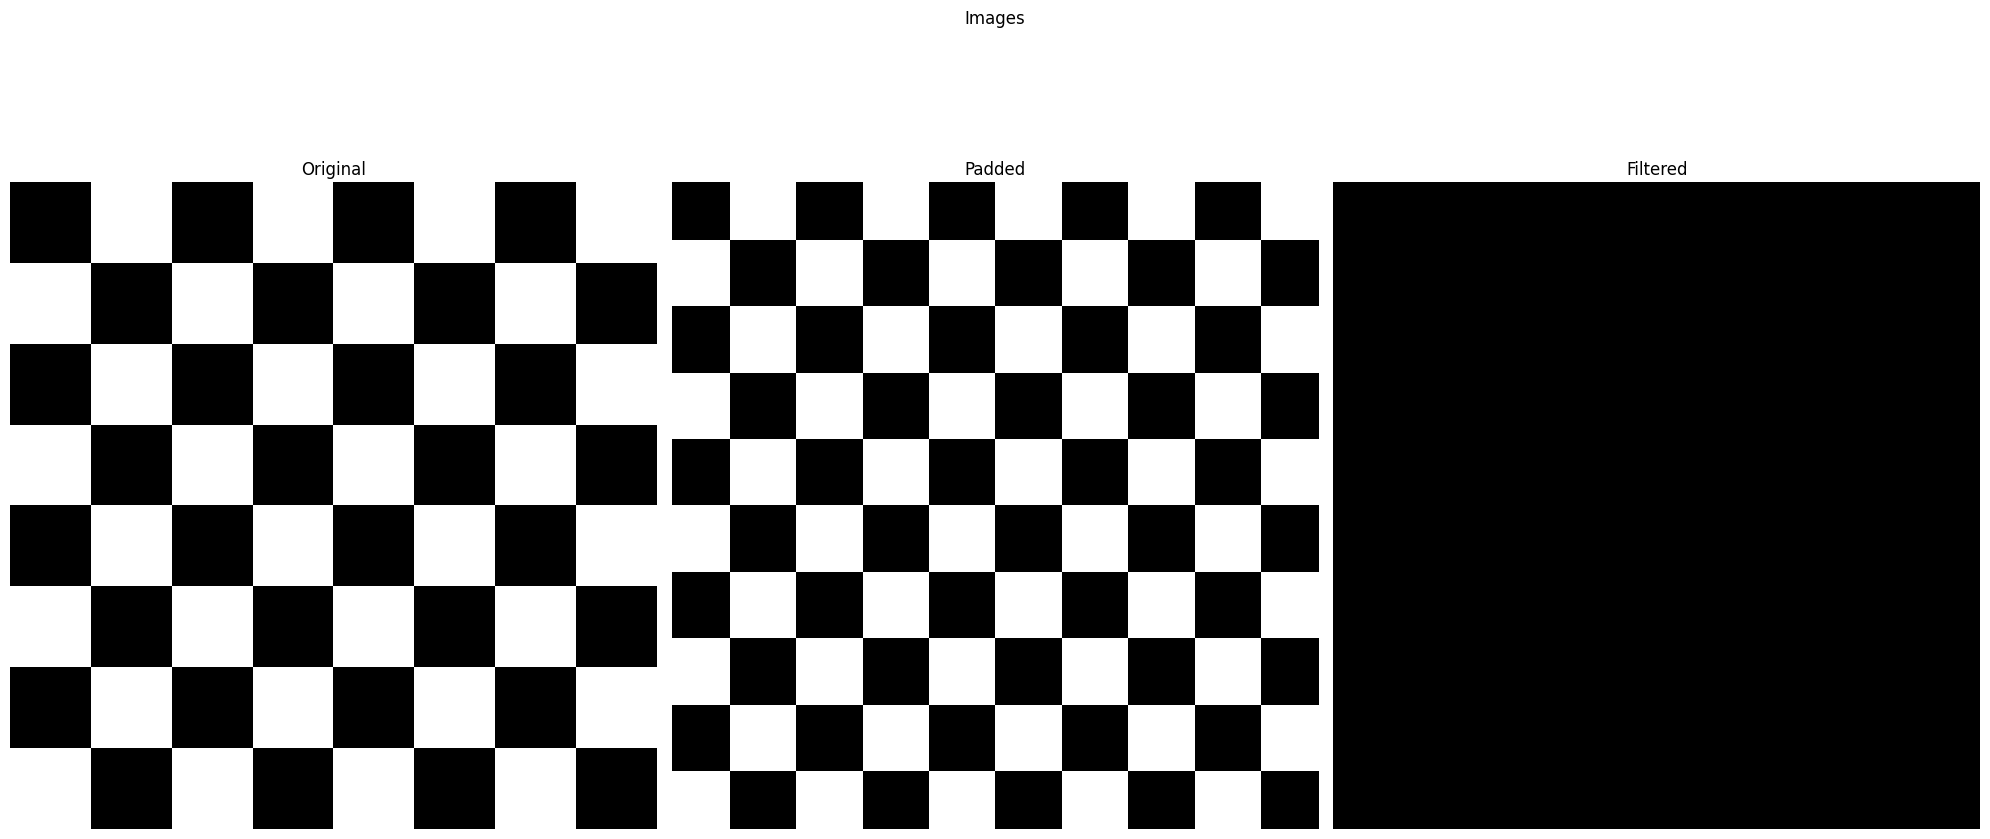

In [94]:
# 2nd Level
filtered_3SPCL3 = simoncelli_3D_response(periodic_pad_checkerboard, level=3)

# Visualize
visualize_images_3D(checkerboard, periodic_pad_checkerboard, filtered_3SPCL3)

### Riesz 

* Used to detect *directional features* in a rotation-aware and scale-aware way
* Produces all-pass filters: preserves information from all frequencies, not just high ones
* Rotation equivariant: can detect patterns in any direction

**How does it work?**
1. Start with an image
2. Transform it to the frequency domain (Fourier transform)
3. Apply a special filter in the frequency domain.
4. Transform back to spatial domain

#### Riesz-transformed LoG

* 3D filter, scale sigma = 3.0 mm, filter size cutoff 4
* l = (1, 0, 0)


In [95]:
from scipy.fft import fftn, ifftn, fftshift, ifftshift

def riesz_transform_3d(filter_kernel, l=(0, 1, 0)):
    """
    Apply a generalized Riesz transform of arbitrary order to a 3D filter kernel.
    
    Parameters:
        filter_kernel: 3D numpy array (e.g., LoG)
        l: tuple of ints (l_x, l_y, l_z) - order of Riesz transform in each dimension
        
    Returns:
        Transformed 3D kernel with Riesz filter applied
    """
    lx, ly, lz = l
    order = lx + ly + lz

    # FFT of the kernel
    F = fftshift(fftn(filter_kernel))

    shape = filter_kernel.shape
    z, y, x = np.meshgrid(
        np.fft.fftfreq(shape[0]), 
        np.fft.fftfreq(shape[1]), 
        np.fft.fftfreq(shape[2]), 
        indexing='ij'
    )

    # Frequency norm
    norm = np.sqrt(x**2 + y**2 + z**2)
    norm[norm == 0] = 1  # avoid division by zero

    # Riesz filter in frequency domain
    riesz_multiplier = ((-1j) ** order) * (x ** lx) * (y ** ly) * (z ** lz) / (norm ** order)

    # Apply filter and inverse FFT
    transformed = ifftn(ifftshift(F * riesz_multiplier)).real

    return transformed

In [96]:
# --- PARAMETERS ---
scale_mm = 3.0
cutoff = int(np.ceil(4 * scale_mm))  # → 12 mm cutoff
sigma_voxels = scale_mm  # assuming 1 mm voxel spacing
filter_kernel = create_log_kernel(size=2*cutoff+1, sigma=sigma_voxels, dimensions=3)

In [97]:
# Apply Riesz transform in different directions
riesz_x = riesz_transform_3d(filter_kernel, l=(1, 0, 0))
riesz_y = riesz_transform_3d(filter_kernel, l=(0, 1, 0))
riesz_z = riesz_transform_3d(filter_kernel, l=(0, 0, 1))

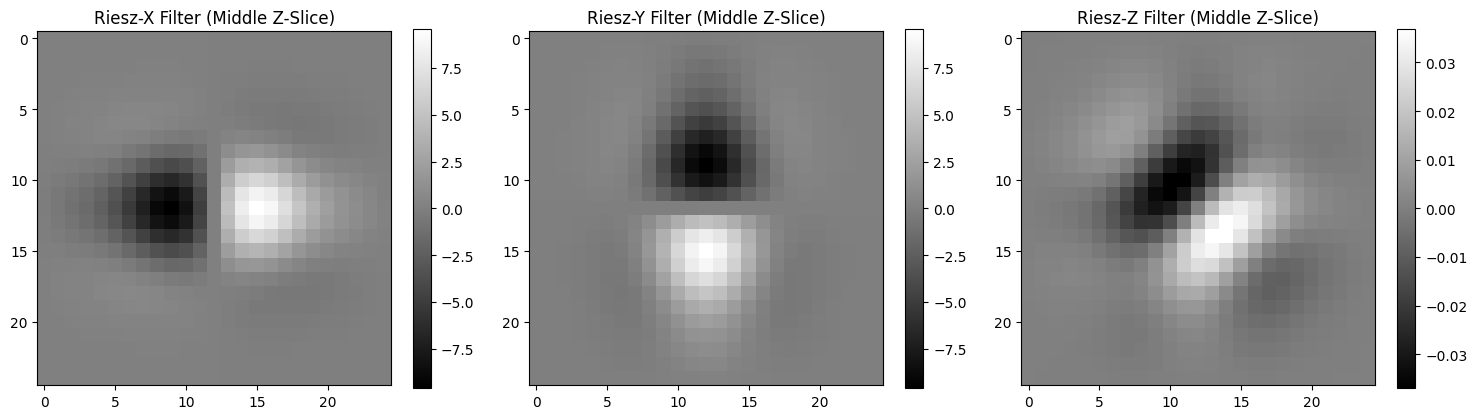

In [98]:
# Choose a middle slice index (z-axis here)
mid_slice = riesz_x.shape[0] // 2

plt.figure(figsize=(15, 4))

# X-direction Riesz
plt.subplot(1, 3, 1)
plt.imshow(riesz_x[mid_slice], cmap='gray')
plt.title('Riesz-X Filter (Middle Z-Slice)')
plt.colorbar()

# Y-direction Riesz
plt.subplot(1, 3, 2)
plt.imshow(riesz_y[mid_slice], cmap='gray')
plt.title('Riesz-Y Filter (Middle Z-Slice)')
plt.colorbar()

# Z-direction Riesz
plt.subplot(1, 3, 3)
plt.imshow(riesz_z[mid_slice], cmap='gray')
plt.title('Riesz-Z Filter (Middle Z-Slice)')
plt.colorbar()

plt.tight_layout()
plt.show()


Since `l = (1, 0, 0)`, we only use the `riesz_x` filter.

In [99]:
filtered3RZI = convolve(zero_pad_impulse, riesz_x, mode='reflect')

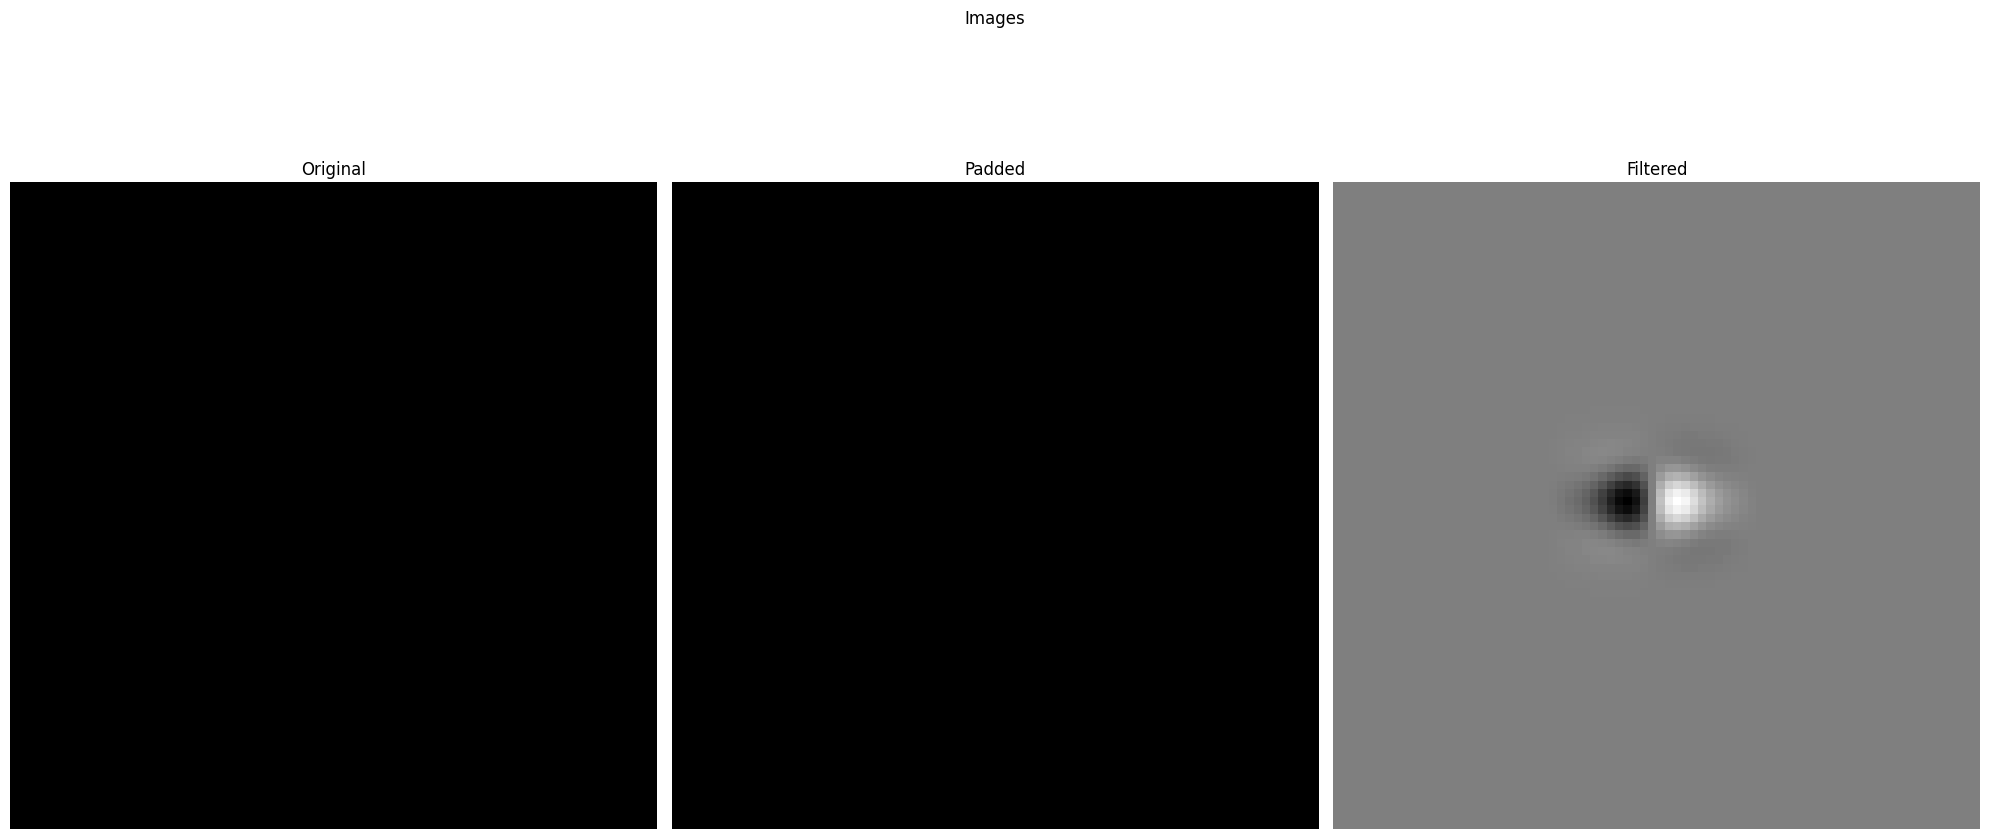

In [100]:
visualize_images_3D(impulse, zero_pad_impulse, filtered3RZI)

For `l = (0, 2, 0)` (second-order in y-direction), we need to use a generalized Riesz transform.

In [101]:
# Apply second-order Riesz transform along y-axis: l = (0, 2, 0)
riesz_y2 = riesz_transform_3d(filter_kernel, l=(0, 2, 0))

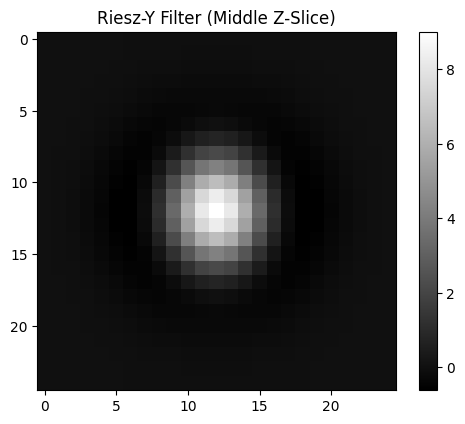

In [102]:
# Choose a middle slice index (z-axis here)
mid_slice = riesz_x.shape[0] // 2

plt.figure(figsize=(15, 4))

# Y-direction Riesz
plt.subplot(1, 3, 2)
plt.imshow(riesz_y2[mid_slice], cmap='gray')
plt.title('Riesz-Y Filter (Middle Z-Slice)')
plt.colorbar()

plt.tight_layout()
plt.show()


In [103]:
# Apply the second-order y-direction Riesz-transformed filter to the image
filtered_3RZS = convolve(zero_pad_sphere, riesz_y2)

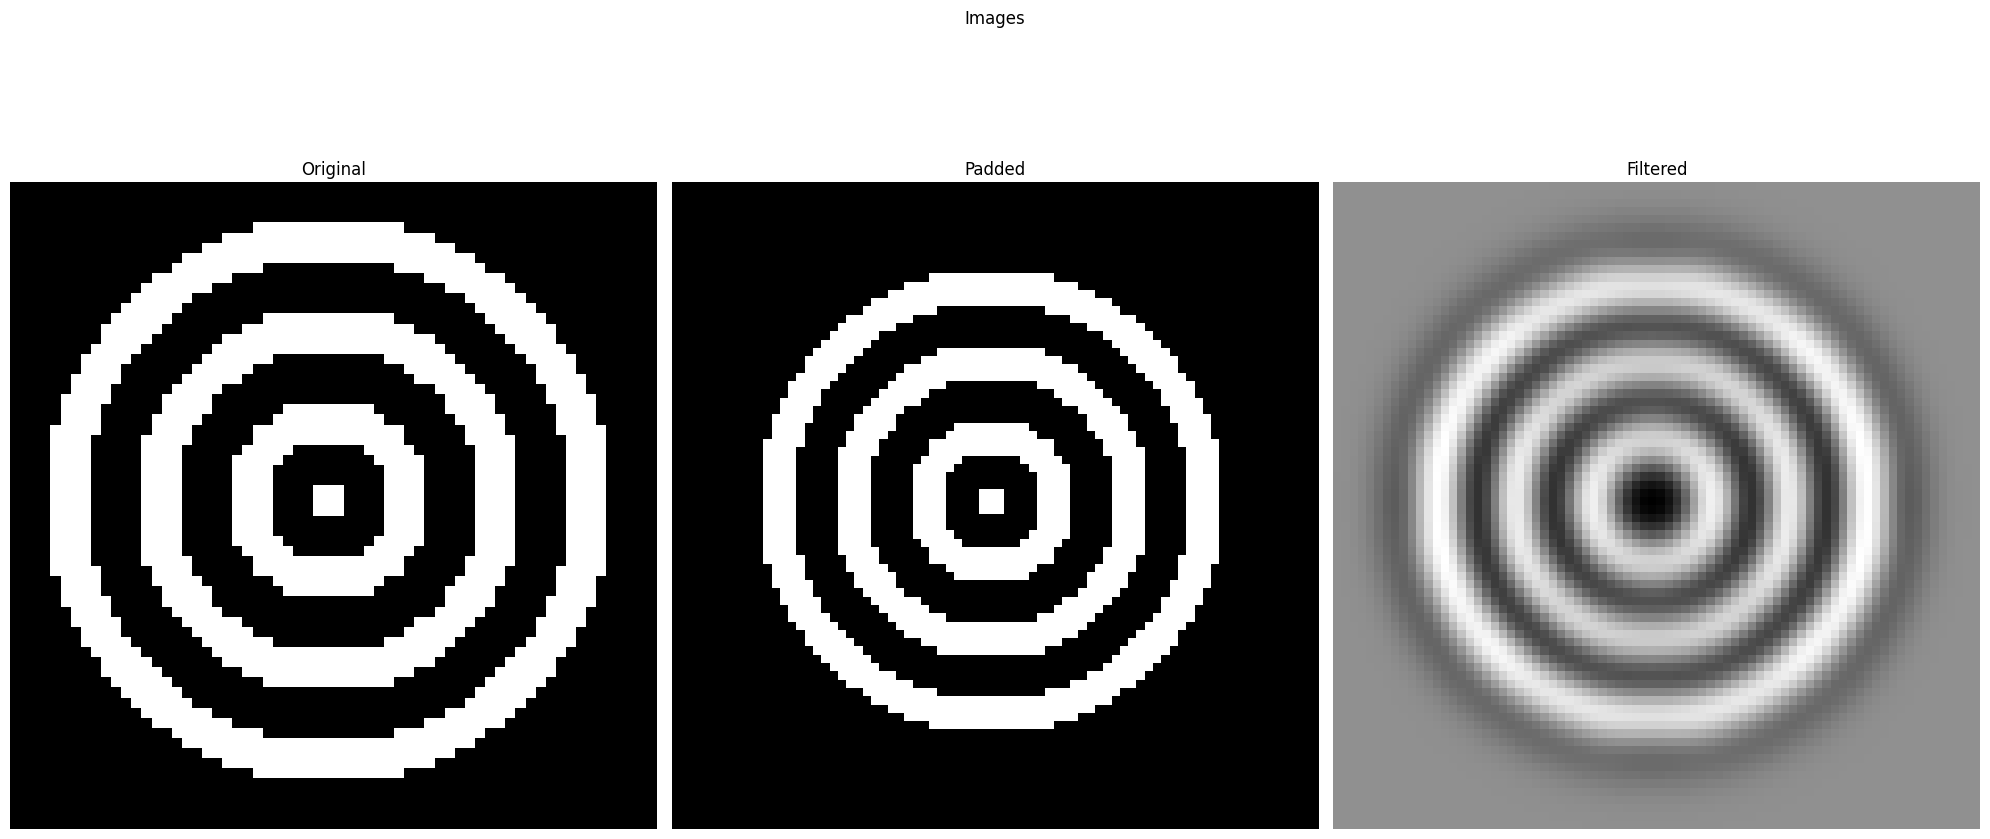

In [104]:
# Visualize
visualize_images_3D(sphere, zero_pad_sphere, filtered_3RZS)

#### Aligned By Structured Tensor , tensor = 1 mm
After applying the Riesz-filtered LoG, align its orientation with the dominant direction of the local structure, estimated using the structure tensor at 1mm scale.

* Steps:
1. Generate LoG kernel
2. Apply generalized Riesz transform with l=(0, 2, 0)
3. Compute structure tensor on the image (at 1mm scale)
4. Align the filter with the dominant eigenvector of the structure tensor

In [105]:
from scipy.ndimage import gaussian_filter, sobel

def compute_structure_tensor(image, sigma=1.0):
    # Compute image gradients
    gx = gaussian_filter(sobel(image, axis=2), sigma)
    gy = gaussian_filter(sobel(image, axis=1), sigma)
    gz = gaussian_filter(sobel(image, axis=0), sigma)

    # Outer products
    Jxx = gaussian_filter(gx * gx, sigma)
    Jyy = gaussian_filter(gy * gy, sigma)
    Jzz = gaussian_filter(gz * gz, sigma)
    Jxy = gaussian_filter(gx * gy, sigma)
    Jxz = gaussian_filter(gx * gz, sigma)
    Jyz = gaussian_filter(gy * gz, sigma)

    return Jxx, Jyy, Jzz, Jxy, Jxz, Jyz

In [106]:
def compute_dominant_eigenvector(Jxx, Jyy, Jzz, Jxy, Jxz, Jyz):
    shape = Jxx.shape
    eigvecs = np.zeros(shape + (3,))
    
    for z in range(shape[0]):
        for y in range(shape[1]):
            for x in range(shape[2]):
                J = np.array([
                    [Jxx[z,y,x], Jxy[z,y,x], Jxz[z,y,x]],
                    [Jxy[z,y,x], Jyy[z,y,x], Jyz[z,y,x]],
                    [Jxz[z,y,x], Jyz[z,y,x], Jzz[z,y,x]]
                ])
                # Eigen decomposition
                w, v = np.linalg.eigh(J)
                eigvecs[z, y, x] = v[:, np.argmax(w)]  # principal direction
    return eigvecs

In [107]:
def save_filtered_images(filtered_imgs, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    
    for name, img_tensor in filtered_imgs:
        np_img = img_tensor.numpy() if hasattr(img_tensor, 'numpy') else np.array(img_tensor)
        nifti_img = nib.Nifti1Image(np_img, affine=np.eye(4))
        nib.save(nifti_img, os.path.join(save_dir, f'{name}.nii.gz'))

*alignment* means rotating the Riesz-filtered kernel to match the local dominant orientation before convolution. There are two approaches:

*Approximate*: Convolve with original l=(0,2,0) Riesz-filter, then use the dot product with the orientation vector.

*Exact (hard)*: Apply a rotated version of the Riesz-filter per voxel (very slow).


In [108]:
# Modulate response by local orientation (dot product approx)
Jxx, Jyy, Jzz, Jxy, Jxz, Jyz = compute_structure_tensor(zero_pad_sphere, sigma=1.0)
dominant_dirs = compute_dominant_eigenvector(Jxx, Jyy, Jzz, Jxy, Jxz, Jyz)

# Project orientation onto y-axis, since l=(0,2,0) is y-oriented
alignment_weight = dominant_dirs[..., 1]**2  # square to match 2nd order

# Final aligned response
aligned_response = filtered_3RZS * alignment_weight

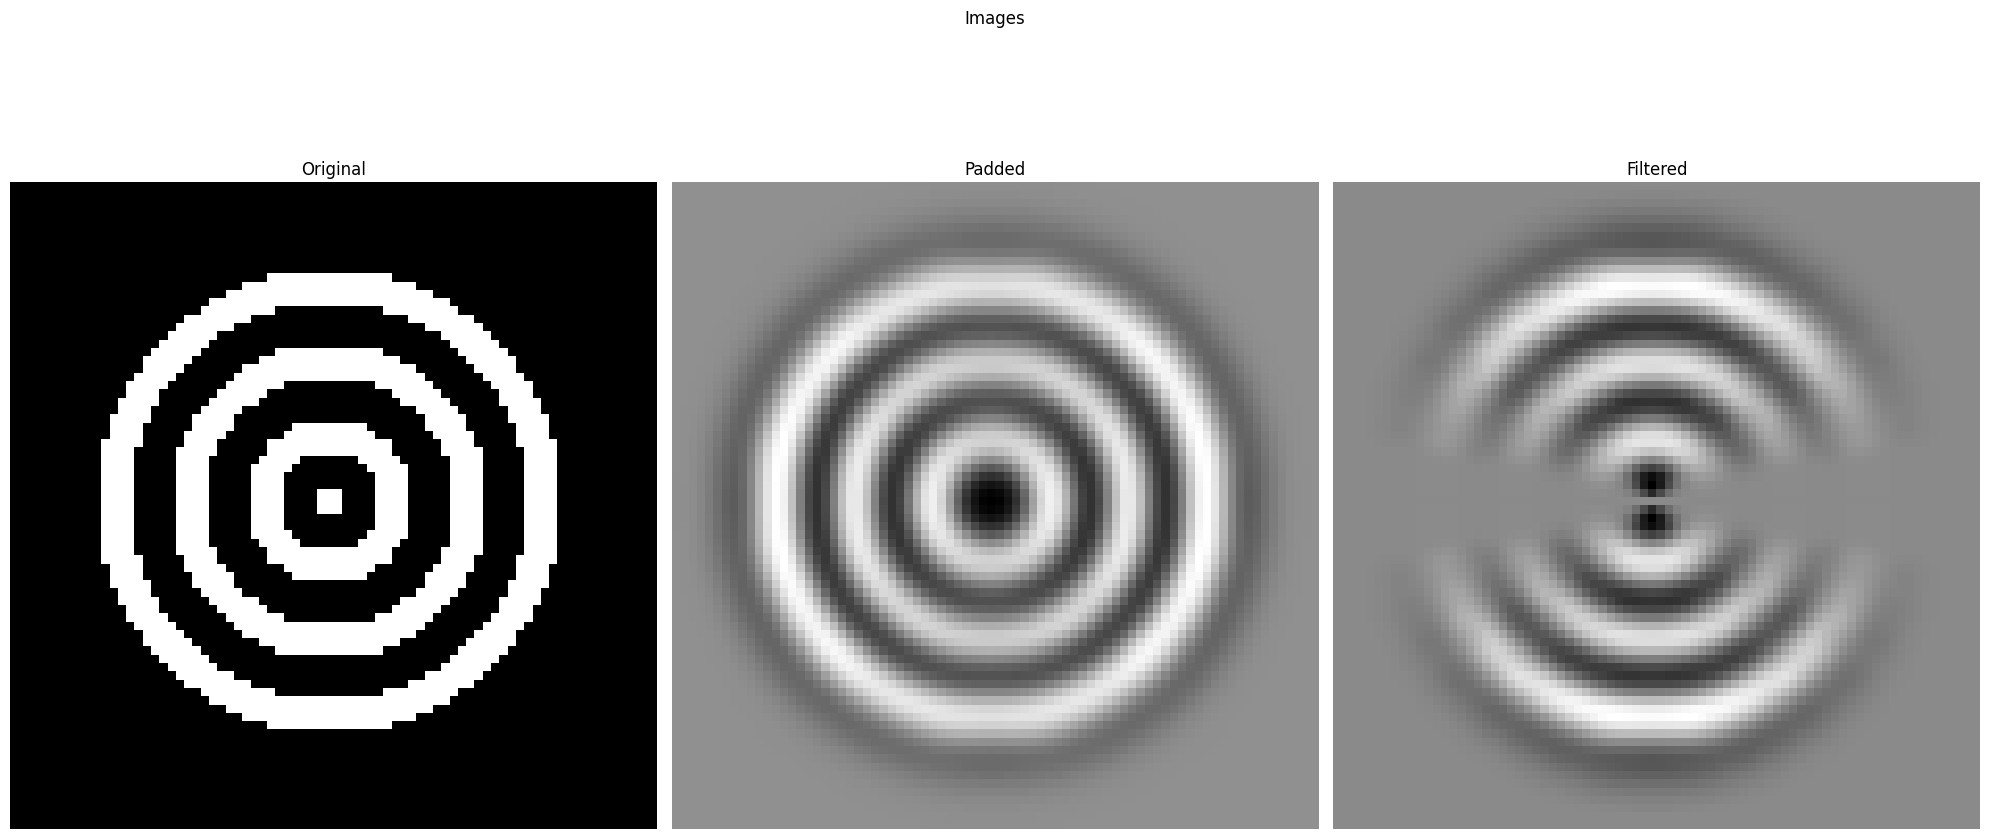

In [109]:
visualize_images_3D(zero_pad_sphere, filtered_3RZS, aligned_response)

#### Riesz-transformed Simoncelli

In [110]:
def create_simoncelli_filter(shape, scale_level=1):
    """
    Create 3D Simoncelli bandpass filter (B map) for a given scale level.
    Parameters:
        shape: tuple of 3 ints (z,y,x)
        scale_level: int, octave level, 1 means first octave (lowest freq band)
    Returns:
        simoncelli_filter: 3D numpy array in spatial domain
    """
    # Frequency grids
    z, y, x = np.meshgrid(
        np.fft.fftfreq(shape[0]), 
        np.fft.fftfreq(shape[1]), 
        np.fft.fftfreq(shape[2]),
        indexing='ij'
    )
    radius = np.sqrt(x**2 + y**2 + z**2)
    radius[radius == 0] = 1e-10  # avoid zero division

    # Define radial passband (Simoncelli's bandpass filter)
    # For octave scale_level, center freq = 1/(2^scale_level)
    center_freq = 1.0 / (2**scale_level)
    low_cutoff = center_freq / np.sqrt(2)
    high_cutoff = center_freq * np.sqrt(2)

    # Smooth transition using raised cosine
    def raised_cosine(r, low, high):
        transition = (np.cos(np.pi * (np.log2(r / low) / np.log2(high / low))) + 1) / 2
        return np.where((r >= low) & (r <= high), transition, 0.0)

    filter_band = raised_cosine(radius, low_cutoff, high_cutoff)

    # Center freq passband - 1st level only
    return filter_band

In [111]:
# Step 1: Create Simoncelli filter in frequency domain
shape = zero_pad_impulse.shape
scale_level = 1
simoncelli_freq = create_simoncelli_filter(shape, scale_level)

In [112]:
# Step 2: Convert Simoncelli filter to spatial domain kernel
simoncelli_spatial_kernel = np.real(ifftn(ifftshift(simoncelli_freq)))

In [113]:
# Step 3: Apply Riesz transform to the Simoncelli spatial kernel
l_order = (1, 0, 0)  # l = (1, 0, 0)
riesz_kernel = riesz_transform_3d(simoncelli_spatial_kernel, l=l_order)

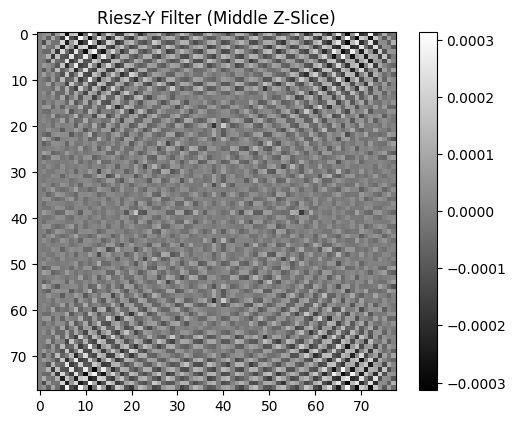

In [114]:
# Visualize the Kernel

# Choose a middle slice index (z-axis here)
mid_slice = riesz_x.shape[0] // 2

plt.figure(figsize=(15, 4))

# Y-direction Riesz
plt.subplot(1, 3, 2)
plt.imshow(riesz_kernel[mid_slice], cmap='gray')
plt.title('Riesz-Y Filter (Middle Z-Slice)')
plt.colorbar()

plt.tight_layout()
plt.show()


In [118]:
from scipy.signal import fftconvolve

# Step 4: Convolve image with the Riesz-transformed kernel
filtered_3RSZI = fftconvolve(zero_pad_impulse, riesz_kernel, mode='same')

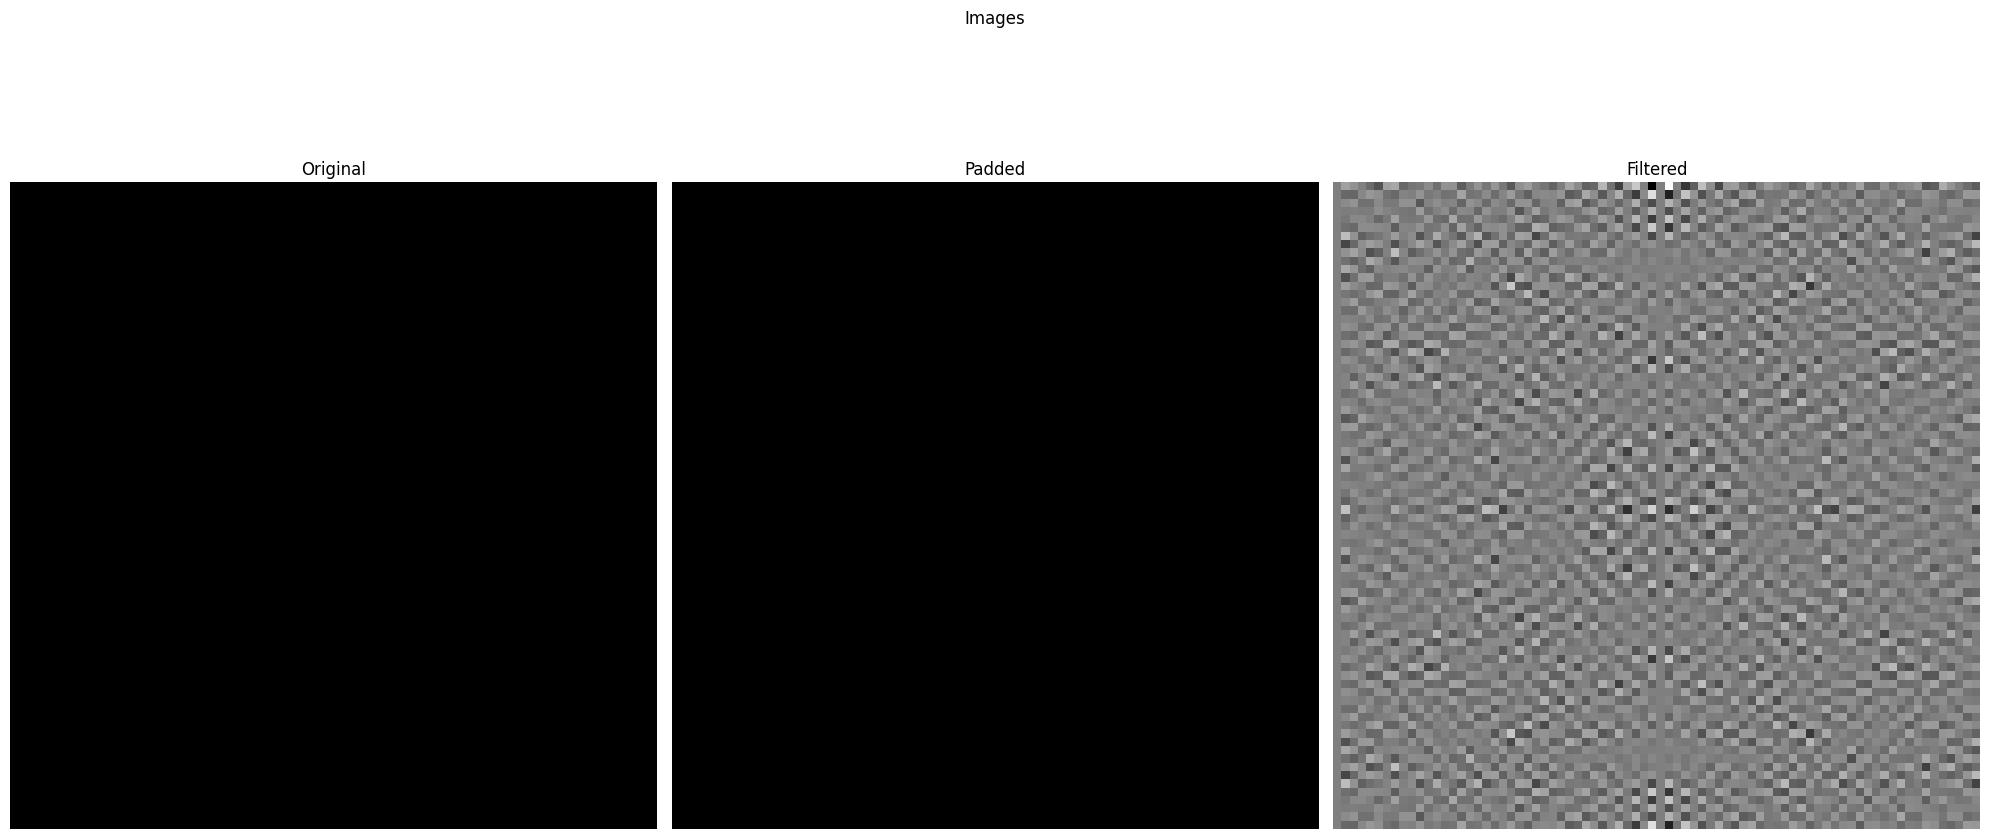

In [119]:
visualize_images_3D(impulse, zero_pad_impulse, filtered_3RSZI)

In [122]:
# 1. Create Simoncelli B map filter (1st level)
simoncelli_filter_1 = create_simoncelli_filter(nearest_pad_pattern_1.shape, scale_level=1)

In [123]:
# 2. Apply Riesz transform with l=(0,2,0) on that filter
riesz_filter_0_2_0 = riesz_transform_3d(simoncelli_filter_1, l=(0, 2, 0))

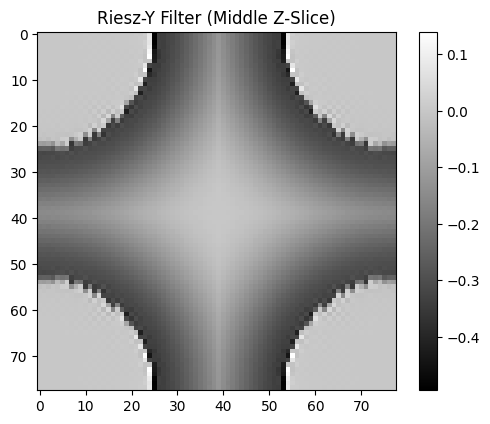

In [134]:
# Visualize the Kernel

# Choose a middle slice index (z-axis here)
mid_slice = riesz_x.shape[0] // 2

plt.figure(figsize=(15, 4))

# Y-direction Riesz
plt.subplot(1, 3, 2)
plt.imshow(riesz_filter_0_2_0[mid_slice], cmap='gray')
plt.title('Riesz-Y Filter (Middle Z-Slice)')
plt.colorbar()

plt.tight_layout()
plt.show()


In [125]:
# 3. Convolve input volume with the Riesz-transformed filter using fftconvolve
filtered_3RSNP = fftconvolve(nearest_pad_pattern_1, riesz_filter_0_2_0, mode='same')

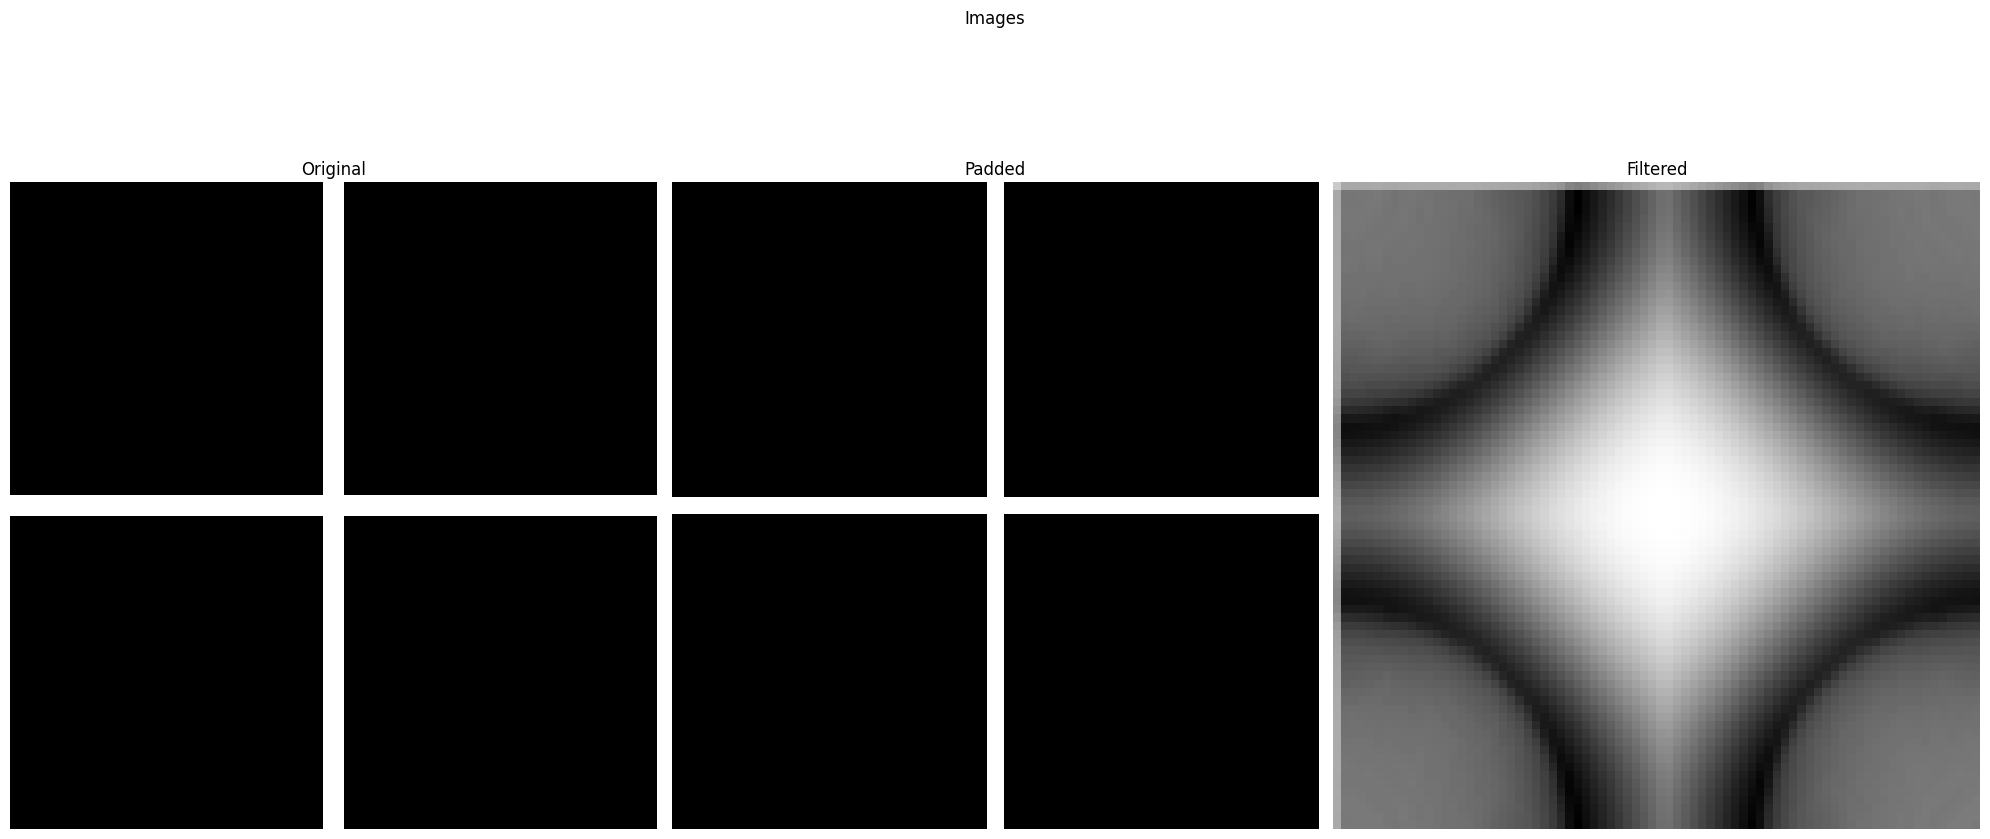

In [126]:
# 4. Visualize
visualize_images_3D(pattern_1, nearest_pad_pattern_1, filtered_3RSNP)

In [127]:
# 5: Compute structure tensor on the input volume (nearest_pad_pattern_1)
Jxx, Jyy, Jzz, Jxy, Jxz, Jyz = compute_structure_tensor(nearest_pad_pattern_1, sigma=1.0)

In [128]:
# 6: Compute dominant eigenvector (principal orientation) per voxel
dominant_dirs = compute_dominant_eigenvector(Jxx, Jyy, Jzz, Jxy, Jxz, Jyz)

In [129]:
# 7: Compute alignment weight by projecting dominant eigenvector onto Riesz order direction (l=(0,2,0))
l_vector = np.array([0, 2, 0])
l_norm = np.linalg.norm(l_vector)
unit_l = l_vector / l_norm if l_norm != 0 else np.array([0, 0, 0])

In [130]:
# Dot product per voxel (broadcast over last dimension) and square it (because order 2)
alignment_weight = np.sum(dominant_dirs * unit_l, axis=-1) ** 2

In [ ]:
# 8: Modulate filtered response by the alignment weight
aligned_response = filtered_3RSNP * alignment_weight

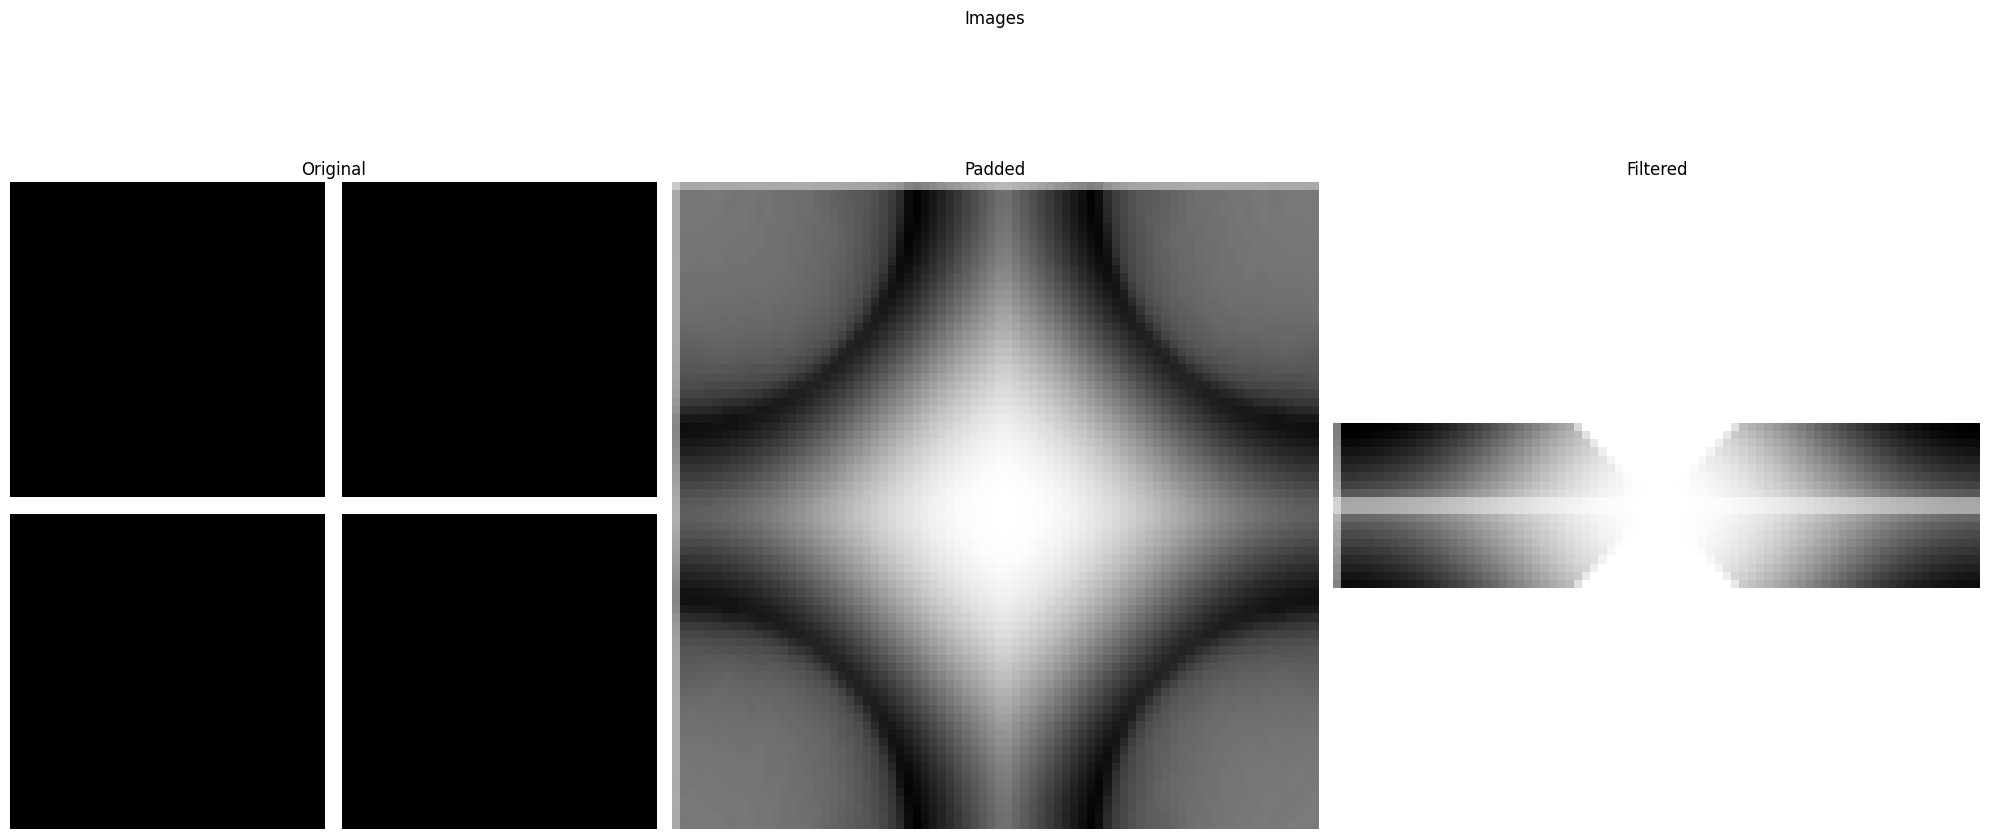

In [132]:
# 9: Visualize
visualize_images_3D(nearest_pad_pattern_1, filtered_3RSNP, aligned_response)

In [ ]:
len(filtered_images)

In [ ]:
save_filtered_images(filtered_images, '/kaggle/working/')